# Trading on 26 US Tech Equities, 30min data

In this document you will find a set of series of 30min tick prices in USD of US tech stocks, adjusted for splits. The data runs from mid July 2015 to early December 2016 ($n=5000$) and is only reported for during trading hours. We would like you to trade these stocks long or short based on trading signals or analysis derived from modelling this data. To simplify the trading problem, you can hold a position only for one interval (30min or overnight) and do not need to account for trading costs or slippage. You can have up to $100M invested and allocate the budget as you see fit. We would like to optimise the conditional Sharpe ratio:

\begin{equation}
\rm{cSharpe} = \frac{\mu}{\sigma}*\sqrt{255*14}
\end{equation}

with $\mu$ the mean of your returns per interval and $\sigma$ the standard deviation, conditional on having traded in that interval. (The $\sqrt{255*14}$ is a scaling to report the result in a annualised manner, with roughly 255 trading days and 14 trading intervals per day). 

Your task is to design a strategy on these stocks with a high conditional sharpe ratio. Your input data will be the historic price series to predict the future price return of the stocks. We will focus on your analysis of the data and your reasoning in designing a strategy here. The question is open ended, but we would expect you to not spent more than 2 hours on this problem.

You might find these questions helpful:
- What is a good benchmark to compare performance to?
- How can one boost performance of a set of medium performing strategies?


In our next call we will go over your analysis. How did you come up with your strategy? Would you expect your algorithm to do well? Why or why not? We are mostly interested in your reasoning and how you code, the actual performance is not terribly important.

You can use your favourite analysis tool or environment or use this jupyter notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import pylab
import seaborn as sns
# this is to update the functions in other .py files
%reload_ext autoreload
%autoreload 2


# load data
prices = pd.read_csv('data.csv', index_col=0)
print(prices.tail(5))

                           AAPL      ADBE      ADP     AMD       AMZN    ASML  \
[YYYY-MM-DD HH:mm:SS]                                                           
02/12/2016 10:30       27.30125   99.3200  95.3799  8.4829  37.128475   99.45   
02/12/2016 11:00       27.32500   99.6900  95.3808  8.4800  37.169000   99.95   
02/12/2016 11:30       27.46125  100.0264  95.5100  8.5300  37.214525  100.13   
02/12/2016 12:00       27.40000   99.3800  95.3800  8.4700  37.087500   99.68   
02/12/2016 12:30       27.43500   99.6800  95.4400  8.4514  37.049995   99.85   

                          ATVI    AVGO      CRM     CSCO  ...      NFLX  \
[YYYY-MM-DD HH:mm:SS]                                     ...             
02/12/2016 10:30       35.7386  161.87  67.5707  29.4000  ...  118.2350   
02/12/2016 11:00       35.9100  163.37  68.5350  29.4300  ...  118.7800   
02/12/2016 11:30       35.9500  164.35  68.6300  29.4900  ...  119.2300   
02/12/2016 12:00       35.8000  163.73  69.0600  29.4350 

# 1. Prices

## 1.1 General description

In [2]:
prices.describe()

AAPL         ADBE          ADP          AMD         AMZN  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     26.983248    92.737499    86.326361     3.825979    32.507008   
std       2.221215     8.863648     4.544875     2.128623     5.290353   
min      22.479200    71.660000    73.530000     1.620000    21.423500   
25%      24.909044    85.700000    82.858750     2.030000    27.658875   
50%      27.250000    93.175800    86.990000     2.755000    32.958750   
75%      28.567056    98.780000    89.370000     5.950700    37.208312   
max      33.185000   110.860000    97.270000     9.186600    42.294500   

              ASML         ATVI         AVGO          CRM         CSCO  ...  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  ...   
mean     96.762715    35.886586   145.772372    74.762540    28.180551  ...   
std       7.291511     5.275860    19.269004     5.115677     2.123054  ...   
min      77.470000    24.440000   107.300000    52.815000    22.500000  ...   
25%      91.310000    31.910000   127.022500    71.667500    26.830000  ...   
50%      96.590000    36.510000   145.987500    74.907500    28.150000  ...   
75%     102.108750    39.800000   163.261250    78.459925    29.950000  ...   
max     111.470000    45.470000   178.485000    84.160000    31.945000  ...   

              NFLX          NOW         NVDA         ORCL         PYPL  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    103.873546    73.864175    10.346104    38.879367    37.242317   
std      11.291732     8.692290     4.580869     1.841453     2.594306   
min      81.380000    46.200000     4.801250    33.230000    30.404800   
25%      95.527500    70.043750     6.973438    37.733750    35.408750   
50%     100.610000    74.482500     8.473750    39.180000    37.570050   
75%     113.081175    79.058750    13.992500    40.345000    39.200000   
max     131.631100    91.190000    23.782550    41.929000    44.430000   

              QCOM         SIRI         TSLA          TXN          VMW  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean     56.482329     3.988466    14.704528    58.744312    65.983518  
std       6.662220     0.217496     1.662305     7.924957    12.270168  
min      42.556200     3.290000     9.575333    43.520000    43.440000  
25%      51.430000     3.870000    13.563500    51.308750    56.640000  
50%      54.877500     3.970000    14.688667    57.570000    62.435000  
75%      62.505050     4.140000    15.713000    67.442500    76.820000  
max      71.405000     4.640000    19.040920    75.250000    91.970000  

[8 rows x 29 columns]

## 1.2 Plots

C:\Users\flemo\AppData\Local\Temp\ipykernel_3968\702960163.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  prices.plot(ax=ax1, subplots = True, layout = (6, 5),sharex = True,


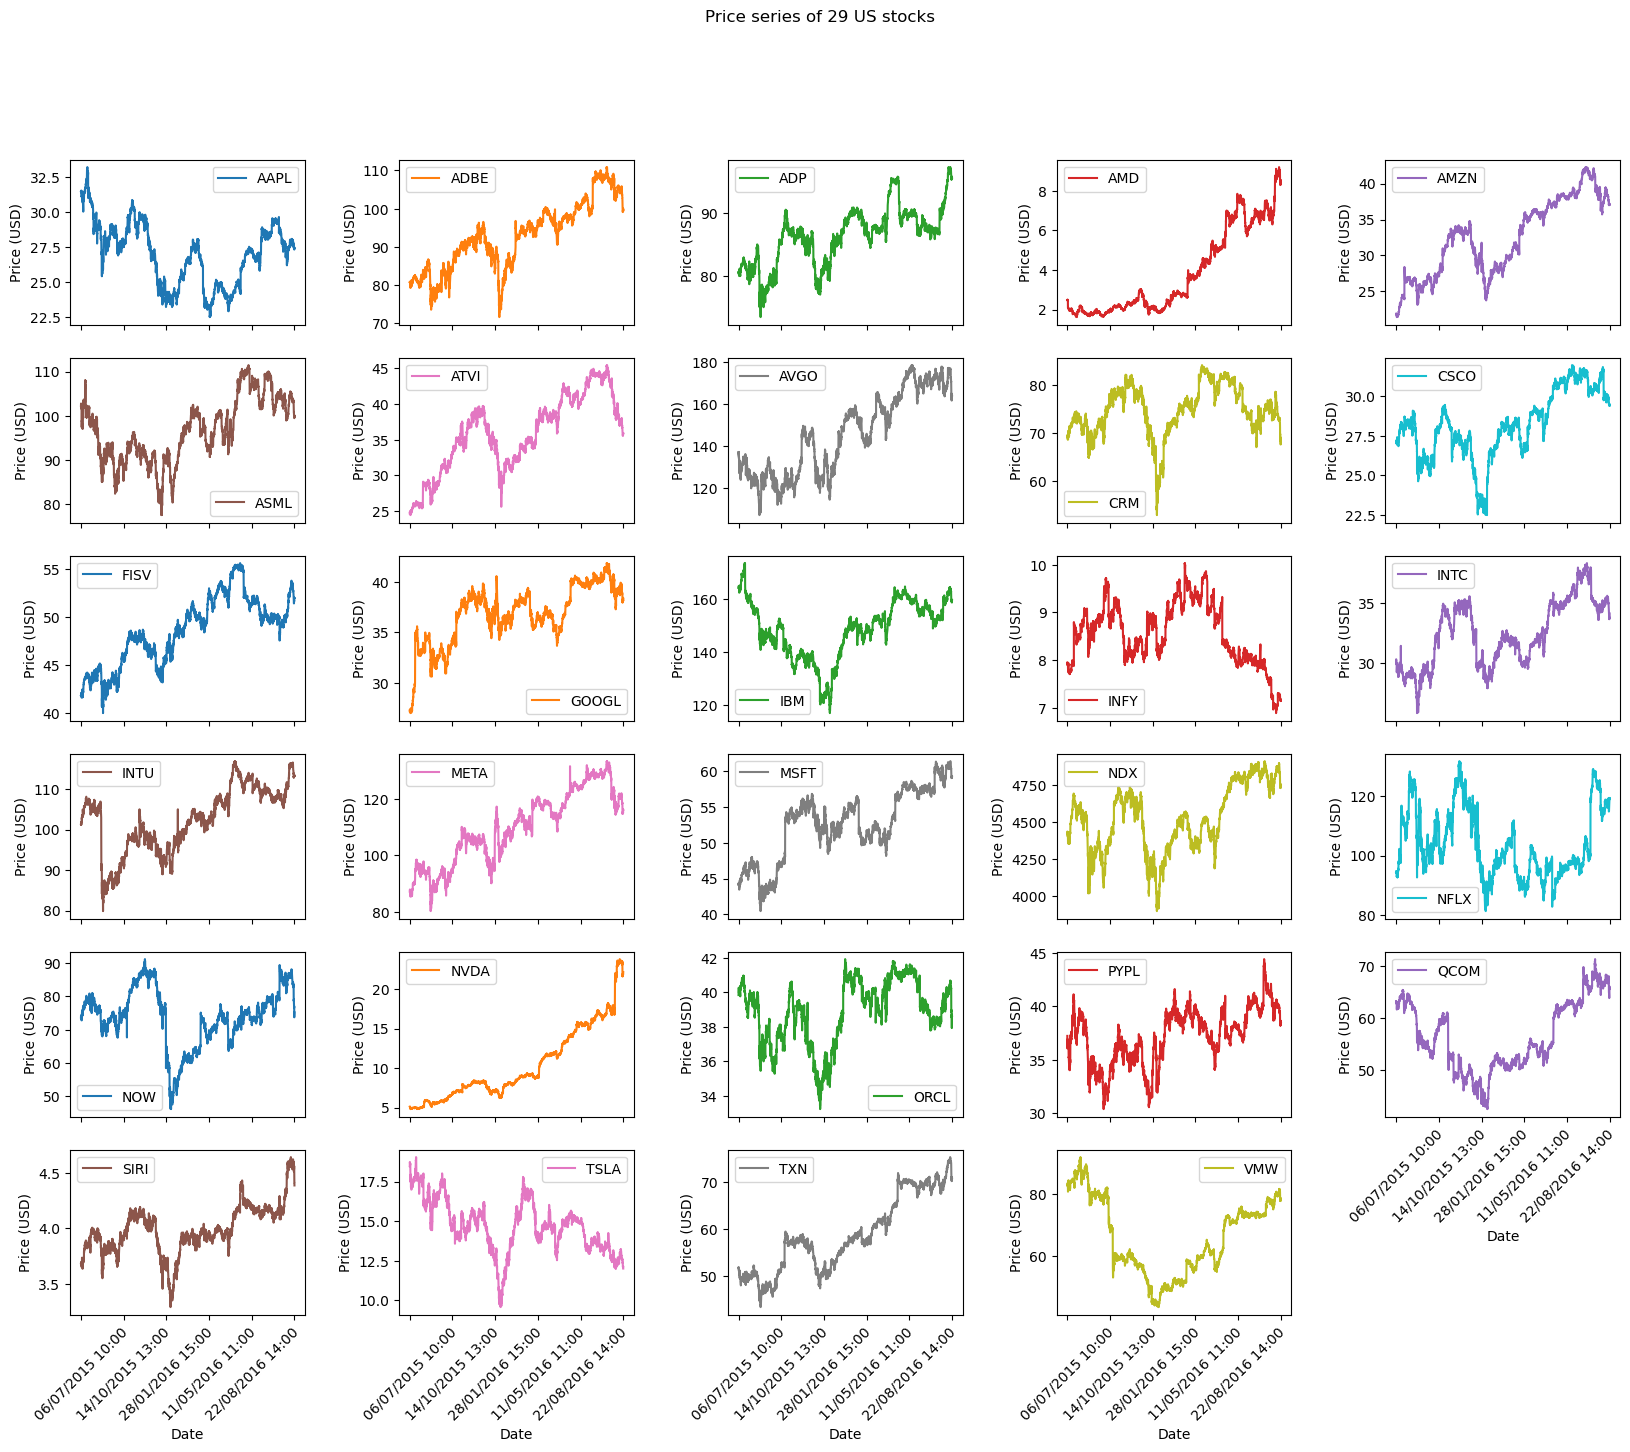

In [3]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot()
prices.plot(ax=ax1, subplots = True, layout = (6, 5),sharex = True,
            title = 'Price series of 29 US stocks', xlabel = 'Date', ylabel = 'Price (USD)', rot = 45)

plt.subplots_adjust(wspace = 0.4)
plt.show()

# 2. Returns

**Returns**
Why use returns (as opposed to prices): Normalization. This ensures that we measure all variables in a 'fair' metric, allowing us to analyze relationships (eg: correlation) among the time series, despite having different magnitudes of the original price-series. Returns can be computed as:

$$
r_i = (p_i - p_j) / p_j
$$

**Log-returns** (as opposed to returns): 1. Log-normality. If we assume that prices are lognormally distributed (may not be), then log(1+return) is normally distributed, which is convenient as much of classic statistics presumes normality.

$$
1+r_i = p_{i} / p_{j} = exp(log(p_i / p_j))
$$

2. Time-addition: In order to caclulate compound returns, one would use the following formula with returns:

$$
\prod_{i=1}^{n}(1+r_i) = (1+r_1) \cdot (1+r_2) \cdots (1+r_n)
$$

this is not ideal because: Product of normally distributed variables is not normal. However, the sum is... When all variables are uncorrelated. This is when log-nomral returns comes in handy because of the logs property:

$$
\sum_{i=1}^{n}\log(1+r_i) = \log(1+r_1) + \log(1+r_2) + \cdots + \log(1+r_n)
$$



## 2.1 Plots

In [4]:
returns = prices.pct_change()
log_returns = np.log(prices) - np.log(prices.shift(1))

C:\Users\flemo\AppData\Local\Temp\ipykernel_3968\1681142168.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  log_returns.plot(ax=ax1, subplots = True, layout = (6, 5),sharex = True,


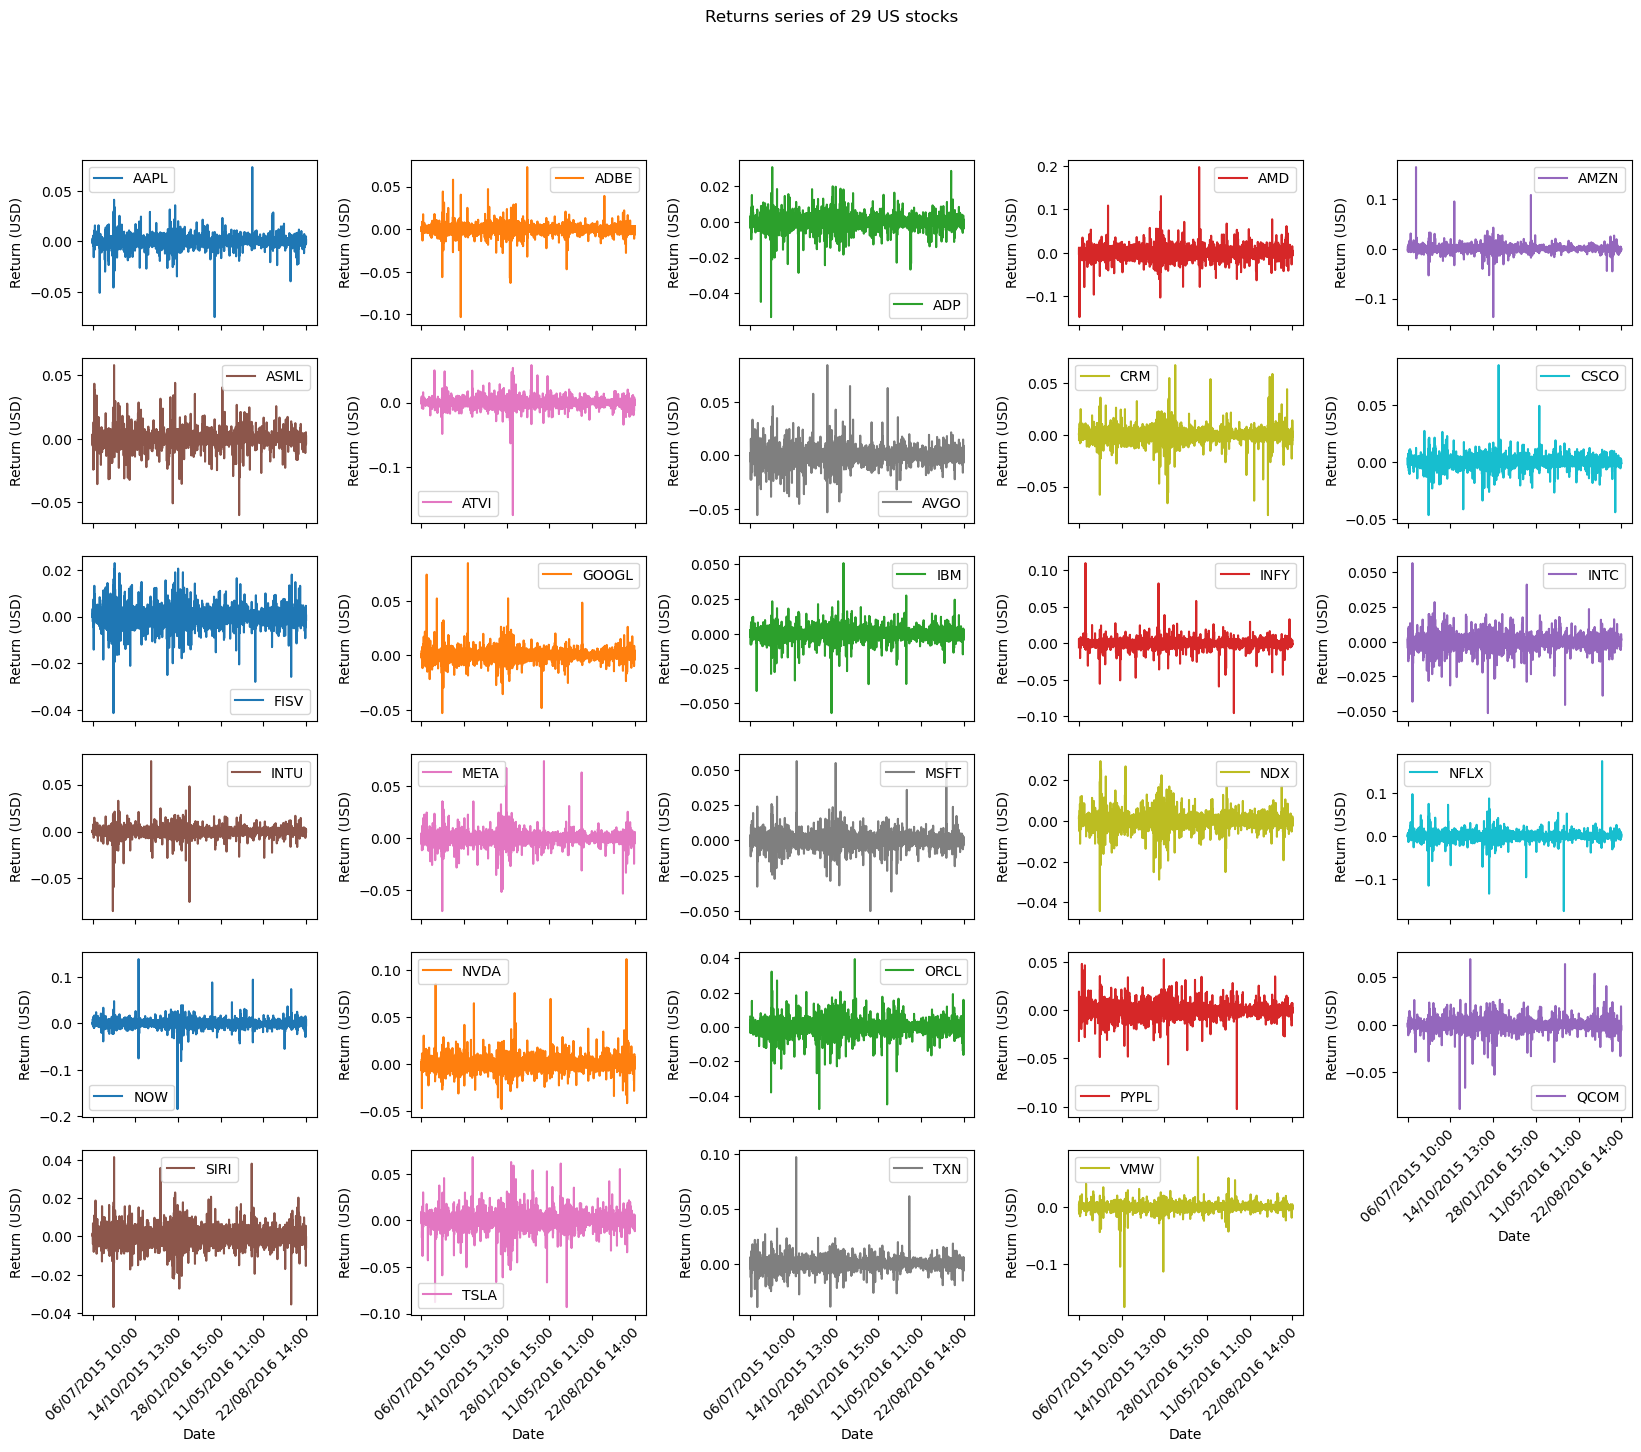

In [5]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot()
log_returns.plot(ax=ax1, subplots = True, layout = (6, 5),sharex = True,
            title = 'Returns series of 29 US stocks', xlabel = 'Date', ylabel = 'Return (USD)', rot = 45)

plt.subplots_adjust(wspace = 0.4)
plt.show()

## 2.2 Distributions

C:\Users\flemo\AppData\Local\Temp\ipykernel_3968\1112289327.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  log_returns.hist(bins = 75, ax=ax1, layout = (6, 5),sharex = True)


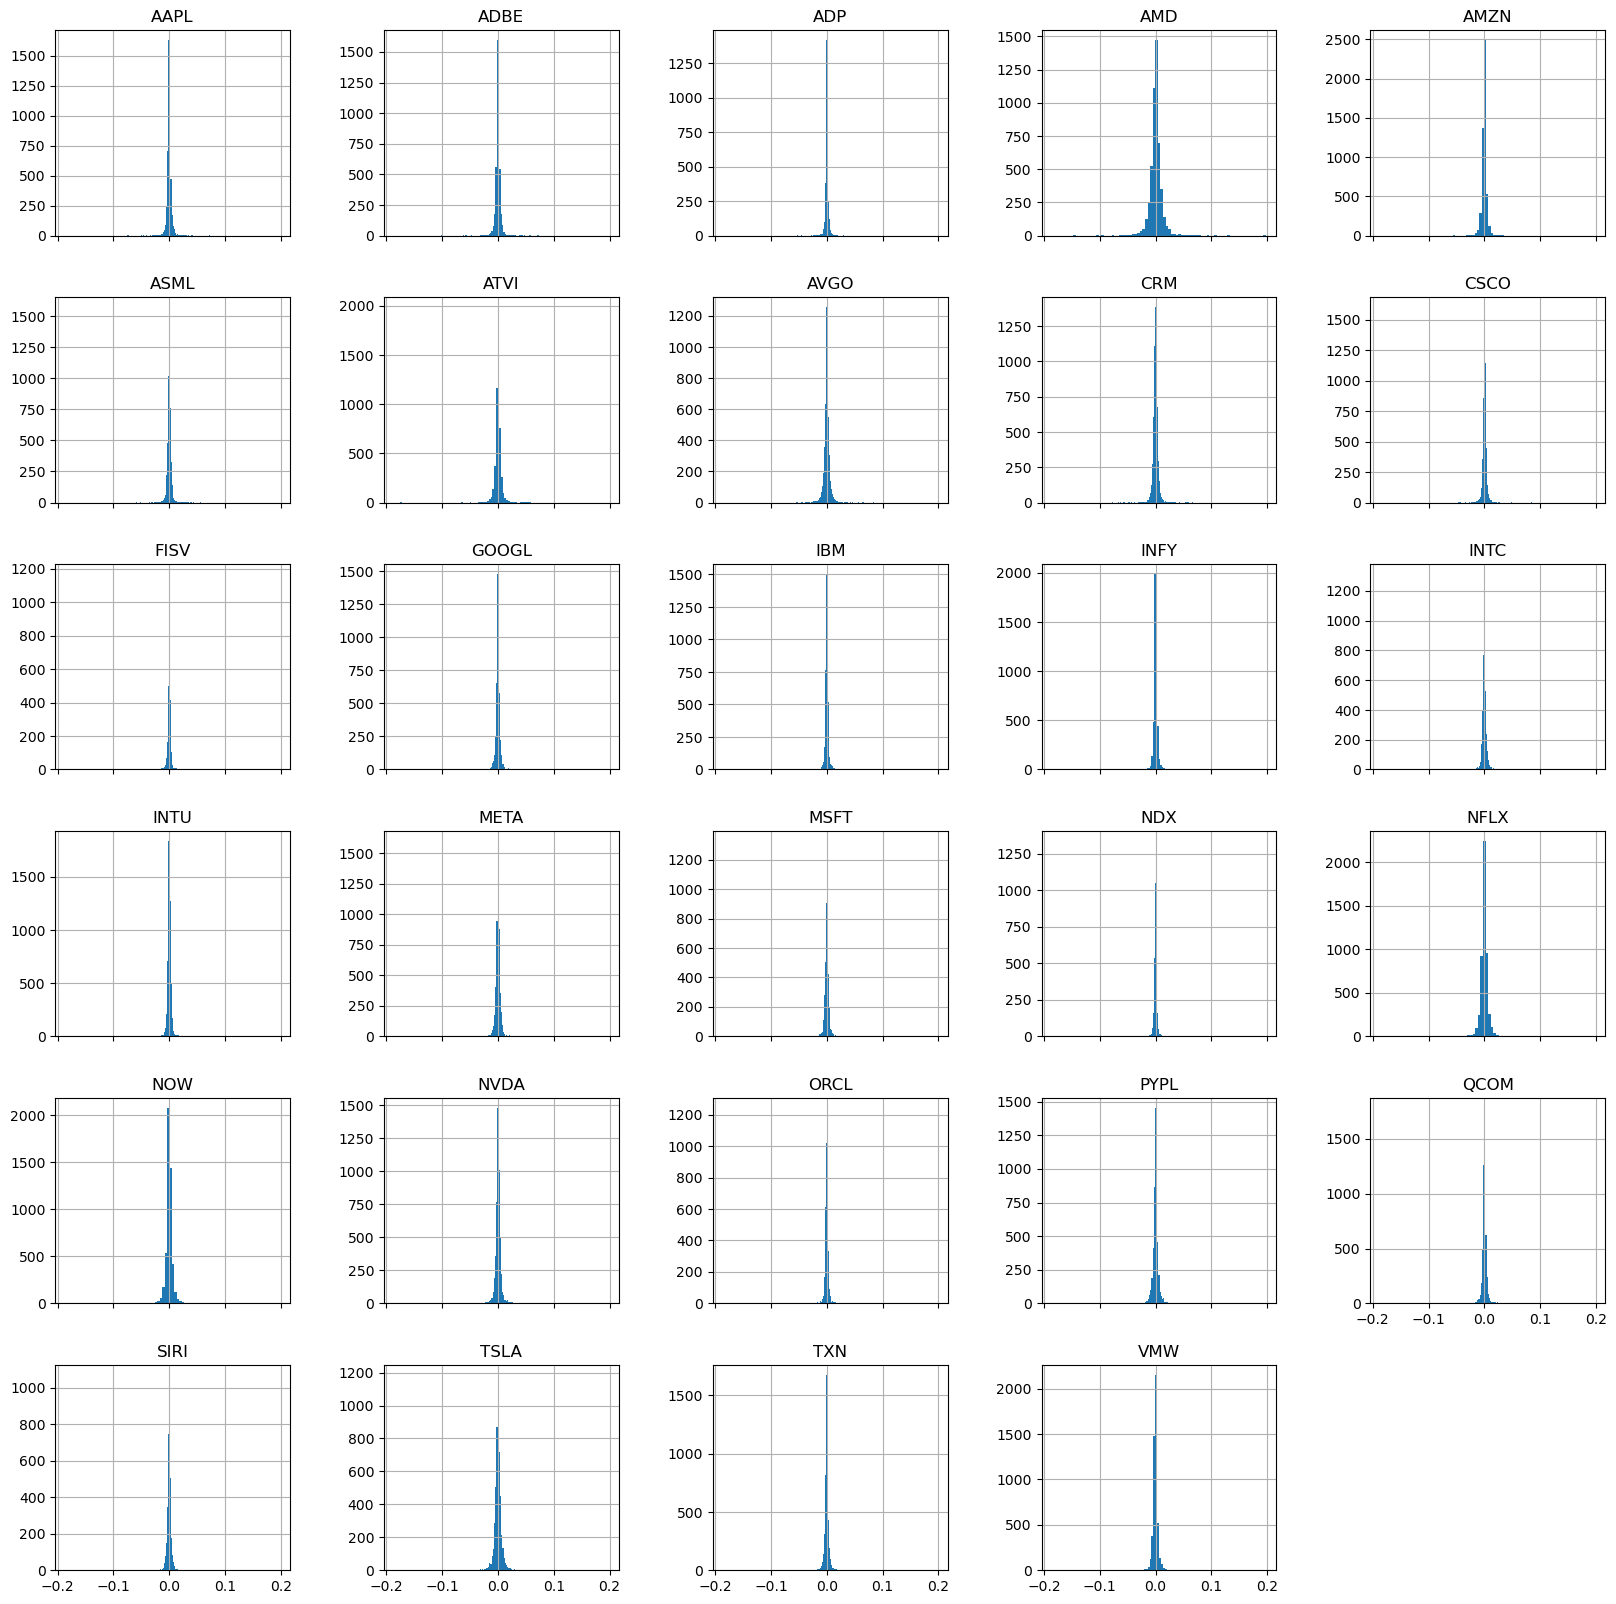

In [6]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot()
ax1.set_xlim(-0.1, 0.1)
log_returns.hist(bins = 75, ax=ax1, layout = (6, 5),sharex = True)
plt.subplots_adjust(wspace = 0.4)
plt.show()

## 2.3 Q-Q plots

**Quantile-Quantile plots**: Graphical way of determining if 2 datasets come from a population with a common distribution. Eg: These plots answer the question of "How similar are the quantiles of the dataset compare to the ones of a theoretical probability  distribution?" --> In this case the normal distribution (red line)

**Conclusion**: We can see that on the edges, the points tend todiverge from the red-line (normal distirbution). which indicates that there are fat-tails in the log-returns.

AAPL


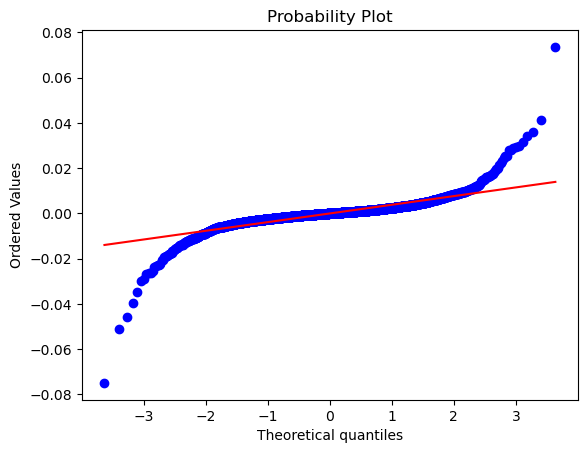

ADBE


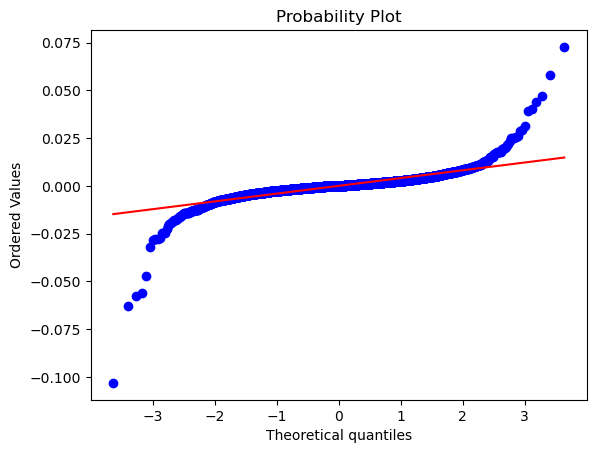

ADP


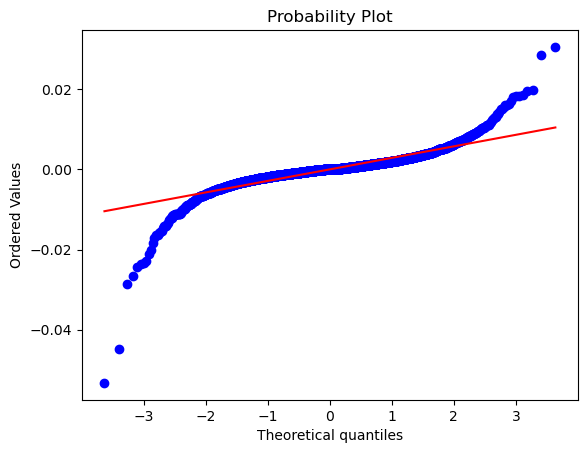

AMD


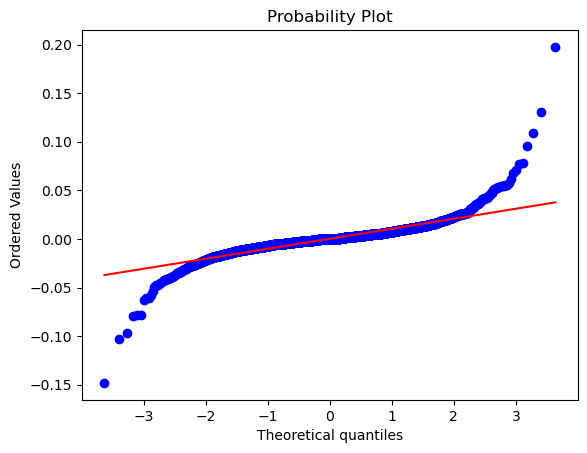

AMZN


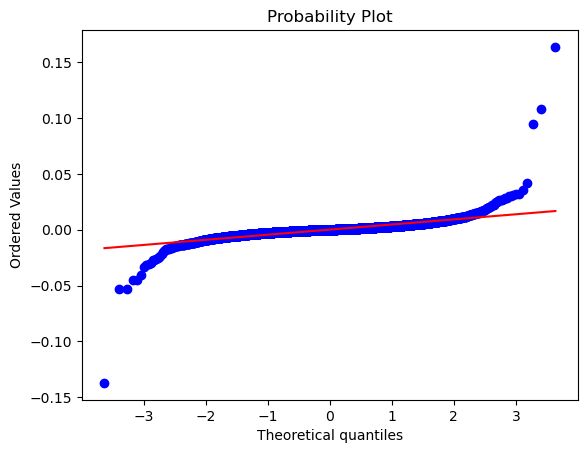

ASML


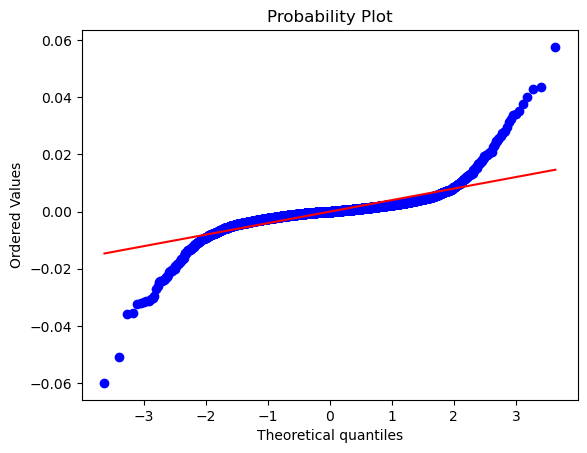

ATVI


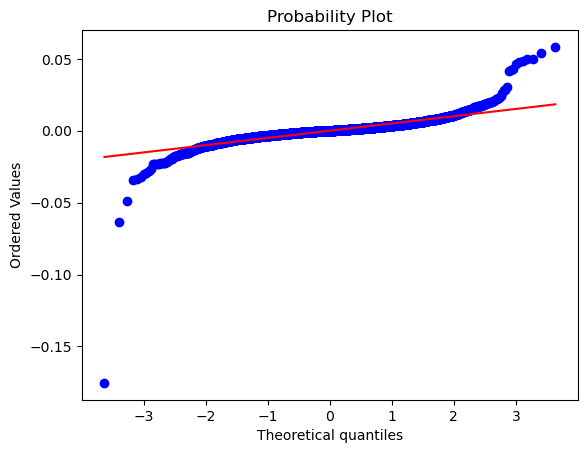

AVGO


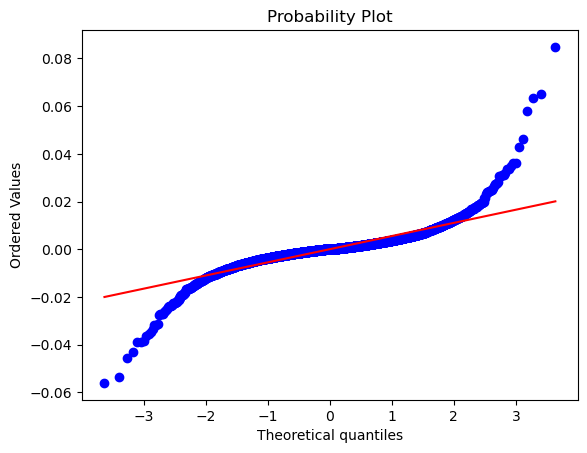

CRM


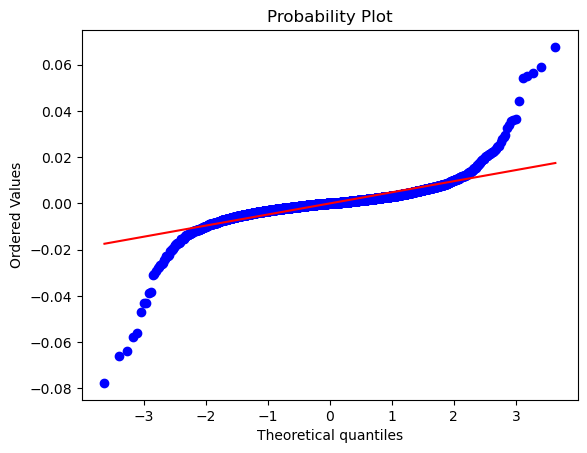

CSCO


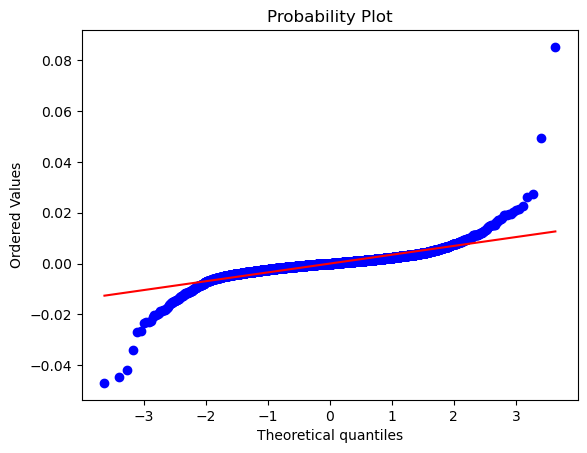

FISV


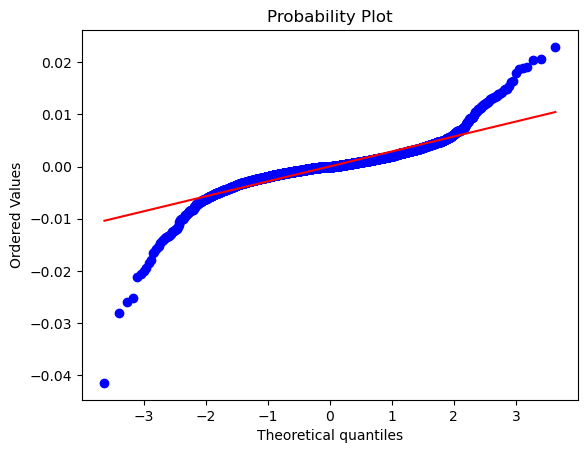

GOOGL


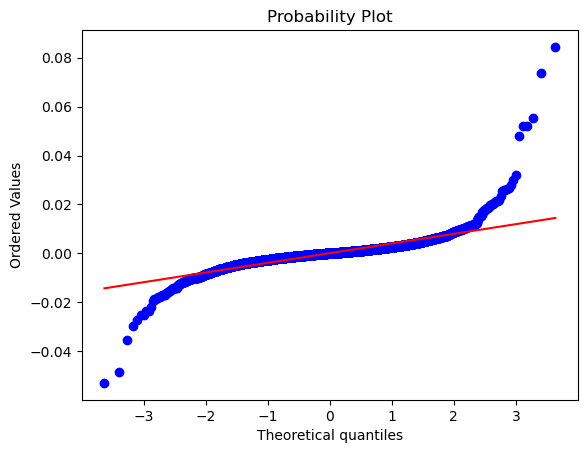

IBM


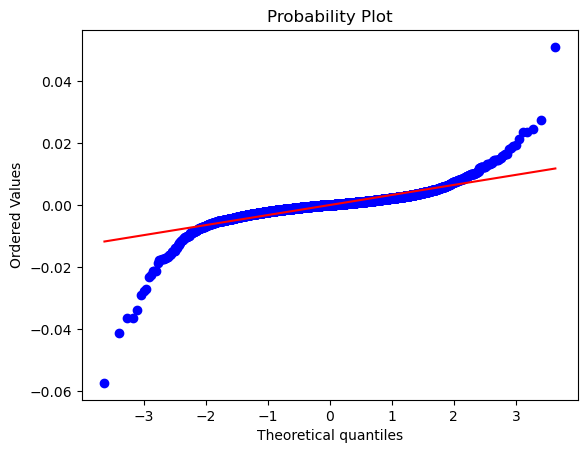

INFY


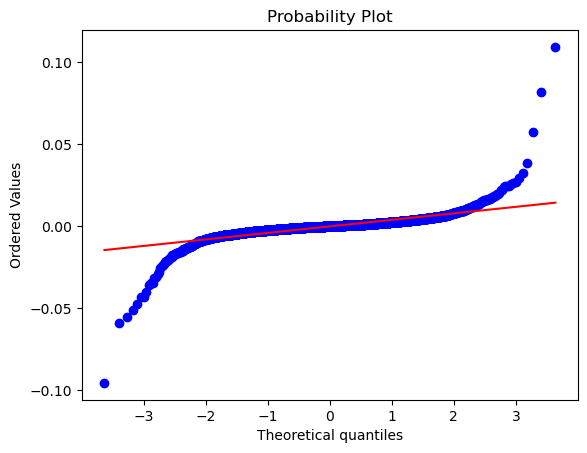

INTC


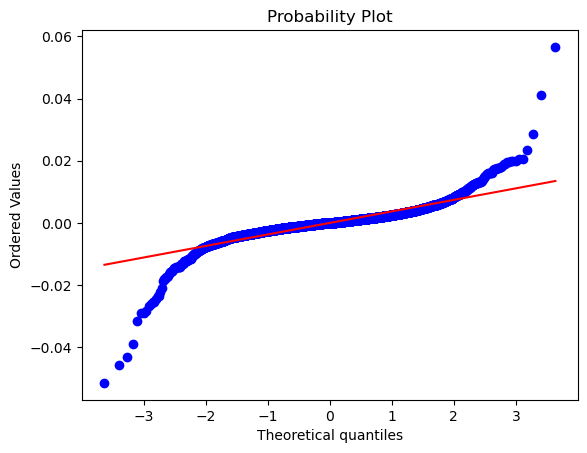

INTU


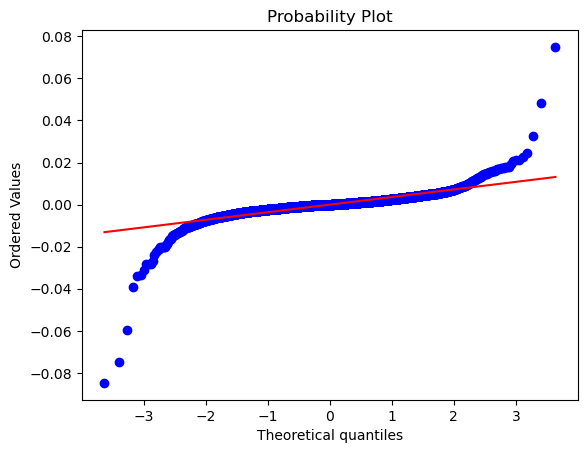

META


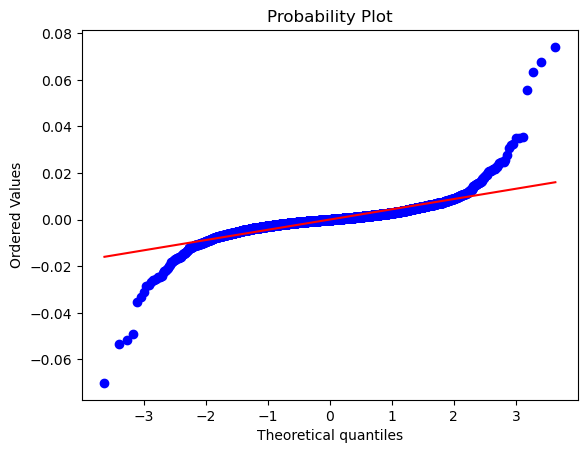

MSFT


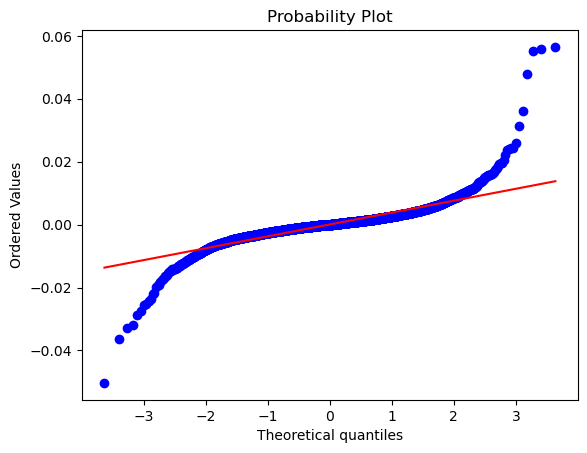

NDX


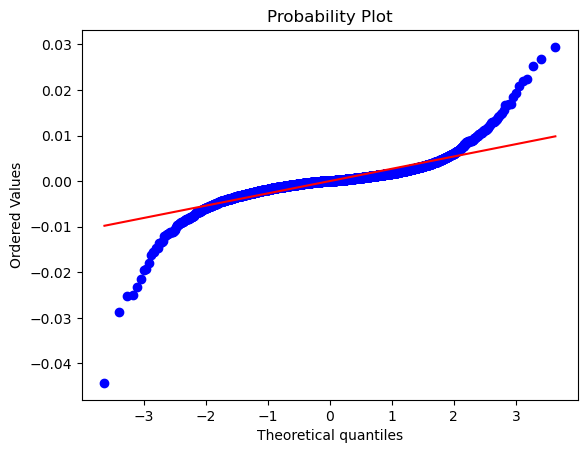

NFLX


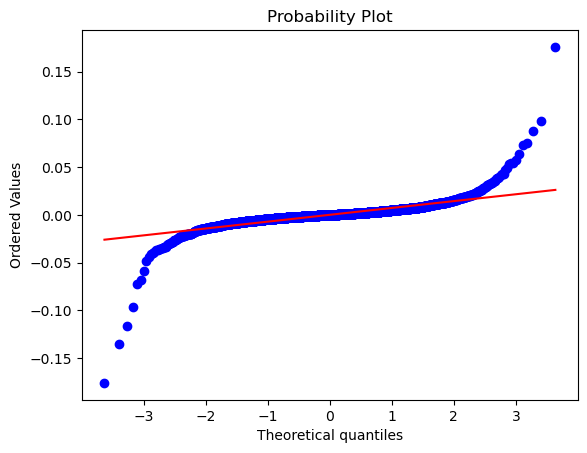

NOW


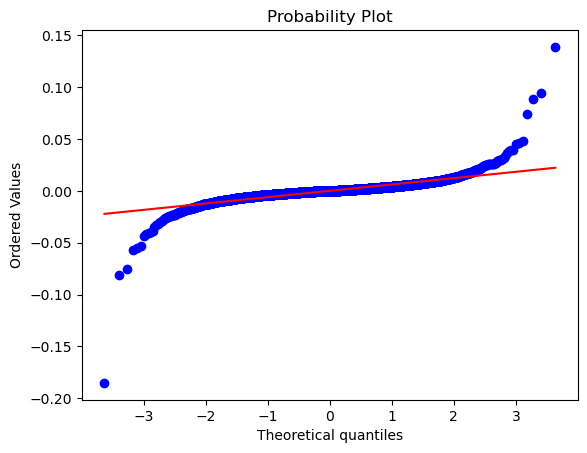

NVDA


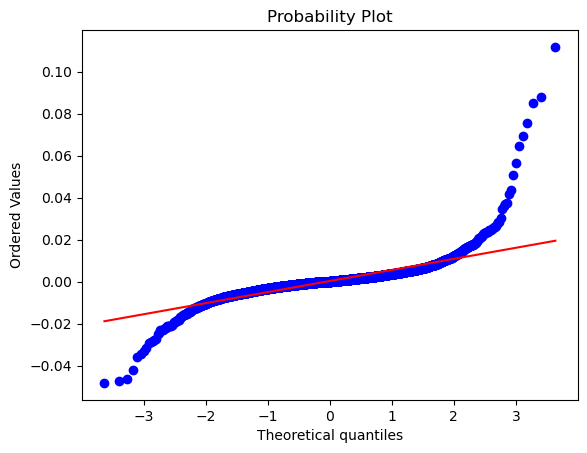

ORCL


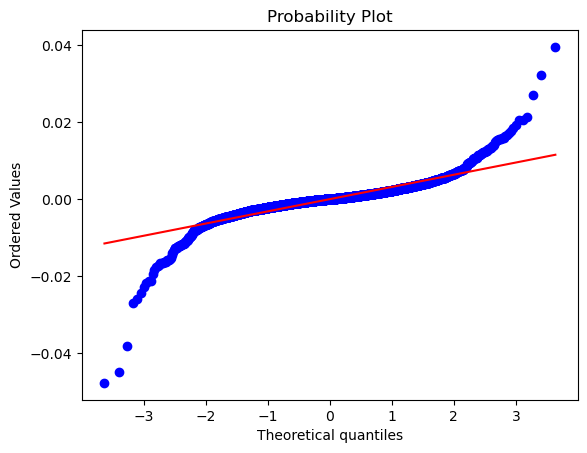

PYPL


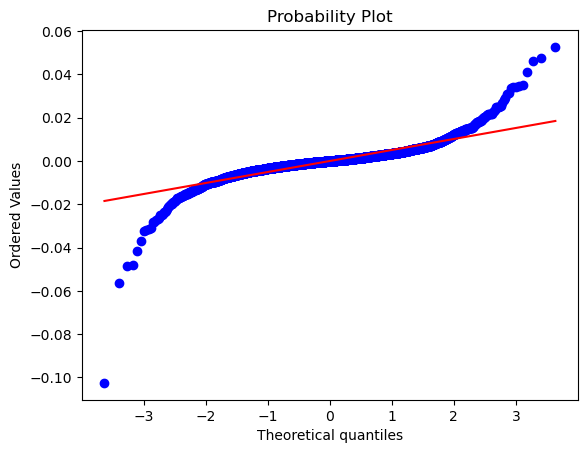

QCOM


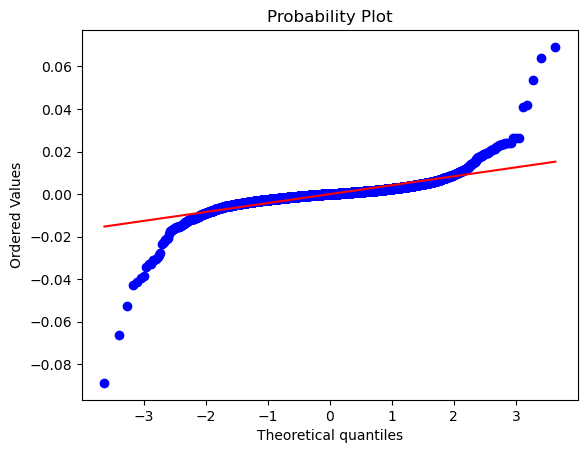

SIRI


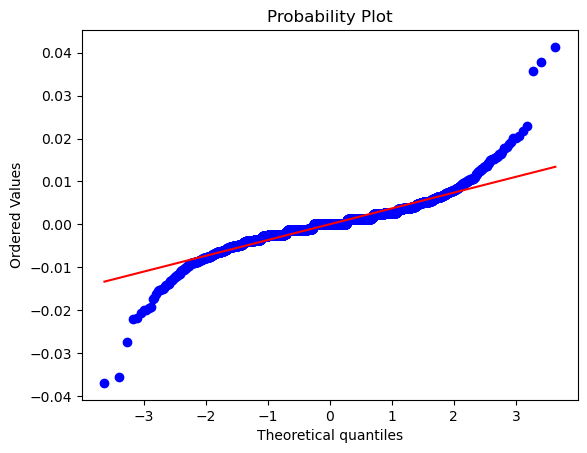

TSLA


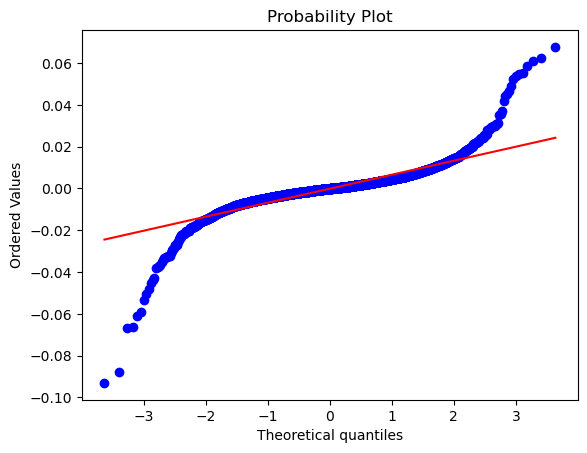

TXN


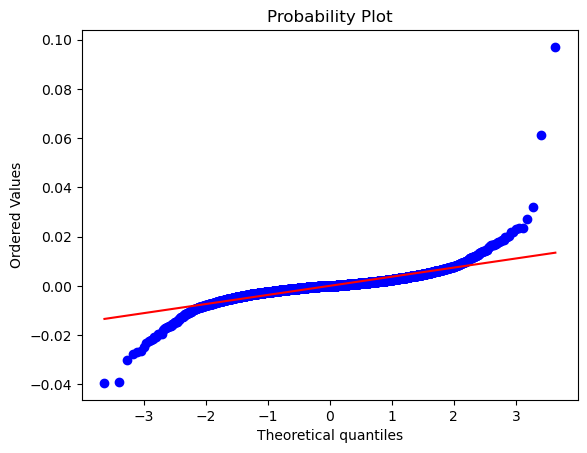

VMW


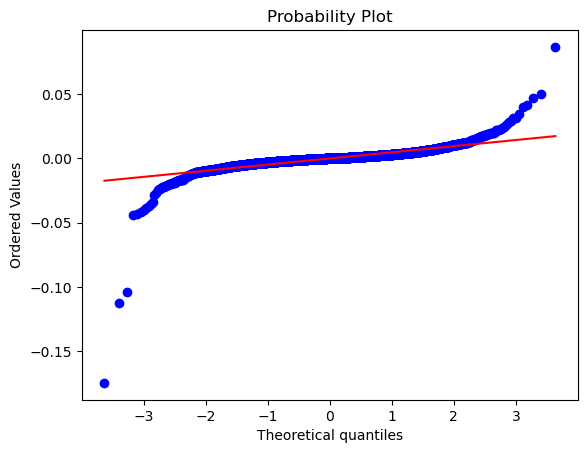

In [7]:

# Iterate over each variable and create a Q-Q plot in each subplot
for i in range(0, len(prices.columns)):
    print(f"{prices.columns[i]}")
    # Extract the data for the current variable
    variable_data = np.array(log_returns.iloc[1:, i])
    
    # Generate the Q-Q plot
    stats.probplot(variable_data, dist='norm', plot=plt)

    # Display the figure
    plt.show()


## 2.4 Box-plots

This type of plot shows the ”five-number summary” of a set of data: minimum, maximum, first and third quartile, and median. The box is drawn from the first quartile to the third one. The line inside the boxes indicates the median, and the horizontal lines outside the boxes indicate the maximum and minimum values. In this case, as the number of outliers is considerable, they are shown as dots and lie outside the ”maximum” and ”minimum” values. It is worth noting that a datapoint is considered an outlier when it is beyond three standard deviations from the mean. The box appear very small as the majority of values are around 0.

**Conclusion:** We can see some assets' returns are more volatile than others (AMD, NFLX as opposed to eg: FISV). However, we see that the median/average is close to 0.

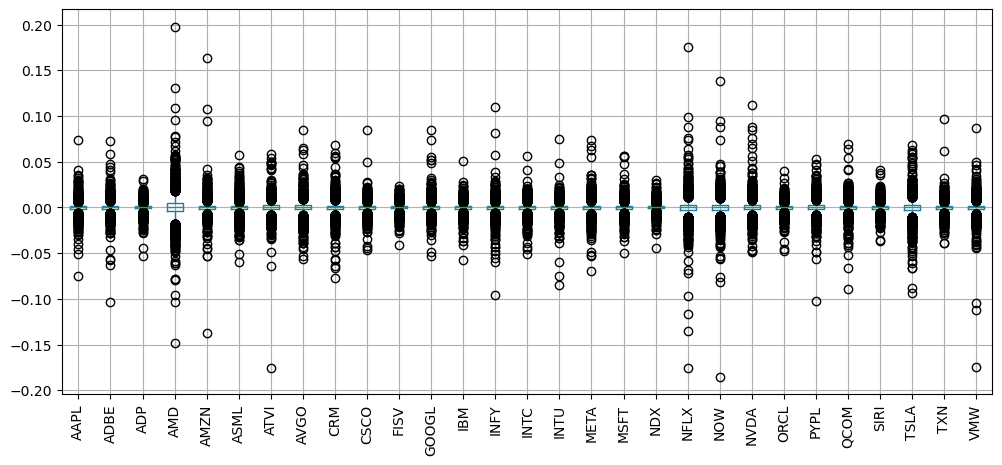

In [8]:
fig = plt.figure(figsize=(12, 5))
boxplot = log_returns.boxplot(rot = 90)
plt.show()

## 2.5 Stationarity of Returns

We want returns to be stationary because it makes it easier to analyse the timeseries, and having the mean, std dev the same over all periods of time makes it easier to predict. Stationary timeseries exhibit more predictable patterns. Models such as ARIMA assume stationarity.

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss, q_stat, acf
from scipy.stats import probplot, moment

### 2.5.1 ADF:

- Stationarity: p-value < 0.05 or test statistic < any Critical Values
- Non-stationarity: p-value > 0.05 AND test statistic > any Critical Values

In [37]:

for i in range(0, len(log_returns.columns)):
    adfuller_stocks = adfuller(log_returns.iloc[1:, i])
    
    if adfuller_stocks[1] > 0.05 or adfuller_stocks[0] > max(np.array([adfuller_stocks[4]['1%'], adfuller_stocks[4]['5%'], adfuller_stocks[4]['10%']])):
        print("Non-Stationary")
        print("")
        print("Number of observations used: ", adfuller_stocks[3])
        print("Used lags: ", adfuller_stocks[2])
        print("ADF test statistic: ", adfuller_stocks[0])
        print("p-value: ", adfuller_stocks[1])
        print("Critical values for the test statistic at: ")
        print("- 1%: ", adfuller_stocks[4]['1%'])
        print("- 5%: ", adfuller_stocks[4]['5%'])
        print("- 10%: ", adfuller_stocks[4]['10%'])
        print("")


### 2.5.2 KPSS
- Stationarity: p-value > 0.05
- Non-stationarity: p-value < 0.05 or test statistic > any Critical Values

In [11]:

for i in range(0, len(log_returns.columns)):
    kpsss = kpss(log_returns.iloc[1:, i])

    print("Used lags: ", kpsss[2])
    print("KPSS test statistic: ", kpsss[0])
    print("p-value: ", kpsss[1])
    print("Critical values for the test statistic at: ")
    print("- 1%: ", kpsss[3]['1%'])
    print("- 5%: ", kpsss[3]['5%'])
    print("- 10%: ", kpsss[3]['10%'])
    print("")


Used lags:  11
KPSS test statistic:  0.15868608307374077
p-value:  0.1
Critical values for the test statistic at: 
- 1%:  0.739
- 5%:  0.463
- 10%:  0.347

Used lags:  9
KPSS test statistic:  0.03338389316779846
p-value:  0.1
Critical values for the test statistic at: 
- 1%:  0.739
- 5%:  0.463
- 10%:  0.347

Used lags:  10
KPSS test statistic:  0.03546274307511142
p-value:  0.1
Critical values for the test statistic at: 
- 1%:  0.739
- 5%:  0.463
- 10%:  0.347

Used lags:  5
KPSS test statistic:  0.252586618338248
p-value:  0.1
Critical values for the test statistic at: 
- 1%:  0.739
- 5%:  0.463
- 10%:  0.347

Used lags:  6
KPSS test statistic:  0.14079141879450024
p-value:  0.1
Critical values for the test statistic at: 
- 1%:  0.739
- 5%:  0.463
- 10%:  0.347

Used lags:  7
KPSS test statistic:  0.07871611106155736
p-value:  0.1
Critical values for the test statistic at: 
- 1%:  0.739
- 5%:  0.463
- 10%:  0.347

Used lags:  2
KPSS test statistic:  0.23444384232057433
p-value:  0.1


C:\Users\flemo\anaconda3\envs\symbiotica-fund\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\flemo\anaconda3\envs\symbiotica-fund\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\flemo\anaconda3\envs\symbiotica-fund\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\flemo\anaconda3\envs\symbiotica-fund\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside 

**Conclusion**: Log-returns are stationary - eg:properties (mean ,stad dev.) do not change over time. This does not apply for prices, for example.

## 2.6 Correlation of assets

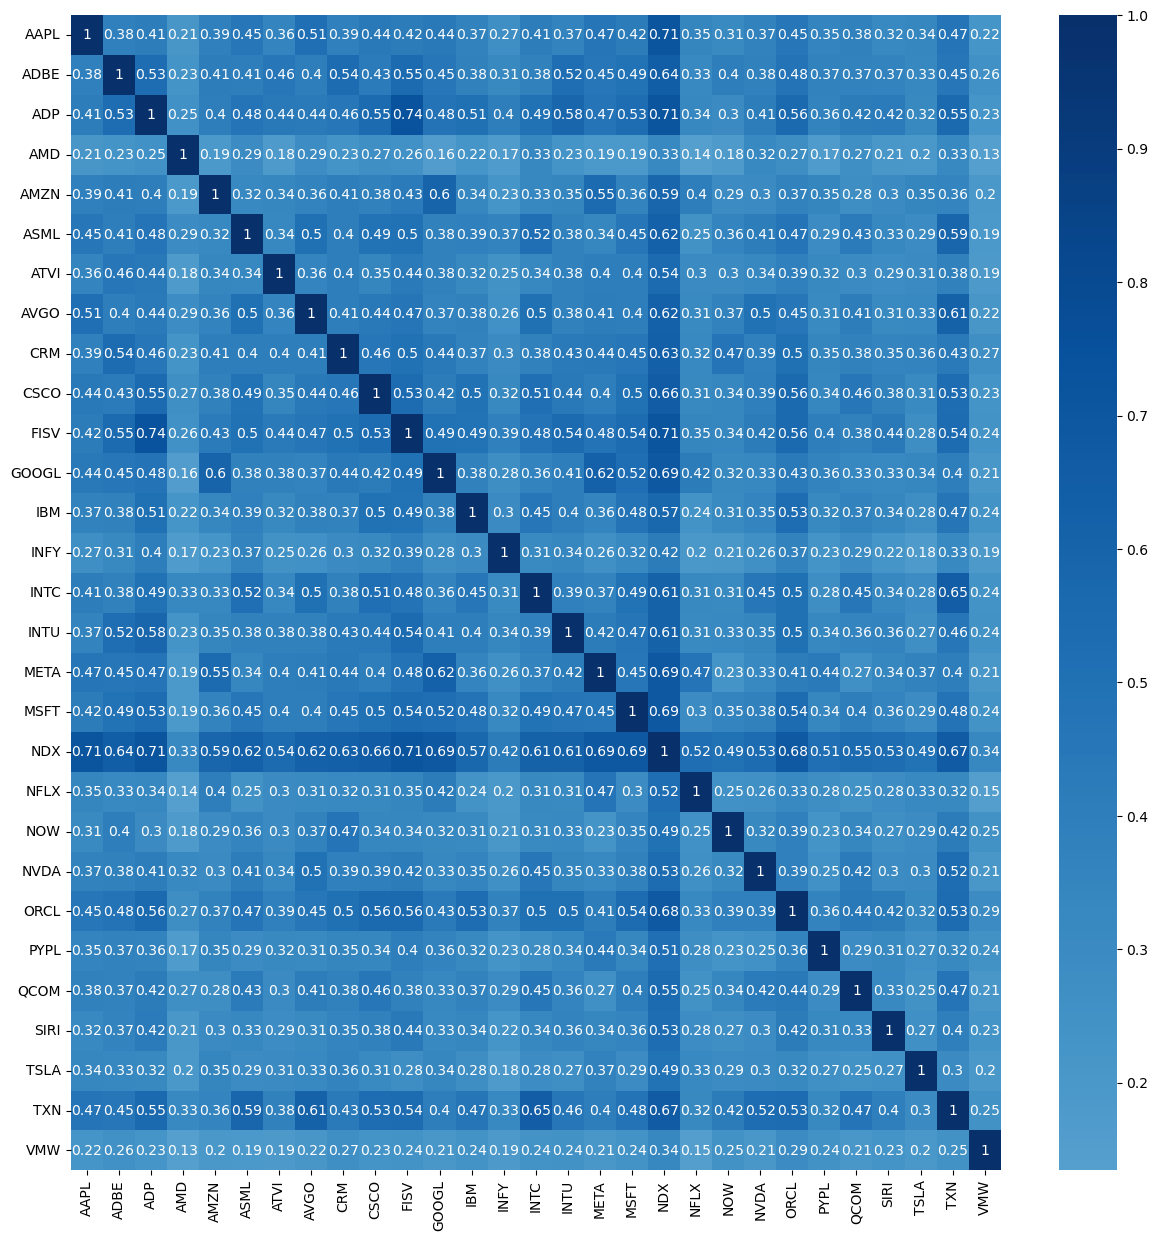

In [12]:
fig = plt.figure(figsize=(15, 15))
sns.heatmap(log_returns.corr('pearson'), annot=True, center=0, cmap='Blues')
plt.show()

In [13]:
#useless, as it is prices correlation
#fig = plt.figure(figsize=(15, 15))
#sns.heatmap(prices.corr('pearson'), annot=True, center=0, cmap='Blues')
#plt.show()

## 2.7 Autocorrelation

Autocorrelation analysis is essential to measure how much of an impact do past prices have on a security on its future prices and to check for randomnes.

**ACF**: This test spots (or not) the "q" in the MA(q). The procedure is:

1. Estimate the sample mean:

$$
\bar{y} = \frac{1}{T}\sum_{t=1}^{n}y_t
$$

2. Calculate the sample autocorrelation:

$$
\rho_i = \frac{\sum_{t=i+1}^{T}(y_t - \bar{y})(y_{t-j} - \bar{y})}{\sum_{t=1}^{t}(y_t - \bar{y})^2}
$$

3. (OPTIONAL) Estimate variance in order to compute confidence intervals


**PACF**: This test spots (or not) the "p" in the AR(p).

It is similar to ACF but in PACF we seek to find the correlation between:

Variable 1: Amount of variance in y_t that is not explained by y_{i-1} and

Variable 2: Amount of variance in y_{t-2} that is not explained by the previous value --> y_{t-1}

(this is the case of PACF of y_t with y_{t-2})

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ AAPL ]
                        ------------------------------------------------------------------



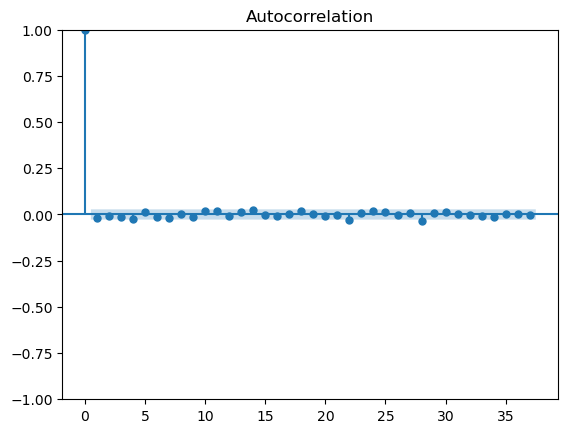

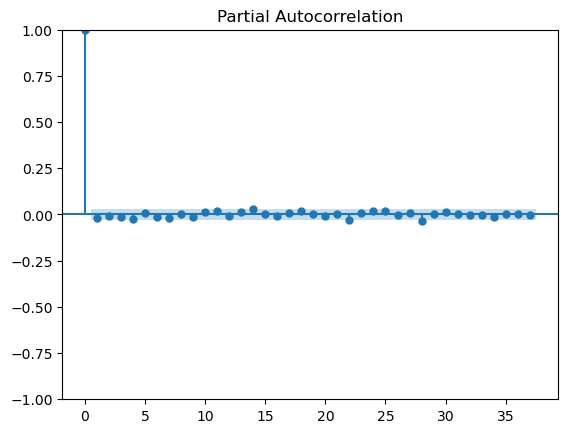


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ ADBE ]
                        ------------------------------------------------------------------



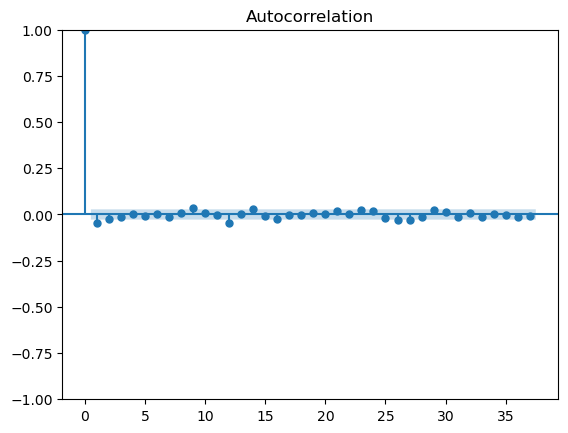

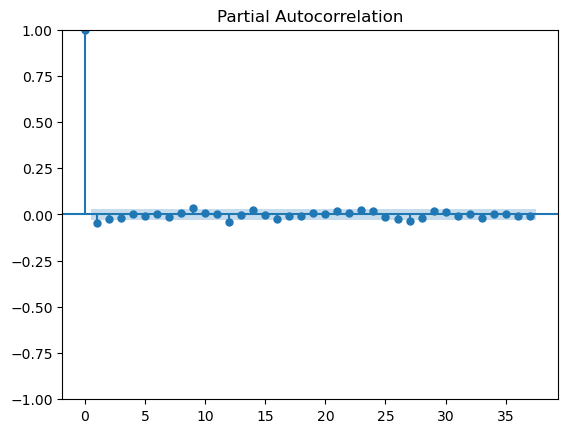


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ ADP ]
                        ------------------------------------------------------------------



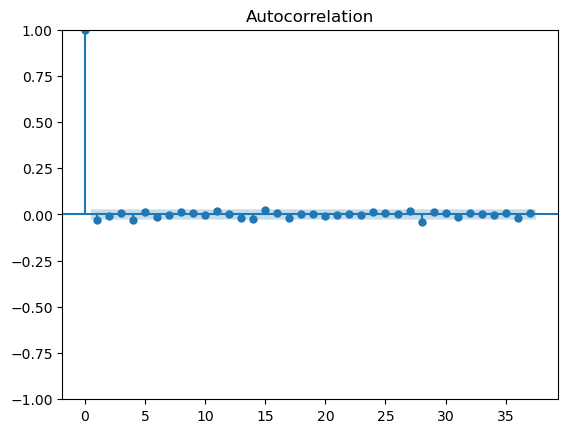

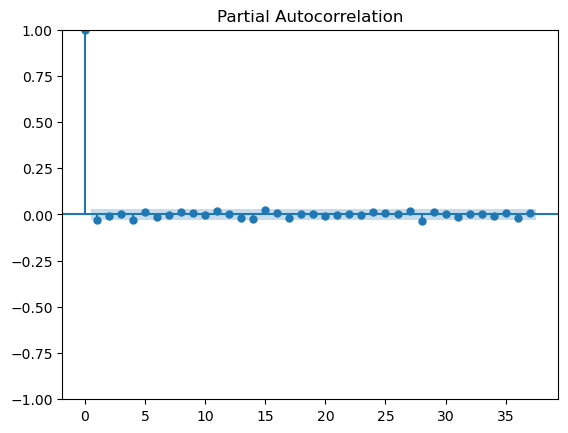


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ AMD ]
                        ------------------------------------------------------------------



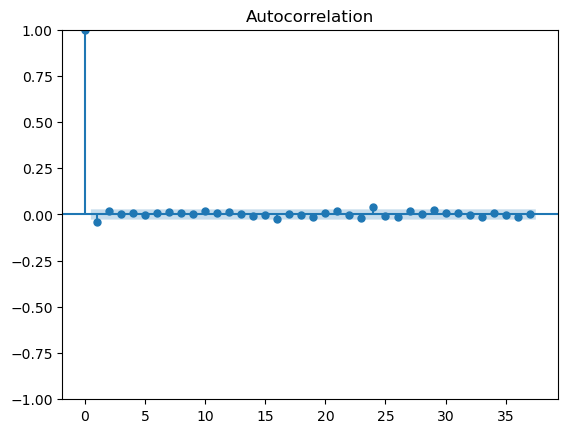

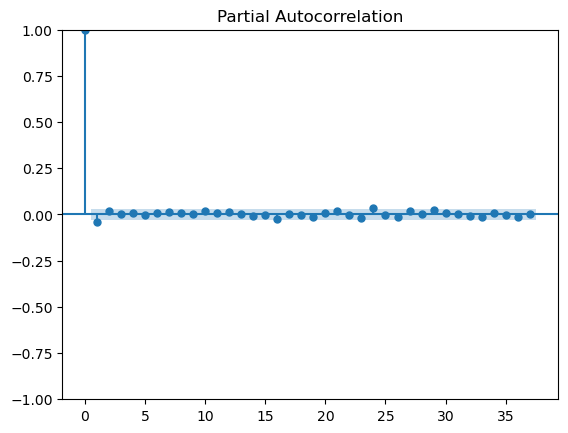


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ AMZN ]
                        ------------------------------------------------------------------



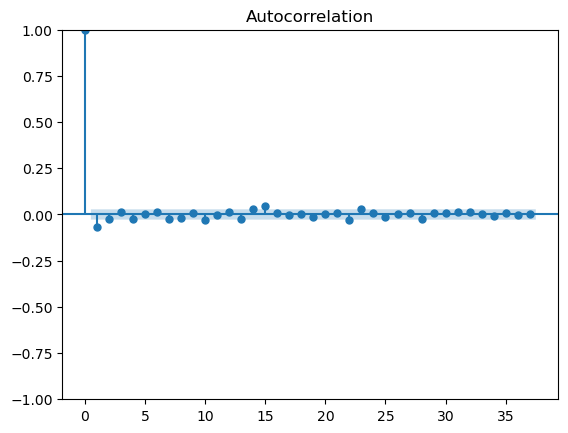

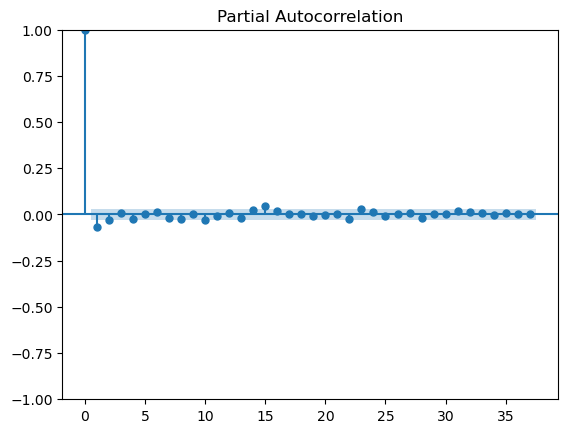


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ ASML ]
                        ------------------------------------------------------------------



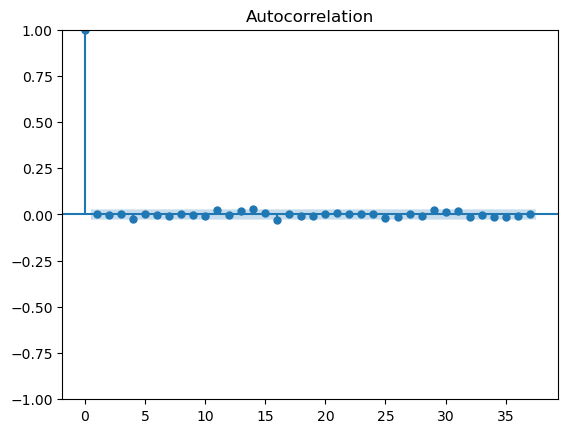

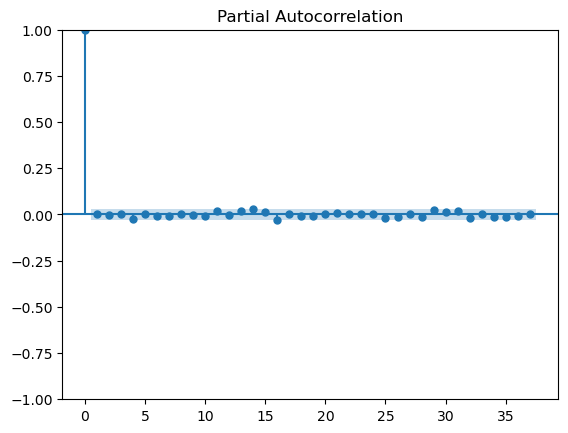


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ ATVI ]
                        ------------------------------------------------------------------



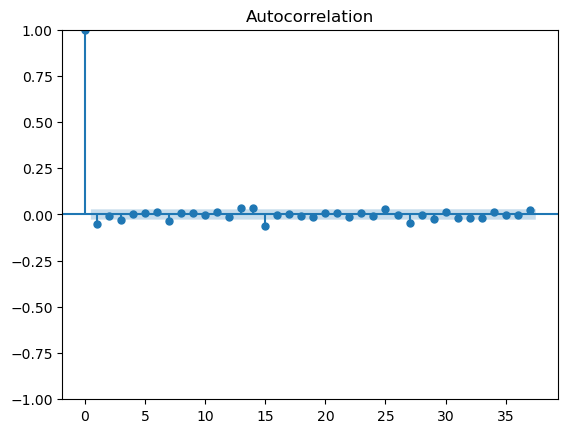

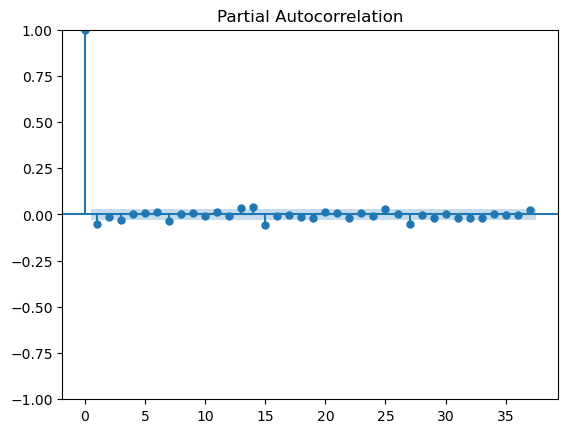


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ AVGO ]
                        ------------------------------------------------------------------



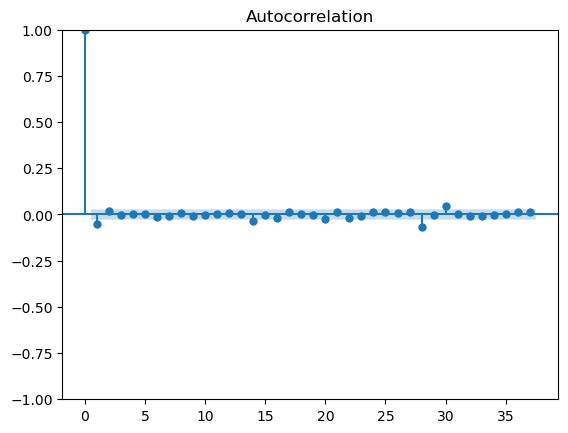

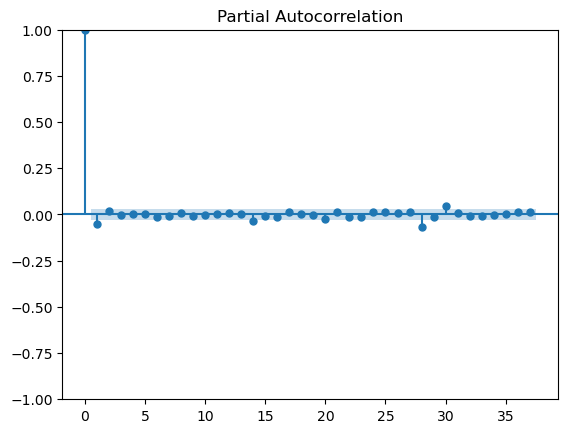


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ CRM ]
                        ------------------------------------------------------------------



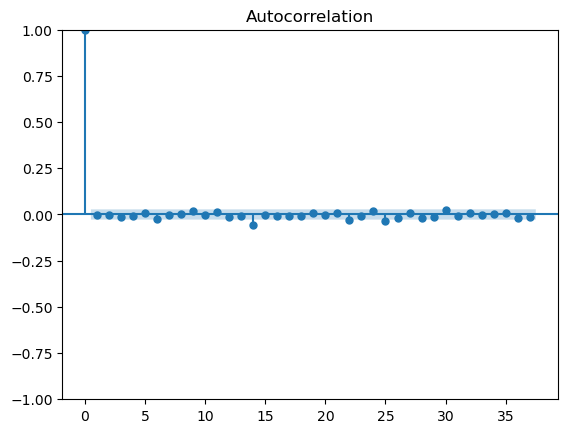

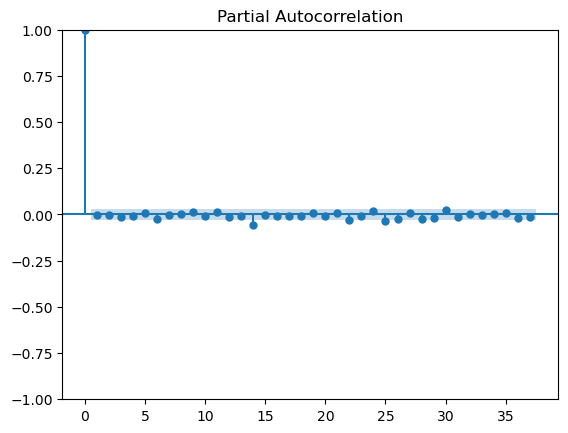


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ CSCO ]
                        ------------------------------------------------------------------



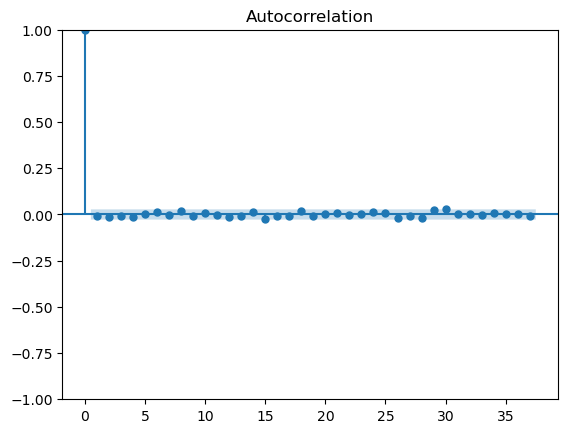

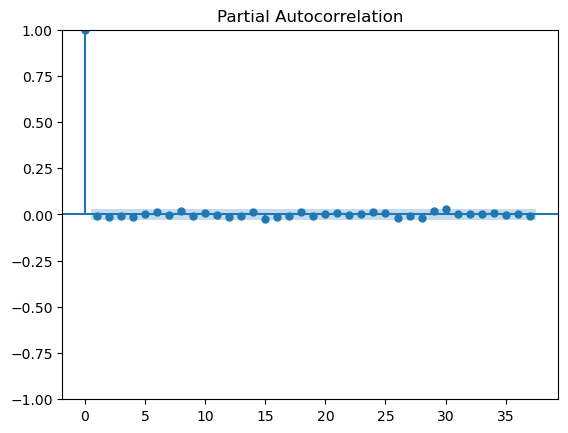


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ FISV ]
                        ------------------------------------------------------------------



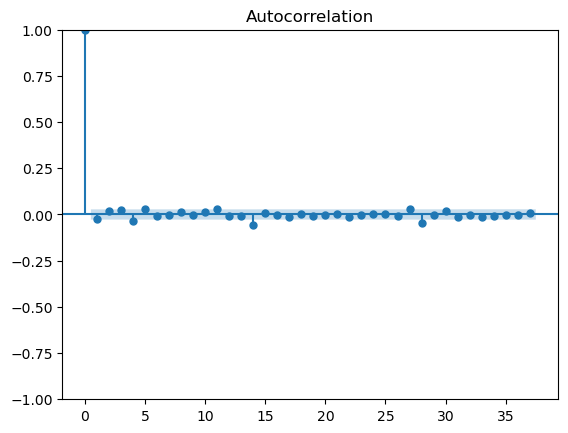

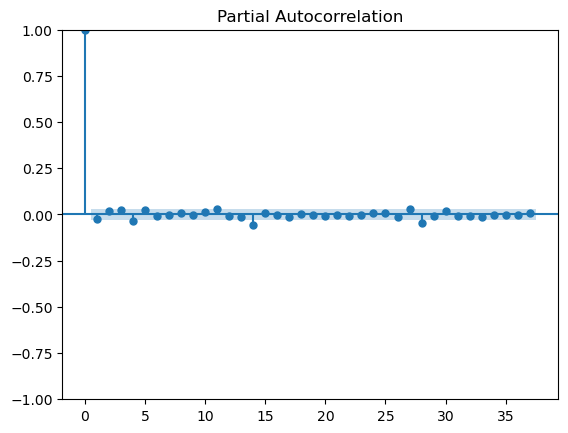


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ GOOGL ]
                        ------------------------------------------------------------------



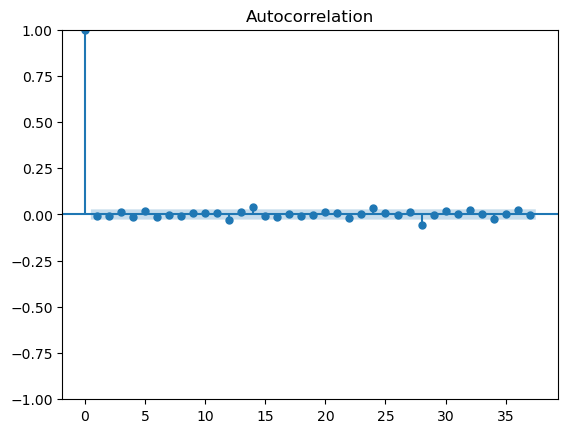

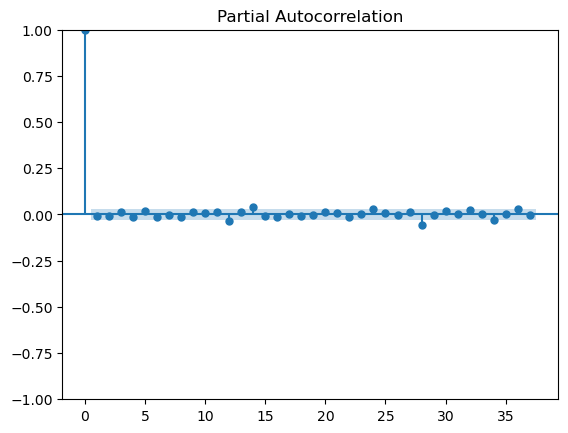


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ IBM ]
                        ------------------------------------------------------------------



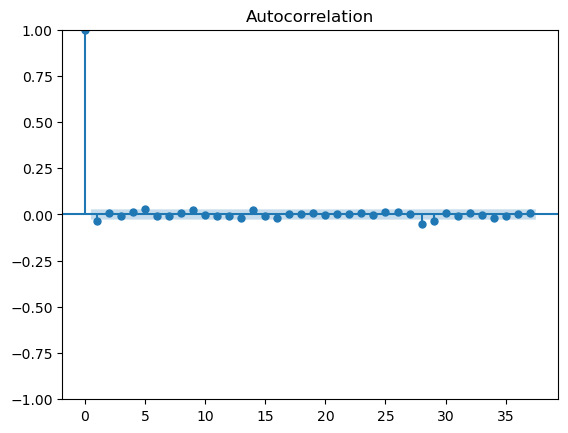

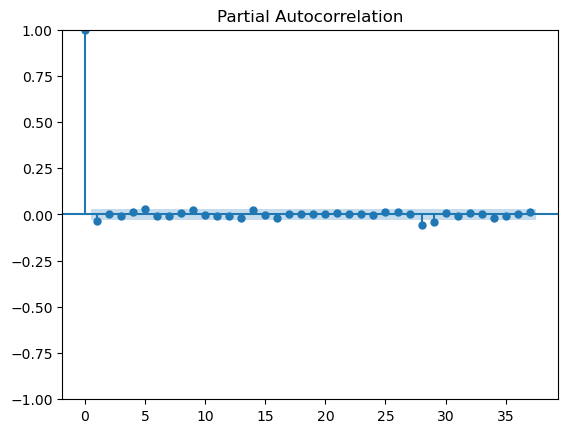


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ INFY ]
                        ------------------------------------------------------------------



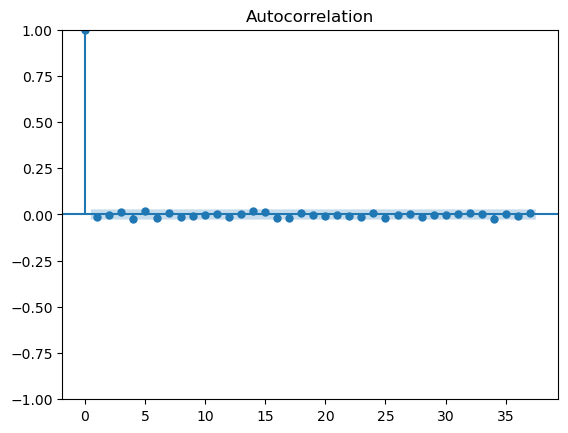

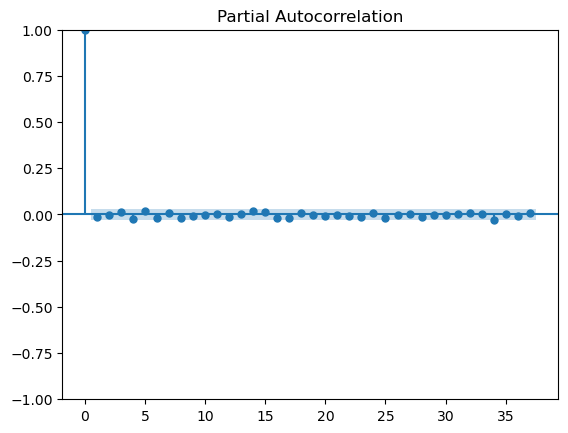


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ INTC ]
                        ------------------------------------------------------------------



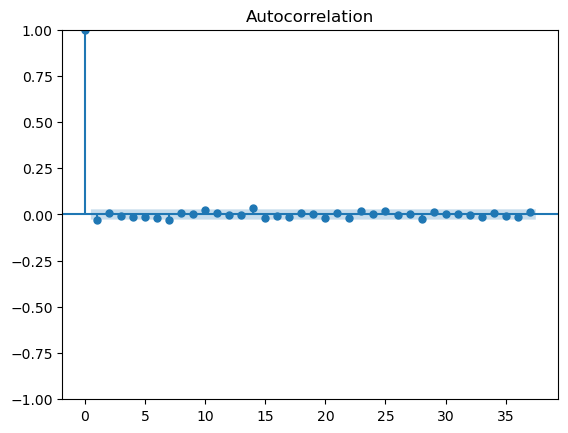

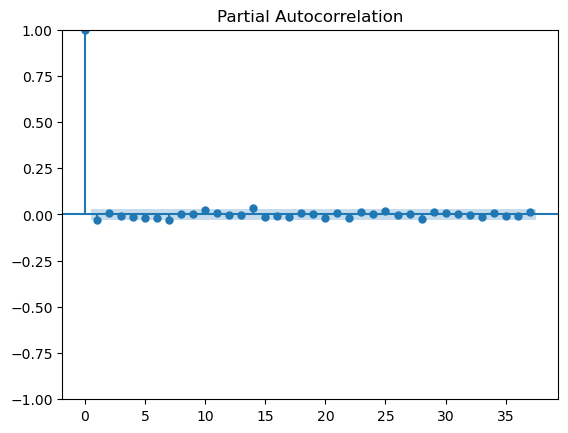


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ INTU ]
                        ------------------------------------------------------------------



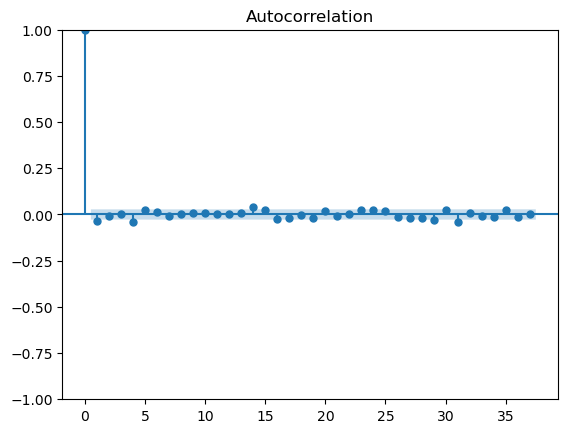

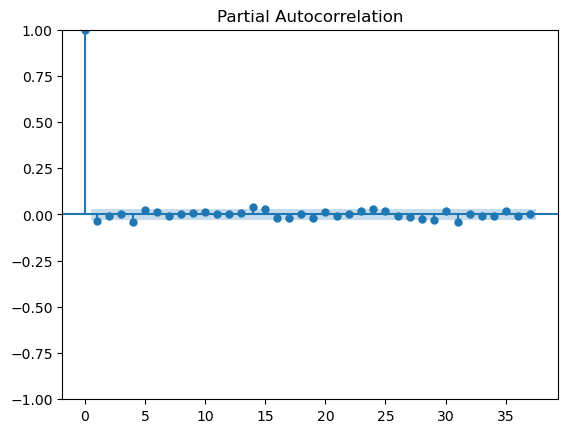


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ META ]
                        ------------------------------------------------------------------



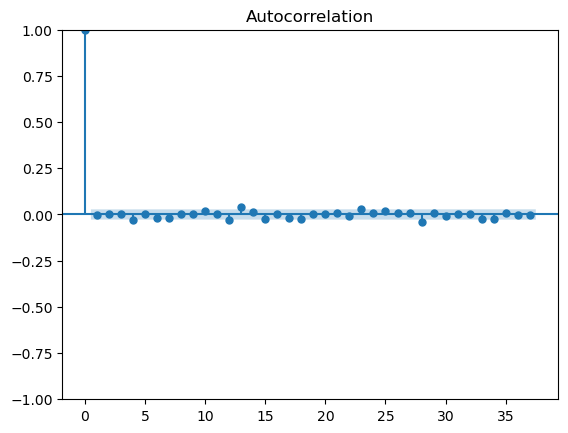

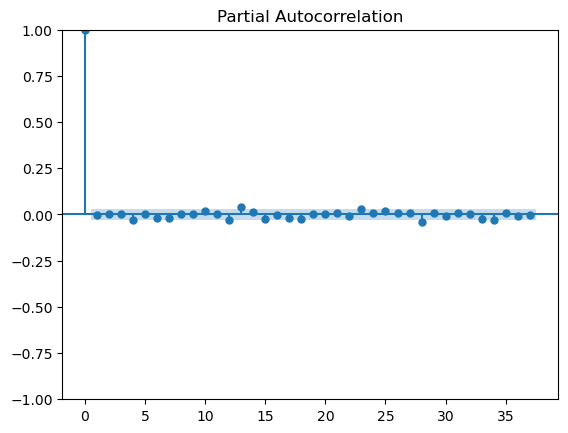


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ MSFT ]
                        ------------------------------------------------------------------



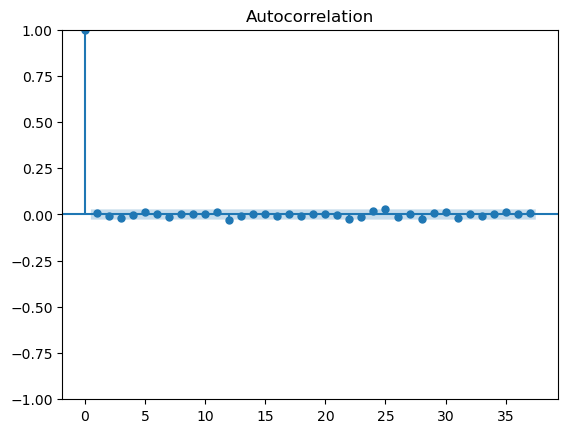

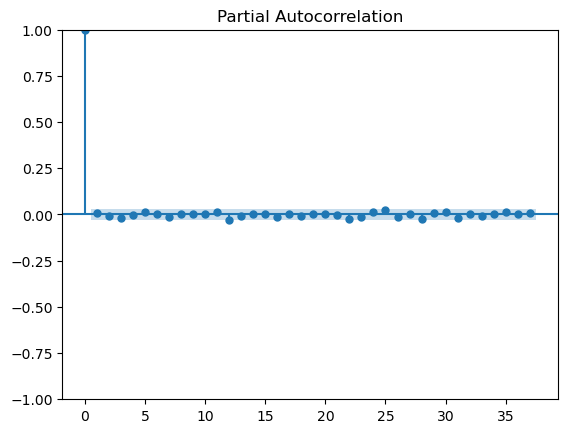


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ NDX ]
                        ------------------------------------------------------------------



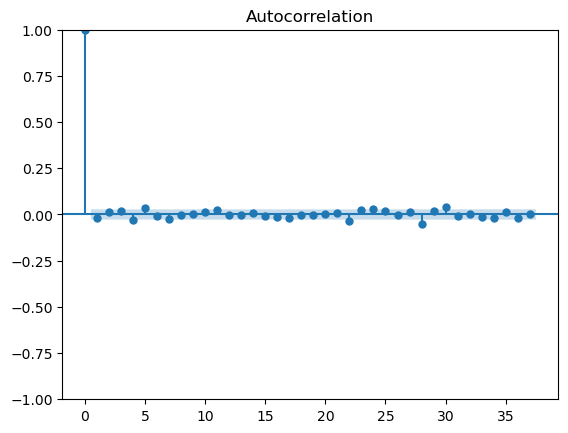

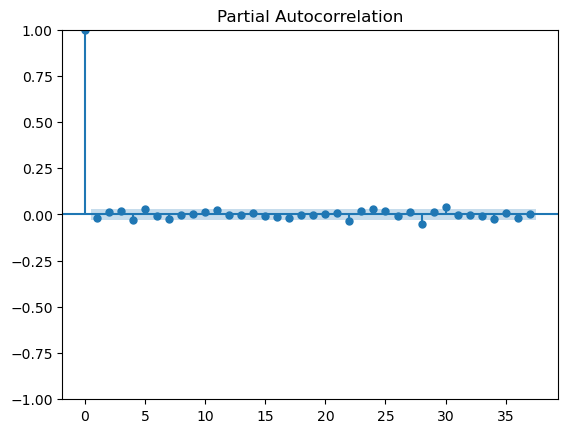


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ NFLX ]
                        ------------------------------------------------------------------



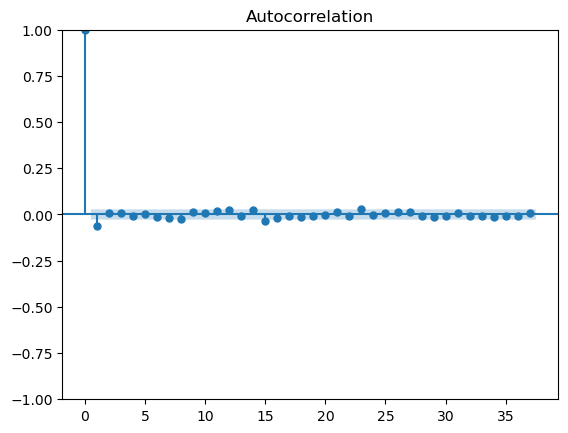

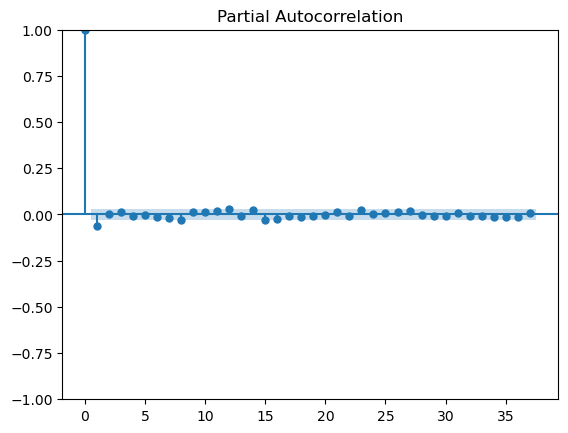


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ NOW ]
                        ------------------------------------------------------------------



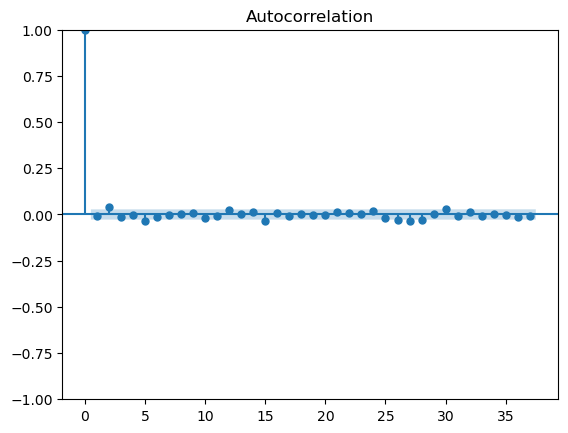

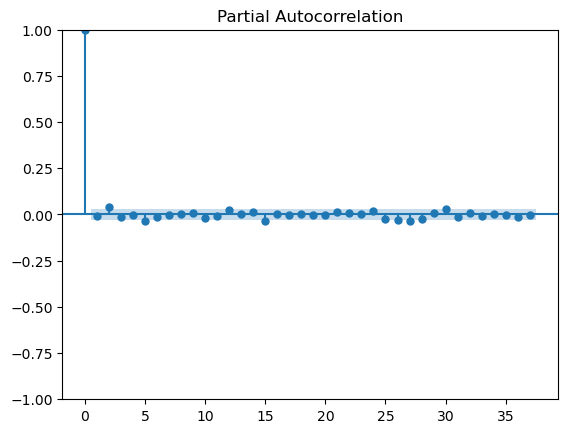


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ NVDA ]
                        ------------------------------------------------------------------



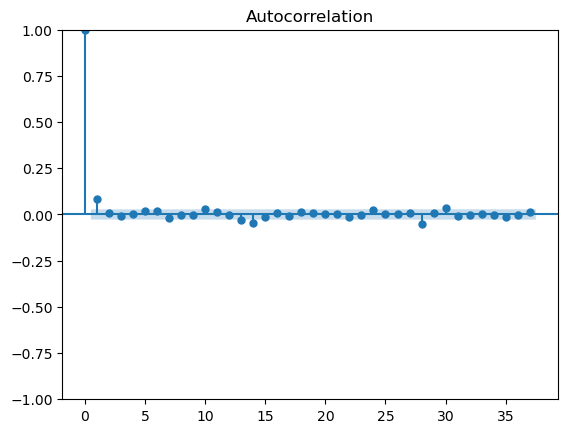

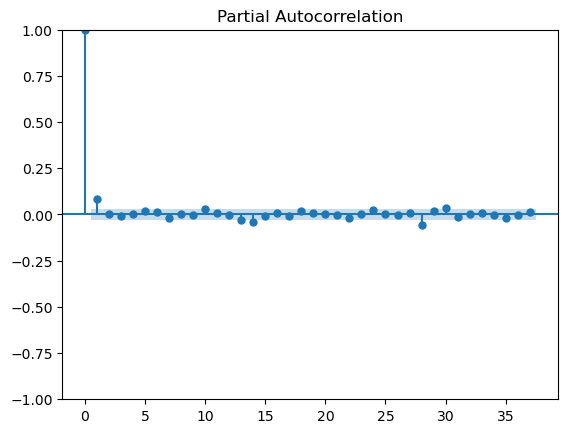


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ ORCL ]
                        ------------------------------------------------------------------



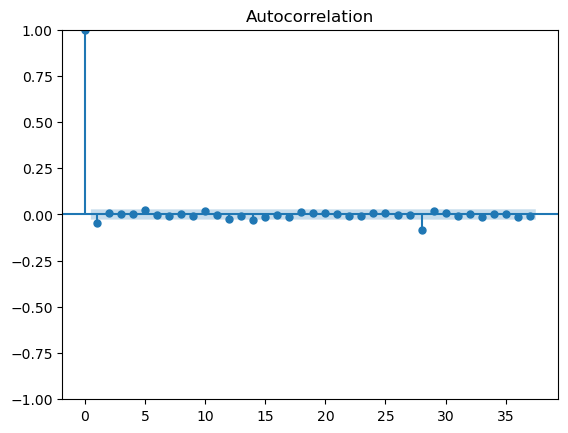

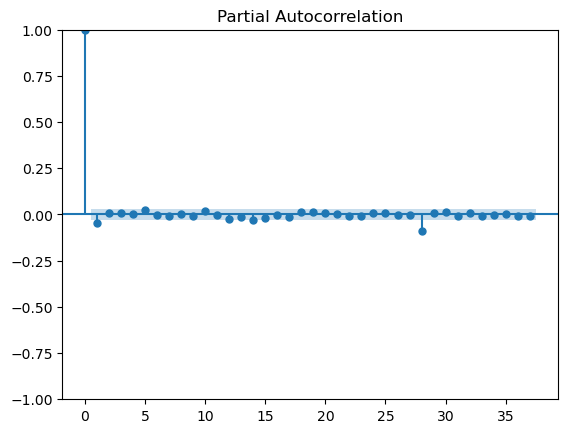


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ PYPL ]
                        ------------------------------------------------------------------



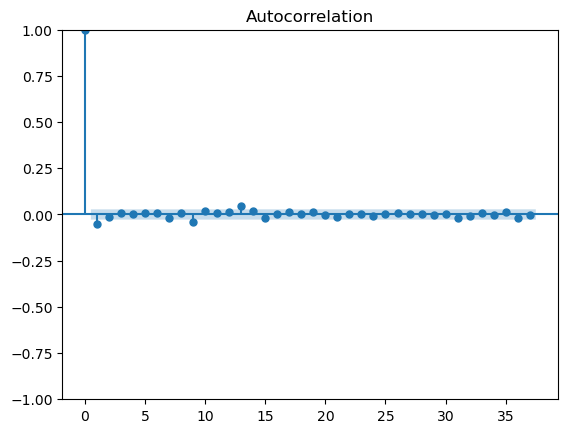

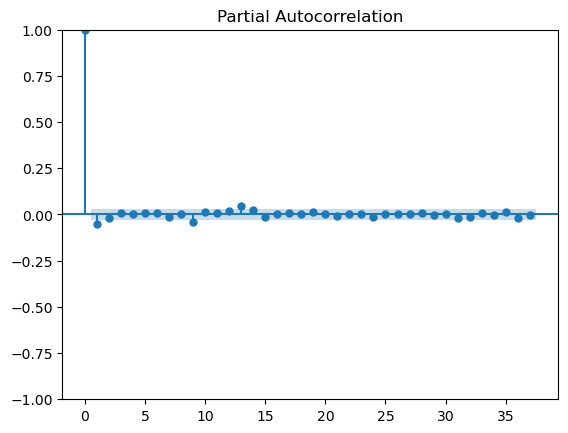


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ QCOM ]
                        ------------------------------------------------------------------



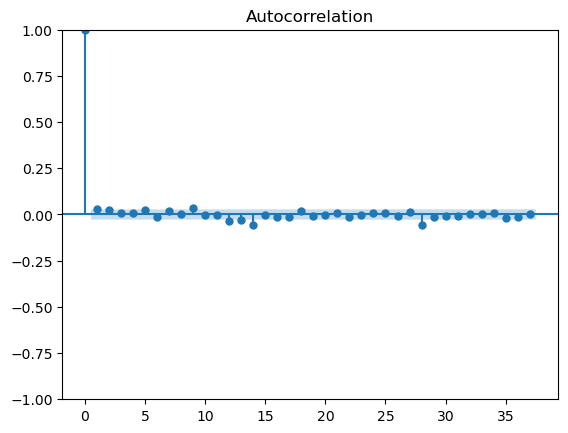

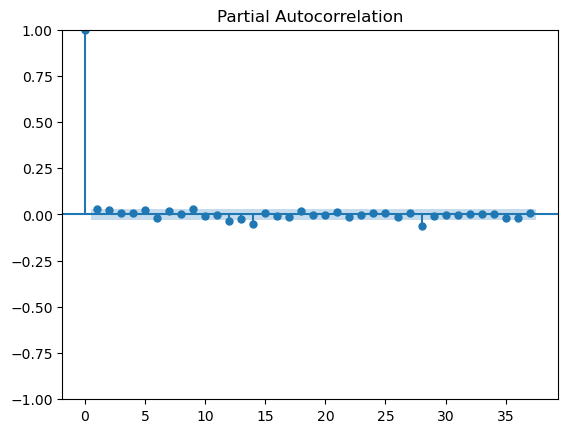


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ SIRI ]
                        ------------------------------------------------------------------



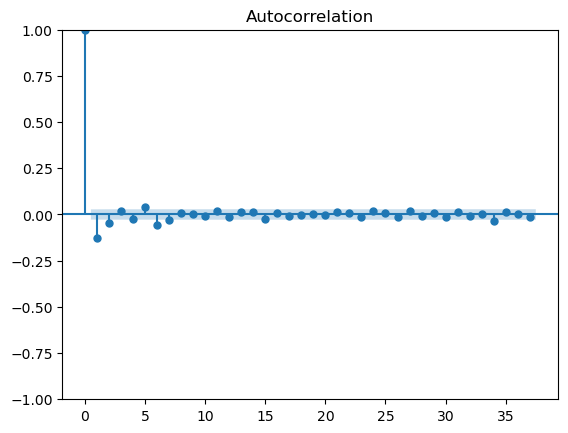

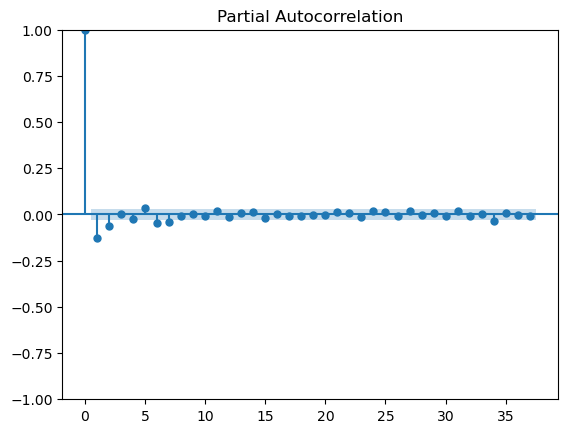


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ TSLA ]
                        ------------------------------------------------------------------



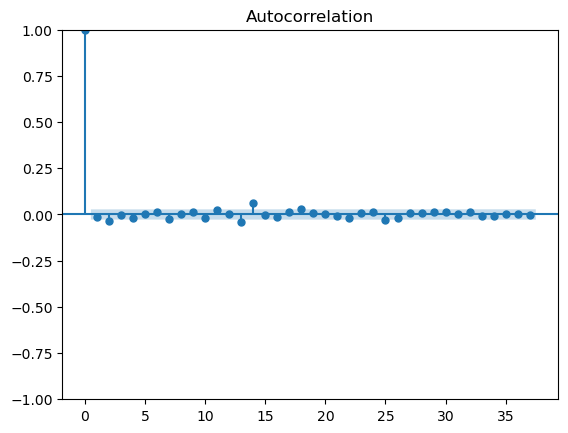

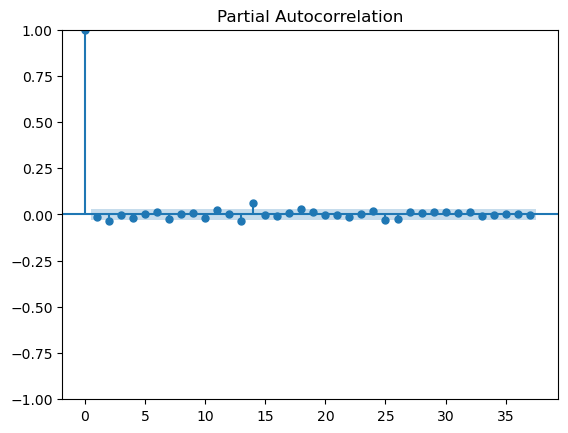


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ TXN ]
                        ------------------------------------------------------------------



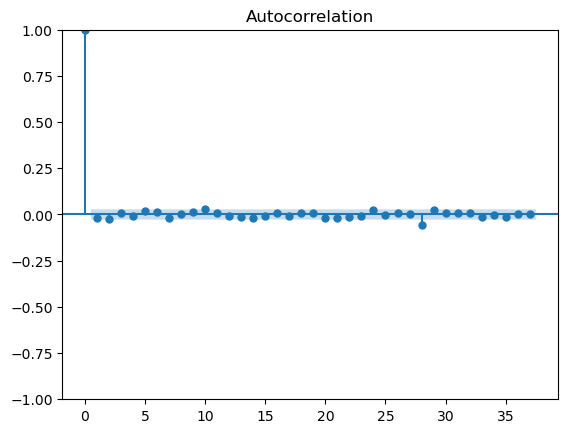

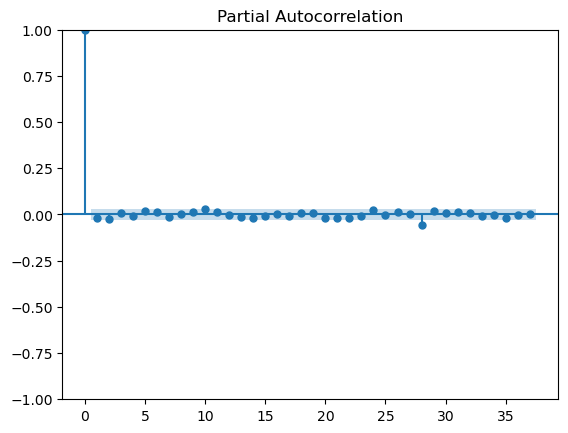


                        ------------------------------------------------------------------
                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [ VMW ]
                        ------------------------------------------------------------------



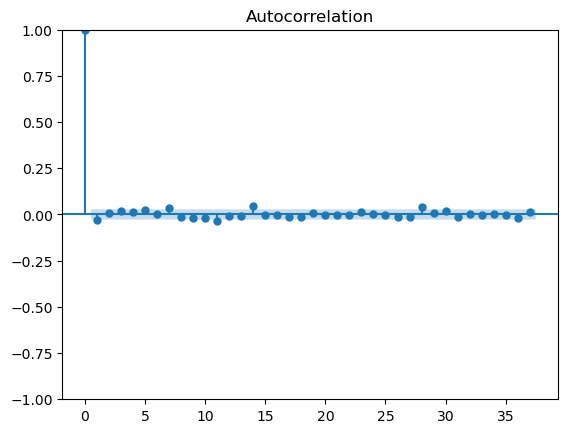

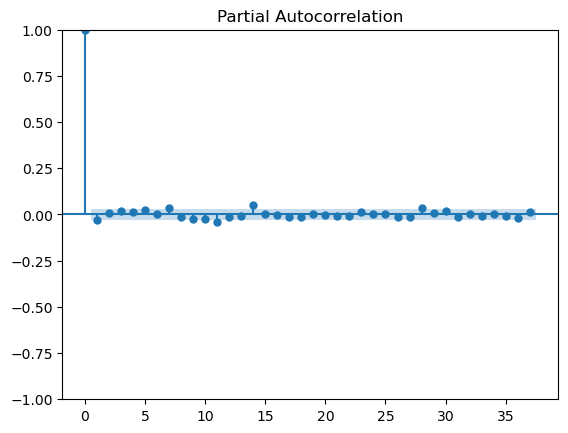

In [15]:

for i in range(0, len(log_returns.columns)):
    
    list_of_cols = log_returns.columns
    ret = log_returns.iloc[1:,i]

    print("")
    print("                        ------------------------------------------------------------------")
    print("                        AUTOCORRELATION/PARTIAL AUTOCORRELATION FOR: [", list_of_cols[i], "]")
    print("                        ------------------------------------------------------------------")
    print("")
    plot_acf(ret)
    plot_pacf(ret, method = 'ywm')
    plt.show()


# Trading Strategies

## 1. Technical Analysis based

### 1.1 Moving Averages Crossover

**Moving Averages Crossover Strategy**

The MA crossover strategy calculates a long-term MA and a short-term MA. The two indicators have different rates of directions, and when they cross (crossover points), it indicates a buy/sell signal. The intuition behind this strategy can be explained in terms of momentum.  Basically, the principle of momentum states that a price that is moving up (or down) during period t is likely to continue to move up (or down) in period t+1 unless evidence exists to the contrary.  When the short-term MA moves above the long-term MA, this provides a lagged indicator that the price is moving upward relative to the historical price, which indicates a long position. In the contrary, it indicates a short position.

$$
\text{SMA} = \frac{{\sum_{i=1}^{n} P_i}}{{n}}
$$

Where:

$$ SMA: \text{Simple Moving Average}$$
$$ P_i: \text{Price of stock at time i}$$
$$ n: \text{Number of periods considered for the average}$$



In [16]:
%reload_ext autoreload
%autoreload 2

from strategies_functions import (calculate_moving_averages,
                                generate_signal_moving_averages_crossover,
                                visualize_moving_averages_crossover,
                                 calculate_returns)

#### 1.1.1 Parameters

In [17]:
# Define the parameters
short_window = 10
long_window = 60
initial_investment = 100_000_000

#### 1.1.2 Generate signal

In [18]:
# Calculate the moving averages
short_ma, long_ma = calculate_moving_averages(prices, short_window, long_window)

# Generate the buy and sell signals
signals_ma = generate_signal_moving_averages_crossover(prices, short_ma, long_ma)

#### 1.1.3 Visualize strategy on single stock

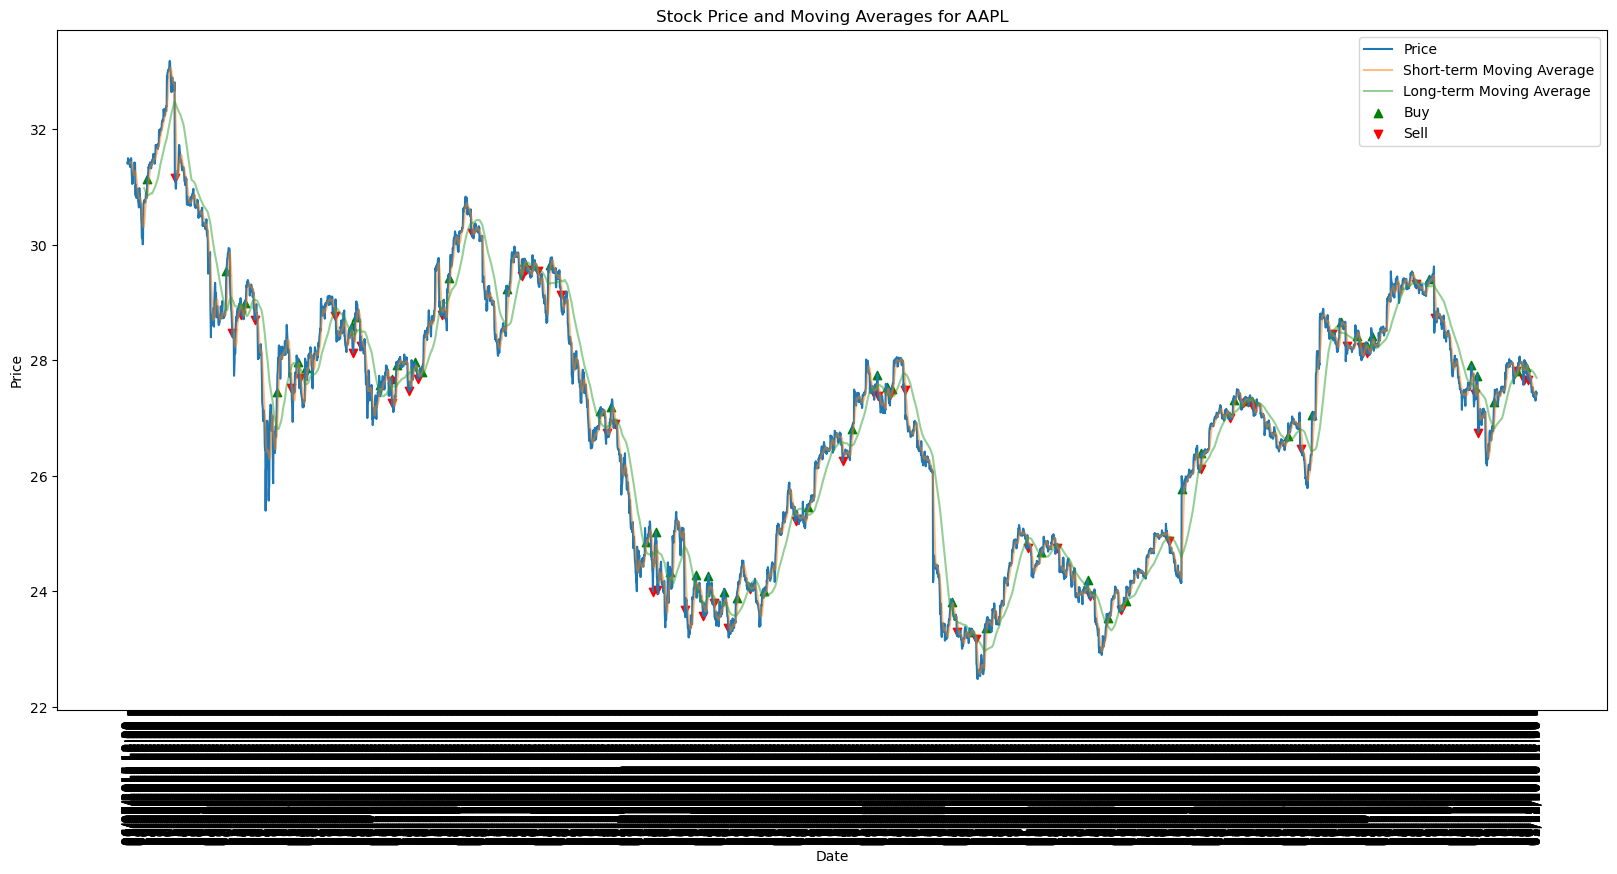

In [19]:
# stock to visualize
stock = 'AAPL'
visualize_moving_averages_crossover(prices, short_ma, long_ma, signals_ma, stock)

#### 1.1.4 Calculate cummulative returns

In [20]:
returns_strategy_ma = calculate_returns(log_returns, signals_ma)
returns_strategy_ma = returns_strategy_ma.fillna(0)

# single number for each stock
cum_returns_percent = 100 * ((prices.iloc[-1, :] - prices.iloc[0, :]) / prices.iloc[0, :])# from stock data

treturns_stocks = 100 * (np.exp(returns_strategy_ma.cumsum()) - 1)
returns_stocks = 100 * (np.exp(log_returns.cumsum()) - 1) # series of buy n hold cummulative returns

for stock in returns_stocks.columns:
    
    print(f"Trading strategy Return on {stock}: {round(treturns_stocks[stock].iloc[-1], 2)} %.")
    print(f"Buy and Hold strategy Return on {stock}: {round(returns_stocks[stock].iloc[-1], 2)} %.")
    print("")

sharpe_ratio = (returns_strategy_ma.mean(axis = 1).mean() / returns_strategy_ma.mean(axis = 1).std()) * np.sqrt(255 * 14)

print(f"Total Return of Buy and Hold: {returns_stocks.iloc[-1, :].mean()}")
print(f"Total Return of MA Strategy: {treturns_stocks.iloc[-1, :].mean()}")
print(f"Annual Sharpe Ratio MA Strategy: {sharpe_ratio}")

Trading strategy Return on AAPL: 22.64 %.
Buy and Hold strategy Return on AAPL: -12.68 %.

Trading strategy Return on ADBE: 5.92 %.
Buy and Hold strategy Return on ADBE: 23.5 %.

Trading strategy Return on ADP: -9.88 %.
Buy and Hold strategy Return on ADP: 18.65 %.

Trading strategy Return on AMD: 310.27 %.
Buy and Hold strategy Return on AMD: 241.47 %.

Trading strategy Return on AMZN: 203.04 %.
Buy and Hold strategy Return on AMZN: 69.65 %.

Trading strategy Return on ASML: 43.51 %.
Buy and Hold strategy Return on ASML: -2.3 %.

Trading strategy Return on ATVI: -3.08 %.
Buy and Hold strategy Return on ATVI: 45.42 %.

Trading strategy Return on AVGO: 75.68 %.
Buy and Hold strategy Return on AVGO: 19.6 %.

Trading strategy Return on CRM: -31.53 %.
Buy and Hold strategy Return on CRM: -0.64 %.

Trading strategy Return on CSCO: 39.14 %.
Buy and Hold strategy Return on CSCO: 8.69 %.

Trading strategy Return on FISV: 13.85 %.
Buy and Hold strategy Return on FISV: 24.15 %.

Trading strategy

#### 1.1.5 Visualize Market vs. Strategy returns

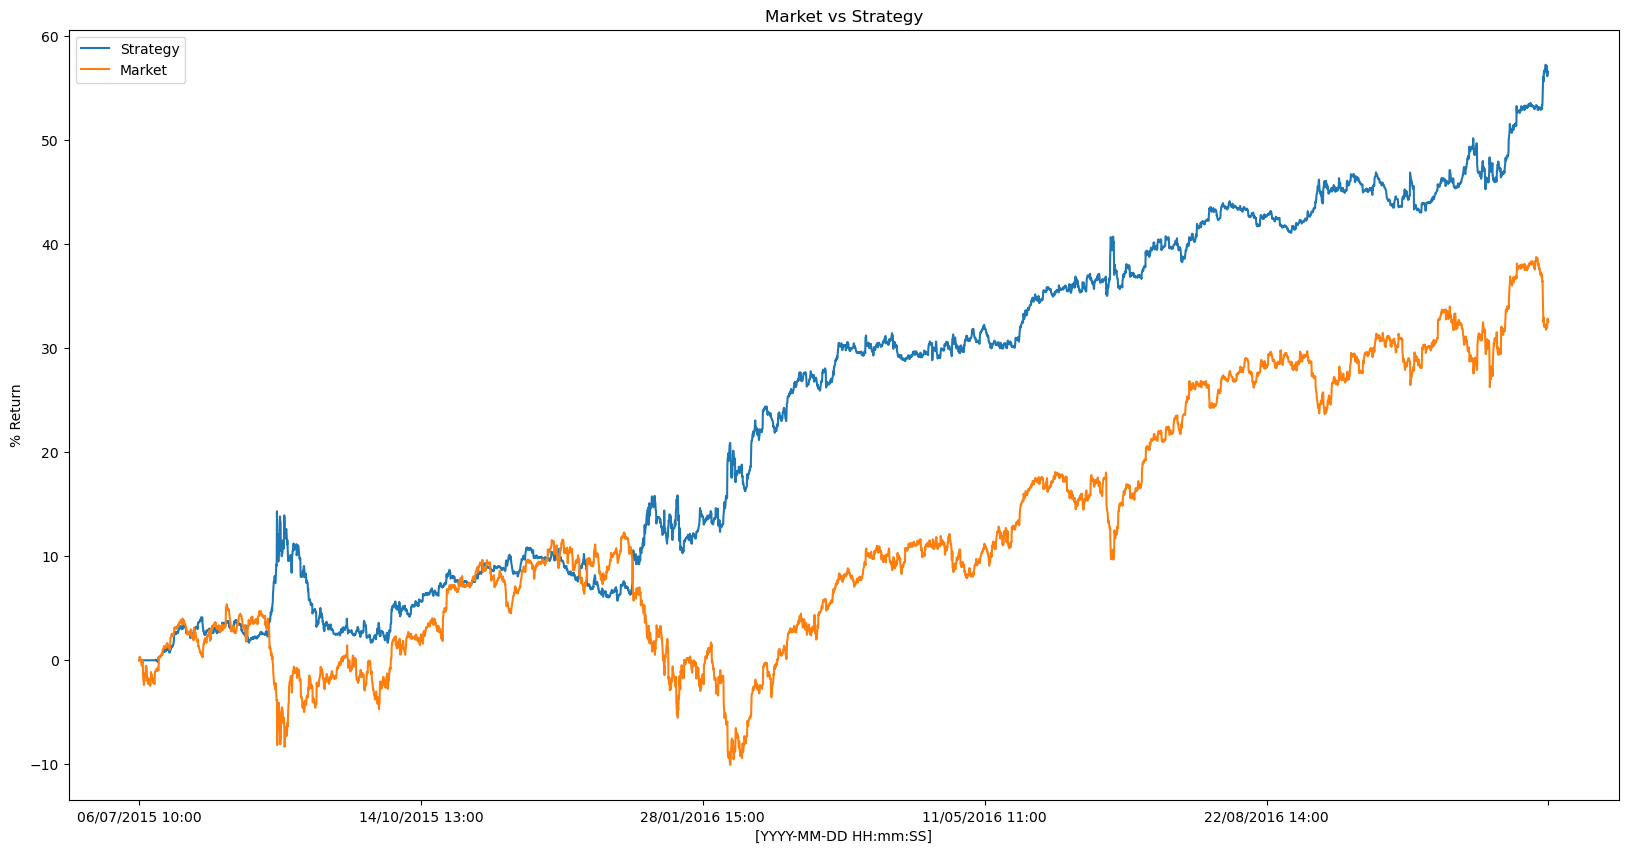

In [21]:
treturns_stocks.mean(axis = 1).plot(figsize = (20, 10), label = 'Strategy')
returns_stocks.mean(axis = 1).plot(label = 'Market')
plt.title('Market vs Strategy')
plt.ylabel('% Return')
plt.legend(loc = 'upper left')
# Display the plot
plt.show()

## 2. Regression based strategy

**Why?**

I saw that there is no autocorrelation, true. But I saw that there was strong correlation between the assets. Maybe it is worth checking if the last n-lags of a combination of stocks can predict the future outcome of a stock.

Eg: If AAPL, META, AMZN and GOOGL have been rallying for the past 10hrs, most probably the other US tech stocks will follow in the future...

### 2.1 Vector AutoRegressive strategy

**Vector Autoregressive (VAR) Model:**

The Vector Autoregressive (VAR) model is a multivariate time series model that describes the relationship between multiple variables over time. It is widely used in econometrics and finance for analyzing and forecasting economic and financial time series data.

A 3-dimensional (indicating the number of variables *y*) VAR model of order *2* (indicating the number of lagged values in each equation), denoted as *VAR(2)* can be written as:


$$
\begin{align*}
y_{1, t} &= \alpha_1 + \beta_{11,1} y_{1, t-1} + \beta_{12,1} y_{2, t-1} + \beta_{13,1} y_{3, t-1} + \beta_{11,2} y_{1, t-2}+ \beta_{12,2} y_{2, t-2} + \beta_{13,2} y_{3, t-2} \varepsilon_{1, t} \\
y_{2, t} &= \alpha_2 + \beta_{21,1} y_{1, t-1} + \beta_{22,1} y_{2, t-1} + \beta_{23,1} y_{3, t-1} + \beta_{21,2} y_{1, t-2}+ \beta_{22,2} y_{2, t-2} + \beta_{23,2} y_{3, t-2} \varepsilon_{2, t} \\
y_{3, t} &= \alpha_3 + \beta_{31,1} y_{1, t-1} + \beta_{32,1} y_{2, t-1} + \beta_{33,1} y_{3, t-1} + \beta_{31,2} y_{1, t-2}+ \beta_{32,2} y_{2, t-2} + \beta_{33,2} y_{3, t-2} \varepsilon_{3, t} \\
\end{align*}
$$

Where:

$$ \alpha: \text{constant (intercept).}$$
$$\beta: \text{coefficients of the lags of y.}$$



**Reasons for Choosing VAR Model for this data:**

1. *Multiple Interdependencies:* The VAR model captures the interdependencies among multiple variables, which is essential in the context of US stocks data as stock prices of different companies are often interrelated. We can see this in the "Data Analysis" part, in the correlation matrix.

2. *Dynamic Nature:* The VAR model allows for capturing the dynamic nature of the relationship between variables by including lagged values. This is crucial in analyzing the temporal dependencies and forecasting future behavior in stock markets.

3. *Data-Driven Approach:* VAR models are data-driven and do not rely on strong assumptions about the underlying economic structure. Hence, they can be applied to a wide range of economic and financial datasets.

**Assumptions of VAR Model:**

1. *Stationarity:* The variables in the VAR model are assumed to be stationary, meaning their statistical properties remain constant over time.

2. *No Perfect Collinearity:* The variables should not have perfect linear relationships with each other to avoid multicollinearity issues.

3. *Residual Independence:* The model assumes that the residuals (i.e., errors) of the equations in the VAR model are iid.


**Algorithm procedure:**

1. Iterate through the data 1 timestep at a time

2. Fit the VAR model to the data available

3. At each timestep t, make predictions for the returns of the 29 stocks at timestep t+1

4. If predictions are bigger than a threshold -> BUY. If smaller than a threshold -> SELL. (threshold is optional, it's just to "only L/S if the prediction is large in magnitude"). Threshold can be set to 0.

In [22]:
import statsmodels.api as sm
from tqdm import tqdm

%reload_ext autoreload
%autoreload 2
from strategies_functions import (generate_signal_var,
                                 visualize_strategy_var,
                                 visualize_accuracy_predictions)

#### 2.1.1 Define the parameters

In [23]:
# parameters VAR model
lags = 100
n_lags = 3

returns = prices.pct_change()# in case they were modified
data = log_returns.iloc[1:, :]

#### 2.1.2 Generate signal

In [24]:
# Generate trading signals VAR - extract predictions, real data and 'accuracy'
signals, all_preds, all_true_data, signs_correctly_predicted = generate_signal_var(data, lags, n_lags)

  0%|                                                                                 | 2/4698 [00:00<04:55, 15.87it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29


  0%|                                                                                 | 6/4698 [00:00<05:43, 13.66it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 11 / 29


  0%|▏                                                                                | 8/4698 [00:00<05:50, 13.38it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29


  0%|▏                                                                               | 12/4698 [00:00<06:06, 12.79it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


  0%|▎                                                                               | 16/4698 [00:01<05:45, 13.54it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


  0%|▎                                                                               | 18/4698 [00:01<05:58, 13.04it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29


  0%|▎                                                                               | 22/4698 [00:01<05:50, 13.32it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 6 / 29


  1%|▍                                                                               | 26/4698 [00:01<05:54, 13.16it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29


  1%|▌                                                                               | 30/4698 [00:02<05:40, 13.72it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29


  1%|▌                                                                               | 32/4698 [00:02<05:48, 13.38it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29


  1%|▌                                                                               | 36/4698 [00:02<05:58, 13.01it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


  1%|▋                                                                               | 40/4698 [00:03<05:49, 13.34it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29


  1%|▋                                                                               | 44/4698 [00:03<05:46, 13.44it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


  1%|▊                                                                               | 46/4698 [00:03<05:47, 13.38it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29


  1%|▊                                                                               | 50/4698 [00:03<05:44, 13.50it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


  1%|▉                                                                               | 52/4698 [00:03<05:59, 12.93it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 18 / 29


  1%|▉                                                                               | 56/4698 [00:04<05:40, 13.63it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


  1%|█                                                                               | 60/4698 [00:04<05:33, 13.92it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


  1%|█                                                                               | 62/4698 [00:04<05:50, 13.22it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29


  1%|█                                                                               | 66/4698 [00:04<05:56, 12.98it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 19 / 29


  1%|█▏                                                                              | 68/4698 [00:05<05:51, 13.19it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


  2%|█▏                                                                              | 72/4698 [00:05<05:46, 13.33it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29


  2%|█▎                                                                              | 74/4698 [00:05<05:46, 13.33it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


  2%|█▎                                                                              | 78/4698 [00:05<05:57, 12.93it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 21 / 29


  2%|█▎                                                                              | 80/4698 [00:06<05:49, 13.23it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29


  2%|█▍                                                                              | 84/4698 [00:06<05:42, 13.48it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29


  2%|█▍                                                                              | 86/4698 [00:06<05:34, 13.77it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 23 / 29


  2%|█▌                                                                              | 90/4698 [00:06<05:44, 13.39it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 6 / 29


  2%|█▌                                                                              | 92/4698 [00:06<06:09, 12.45it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


  2%|█▋                                                                              | 96/4698 [00:07<05:44, 13.36it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 23 / 29


  2%|█▋                                                                              | 98/4698 [00:07<05:41, 13.48it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


  2%|█▋                                                                             | 102/4698 [00:07<05:38, 13.59it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 17 / 29


  2%|█▋                                                                             | 104/4698 [00:07<05:54, 12.96it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29


  2%|█▊                                                                             | 108/4698 [00:08<05:46, 13.25it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


  2%|█▉                                                                             | 112/4698 [00:08<05:35, 13.67it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29


  2%|█▉                                                                             | 116/4698 [00:08<05:27, 14.00it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29


  3%|██                                                                             | 120/4698 [00:09<05:52, 12.99it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 7 / 29


  3%|██                                                                             | 122/4698 [00:09<05:52, 12.99it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


  3%|██                                                                             | 126/4698 [00:09<05:37, 13.56it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 23 / 29


  3%|██▏                                                                            | 130/4698 [00:09<05:30, 13.84it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29


  3%|██▏                                                                            | 132/4698 [00:09<05:42, 13.33it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


  3%|██▎                                                                            | 136/4698 [00:10<05:44, 13.23it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


  3%|██▎                                                                            | 140/4698 [00:10<05:37, 13.52it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


  3%|██▍                                                                            | 142/4698 [00:10<05:35, 13.60it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


  3%|██▍                                                                            | 146/4698 [00:10<05:51, 12.93it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29


  3%|██▍                                                                            | 148/4698 [00:11<05:59, 12.65it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 4 / 29


  3%|██▌                                                                            | 152/4698 [00:11<05:38, 13.44it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29


  3%|██▌                                                                            | 156/4698 [00:11<05:44, 13.19it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 4 / 29


  3%|██▋                                                                            | 158/4698 [00:11<05:54, 12.82it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 4 / 29


  3%|██▋                                                                            | 162/4698 [00:12<05:46, 13.07it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


  4%|██▊                                                                            | 166/4698 [00:12<05:34, 13.55it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


  4%|██▊                                                                            | 168/4698 [00:12<05:40, 13.29it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 18 / 29


  4%|██▉                                                                            | 172/4698 [00:12<06:10, 12.20it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29


  4%|██▉                                                                            | 174/4698 [00:13<05:53, 12.81it/s]

Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


  4%|██▉                                                                            | 178/4698 [00:13<05:49, 12.93it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 24 / 29


  4%|███                                                                            | 180/4698 [00:13<05:49, 12.94it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 22 / 29


  4%|███                                                                            | 184/4698 [00:13<05:41, 13.20it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29


  4%|███▏                                                                           | 186/4698 [00:14<05:48, 12.96it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 29 / 29
Correctly predicted the sign: 26 / 29


  4%|███▏                                                                           | 190/4698 [00:14<05:36, 13.40it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 7 / 29


  4%|███▎                                                                           | 194/4698 [00:14<05:27, 13.75it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 0 / 29
Correctly predicted the sign: 12 / 29


  4%|███▎                                                                           | 196/4698 [00:14<05:29, 13.65it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 0 / 29


  4%|███▎                                                                           | 200/4698 [00:15<05:29, 13.63it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 2 / 29


  4%|███▍                                                                           | 204/4698 [00:15<05:35, 13.40it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 10 / 29


  4%|███▍                                                                           | 206/4698 [00:15<05:45, 13.01it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 7 / 29


  4%|███▌                                                                           | 210/4698 [00:15<05:43, 13.07it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 28 / 29


  5%|███▌                                                                           | 212/4698 [00:15<05:48, 12.87it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


  5%|███▋                                                                           | 216/4698 [00:16<05:40, 13.16it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 14 / 29


  5%|███▋                                                                           | 218/4698 [00:16<05:36, 13.32it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 11 / 29


  5%|███▋                                                                           | 222/4698 [00:16<05:36, 13.28it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 7 / 29


  5%|███▊                                                                           | 224/4698 [00:16<05:44, 12.99it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 1 / 29


  5%|███▊                                                                           | 228/4698 [00:17<05:37, 13.25it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 10 / 29


  5%|███▊                                                                           | 230/4698 [00:17<05:34, 13.35it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 27 / 29


  5%|███▉                                                                           | 234/4698 [00:17<05:38, 13.18it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 10 / 29


  5%|███▉                                                                           | 236/4698 [00:17<05:34, 13.33it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


  5%|████                                                                           | 240/4698 [00:18<05:37, 13.23it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 5 / 29


  5%|████                                                                           | 242/4698 [00:18<05:37, 13.21it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 28 / 29
Correctly predicted the sign: 18 / 29


  5%|████▏                                                                          | 246/4698 [00:18<05:48, 12.79it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29


  5%|████▏                                                                          | 248/4698 [00:18<07:07, 10.40it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 23 / 29


  5%|████▏                                                                          | 252/4698 [00:19<06:45, 10.95it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 14 / 29


  5%|████▎                                                                          | 256/4698 [00:19<06:10, 12.00it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29


  5%|████▎                                                                          | 258/4698 [00:19<06:00, 12.31it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 1 / 29


  6%|████▎                                                                          | 260/4698 [00:19<06:15, 11.82it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29


  6%|████▍                                                                          | 264/4698 [00:20<07:01, 10.53it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 28 / 29


  6%|████▍                                                                          | 266/4698 [00:20<07:09, 10.31it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 4 / 29


  6%|████▌                                                                          | 270/4698 [00:20<06:32, 11.27it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29


  6%|████▌                                                                          | 272/4698 [00:20<06:35, 11.18it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 27 / 29


  6%|████▋                                                                          | 276/4698 [00:21<06:06, 12.08it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29


  6%|████▋                                                                          | 280/4698 [00:21<05:30, 13.37it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 3 / 29


  6%|████▋                                                                          | 282/4698 [00:21<05:29, 13.38it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 28 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


  6%|████▊                                                                          | 286/4698 [00:22<05:36, 13.10it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 5 / 29


  6%|████▉                                                                          | 290/4698 [00:22<05:21, 13.69it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 4 / 29


  6%|████▉                                                                          | 294/4698 [00:22<05:18, 13.84it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 26 / 29


  6%|█████                                                                          | 298/4698 [00:22<05:28, 13.40it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 9 / 29


  6%|█████                                                                          | 300/4698 [00:23<05:33, 13.17it/s]

Correctly predicted the sign: 0 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 10 / 29


  6%|█████                                                                          | 304/4698 [00:23<05:27, 13.43it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 21 / 29


  7%|█████▏                                                                         | 306/4698 [00:23<05:22, 13.62it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


  7%|█████▏                                                                         | 310/4698 [00:23<05:19, 13.72it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 20 / 29


  7%|█████▏                                                                         | 312/4698 [00:23<05:29, 13.30it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


  7%|█████▎                                                                         | 316/4698 [00:24<05:55, 12.33it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 26 / 29


  7%|█████▍                                                                         | 320/4698 [00:24<05:24, 13.47it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


  7%|█████▍                                                                         | 322/4698 [00:24<05:21, 13.59it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 23 / 29


  7%|█████▍                                                                         | 326/4698 [00:24<05:20, 13.64it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 11 / 29


  7%|█████▌                                                                         | 328/4698 [00:25<05:17, 13.77it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


  7%|█████▌                                                                         | 332/4698 [00:25<05:30, 13.22it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29


  7%|█████▋                                                                         | 336/4698 [00:25<05:20, 13.62it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29


  7%|█████▋                                                                         | 338/4698 [00:25<05:32, 13.11it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 12 / 29


  7%|█████▊                                                                         | 342/4698 [00:26<05:32, 13.10it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29


  7%|█████▊                                                                         | 344/4698 [00:26<06:03, 11.98it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 6 / 29


  7%|█████▊                                                                         | 348/4698 [00:26<05:40, 12.77it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 4 / 29


  7%|█████▉                                                                         | 352/4698 [00:27<05:22, 13.46it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 14 / 29


  8%|█████▉                                                                         | 354/4698 [00:27<05:21, 13.50it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 23 / 29


  8%|██████                                                                         | 358/4698 [00:27<05:38, 12.81it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


  8%|██████                                                                         | 360/4698 [00:27<05:38, 12.81it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 8 / 29


  8%|██████                                                                         | 364/4698 [00:27<05:34, 12.96it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 2 / 29


  8%|██████▏                                                                        | 366/4698 [00:28<05:44, 12.58it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 22 / 29


  8%|██████▏                                                                        | 370/4698 [00:28<06:11, 11.64it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 9 / 29


  8%|██████▎                                                                        | 372/4698 [00:28<06:24, 11.24it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 24 / 29


  8%|██████▎                                                                        | 376/4698 [00:29<06:20, 11.35it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 4 / 29


  8%|██████▎                                                                        | 378/4698 [00:29<06:27, 11.14it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 6 / 29


  8%|██████▍                                                                        | 382/4698 [00:29<06:27, 11.15it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 13 / 29


  8%|██████▍                                                                        | 384/4698 [00:29<06:39, 10.80it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 6 / 29


  8%|██████▌                                                                        | 388/4698 [00:30<06:37, 10.84it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


  8%|██████▌                                                                        | 390/4698 [00:30<06:39, 10.79it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


  8%|██████▋                                                                        | 394/4698 [00:30<06:33, 10.95it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 20 / 29


  8%|██████▋                                                                        | 396/4698 [00:30<06:55, 10.36it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29


  9%|██████▋                                                                        | 400/4698 [00:31<06:21, 11.25it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 21 / 29


  9%|██████▊                                                                        | 402/4698 [00:31<06:00, 11.91it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


  9%|██████▊                                                                        | 406/4698 [00:31<05:38, 12.69it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 4 / 29


  9%|██████▊                                                                        | 408/4698 [00:31<05:51, 12.22it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 2 / 29


  9%|██████▉                                                                        | 412/4698 [00:32<05:24, 13.22it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 8 / 29


  9%|██████▉                                                                        | 414/4698 [00:32<05:30, 12.97it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 20 / 29


  9%|███████                                                                        | 418/4698 [00:32<05:12, 13.71it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29


  9%|███████                                                                        | 422/4698 [00:32<05:25, 13.15it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 6 / 29


  9%|███████▏                                                                       | 424/4698 [00:33<05:19, 13.39it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


  9%|███████▏                                                                       | 428/4698 [00:33<05:44, 12.41it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29


  9%|███████▎                                                                       | 432/4698 [00:33<05:21, 13.28it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29


  9%|███████▎                                                                       | 434/4698 [00:33<05:20, 13.32it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 18 / 29


  9%|███████▎                                                                       | 438/4698 [00:34<05:23, 13.15it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 3 / 29


  9%|███████▍                                                                       | 442/4698 [00:34<05:13, 13.58it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 27 / 29


  9%|███████▍                                                                       | 444/4698 [00:34<05:13, 13.59it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 21 / 29


 10%|███████▌                                                                       | 448/4698 [00:34<05:19, 13.28it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29


 10%|███████▌                                                                       | 450/4698 [00:34<05:11, 13.65it/s]

Correctly predicted the sign: 0 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 18 / 29


 10%|███████▋                                                                       | 454/4698 [00:35<05:16, 13.40it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 10%|███████▋                                                                       | 458/4698 [00:35<05:07, 13.79it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29


 10%|███████▋                                                                       | 460/4698 [00:35<05:07, 13.79it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 4 / 29


 10%|███████▊                                                                       | 464/4698 [00:36<05:08, 13.70it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 26 / 29


 10%|███████▊                                                                       | 468/4698 [00:36<05:06, 13.82it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 26 / 29


 10%|███████▉                                                                       | 472/4698 [00:36<05:00, 14.07it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 13 / 29


 10%|███████▉                                                                       | 474/4698 [00:36<05:05, 13.81it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29


 10%|████████                                                                       | 478/4698 [00:37<05:09, 13.64it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 8 / 29


 10%|████████                                                                       | 482/4698 [00:37<05:20, 13.16it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 10%|████████▏                                                                      | 484/4698 [00:37<05:13, 13.45it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 5 / 29


 10%|████████▏                                                                      | 488/4698 [00:37<05:09, 13.59it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


 10%|████████▎                                                                      | 492/4698 [00:38<05:14, 13.36it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 11%|████████▎                                                                      | 496/4698 [00:38<05:18, 13.20it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 7 / 29


 11%|████████▎                                                                      | 498/4698 [00:38<05:17, 13.21it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 11%|████████▍                                                                      | 502/4698 [00:38<05:11, 13.46it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 21 / 29


 11%|████████▌                                                                      | 506/4698 [00:39<04:58, 14.07it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 4 / 29


 11%|████████▌                                                                      | 508/4698 [00:39<05:06, 13.67it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29


 11%|████████▌                                                                      | 512/4698 [00:39<05:12, 13.42it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 15 / 29


 11%|████████▋                                                                      | 514/4698 [00:39<05:08, 13.58it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 11%|████████▋                                                                      | 518/4698 [00:40<05:14, 13.30it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 11%|████████▋                                                                      | 520/4698 [00:40<05:08, 13.55it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 24 / 29


 11%|████████▊                                                                      | 524/4698 [00:40<05:18, 13.11it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29


 11%|████████▊                                                                      | 526/4698 [00:40<05:17, 13.13it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 20 / 29


 11%|████████▉                                                                      | 530/4698 [00:40<05:14, 13.27it/s]

Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 11%|████████▉                                                                      | 532/4698 [00:41<05:09, 13.48it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29


 11%|█████████                                                                      | 536/4698 [00:41<05:09, 13.45it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29


 11%|█████████                                                                      | 538/4698 [00:41<05:03, 13.69it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29


 12%|█████████                                                                      | 542/4698 [00:41<05:16, 13.13it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 9 / 29


 12%|█████████▏                                                                     | 544/4698 [00:41<05:13, 13.27it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 27 / 29


 12%|█████████▏                                                                     | 548/4698 [00:42<05:05, 13.60it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


 12%|█████████▏                                                                     | 550/4698 [00:42<05:09, 13.41it/s]

Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29


 12%|█████████▎                                                                     | 554/4698 [00:42<05:17, 13.05it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 10 / 29


 12%|█████████▎                                                                     | 556/4698 [00:42<05:17, 13.03it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 20 / 29


 12%|█████████▍                                                                     | 560/4698 [00:43<05:00, 13.75it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 26 / 29


 12%|█████████▍                                                                     | 564/4698 [00:43<04:59, 13.78it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29


 12%|█████████▌                                                                     | 566/4698 [00:43<05:04, 13.59it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


 12%|█████████▌                                                                     | 570/4698 [00:43<05:19, 12.93it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 9 / 29


 12%|█████████▌                                                                     | 572/4698 [00:44<05:08, 13.36it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 12%|█████████▋                                                                     | 576/4698 [00:44<05:11, 13.21it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29


 12%|█████████▋                                                                     | 578/4698 [00:44<05:07, 13.38it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 4 / 29


 12%|█████████▊                                                                     | 582/4698 [00:44<05:13, 13.11it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29


 12%|█████████▊                                                                     | 586/4698 [00:45<05:07, 13.37it/s]

Correctly predicted the sign: 29 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 25 / 29


 13%|█████████▉                                                                     | 588/4698 [00:45<05:07, 13.39it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 24 / 29


 13%|█████████▉                                                                     | 592/4698 [00:45<04:57, 13.82it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 6 / 29


 13%|█████████▉                                                                     | 594/4698 [00:45<05:02, 13.56it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29


 13%|██████████                                                                     | 598/4698 [00:46<05:16, 12.97it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29


 13%|██████████                                                                     | 600/4698 [00:46<05:13, 13.08it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29


 13%|██████████▏                                                                    | 604/4698 [00:46<05:03, 13.50it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29


 13%|██████████▏                                                                    | 608/4698 [00:46<04:55, 13.85it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29


 13%|██████████▎                                                                    | 610/4698 [00:46<05:01, 13.55it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 13%|██████████▎                                                                    | 614/4698 [00:47<05:11, 13.13it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29


 13%|██████████▎                                                                    | 616/4698 [00:47<05:05, 13.35it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29


 13%|██████████▍                                                                    | 620/4698 [00:47<05:03, 13.44it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 15 / 29


 13%|██████████▍                                                                    | 622/4698 [00:47<05:02, 13.49it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29


 13%|██████████▌                                                                    | 626/4698 [00:48<05:12, 13.03it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29


 13%|██████████▌                                                                    | 628/4698 [00:48<05:02, 13.47it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 22 / 29


 13%|██████████▋                                                                    | 632/4698 [00:48<04:56, 13.70it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29


 14%|██████████▋                                                                    | 636/4698 [00:48<05:00, 13.52it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 7 / 29


 14%|██████████▋                                                                    | 638/4698 [00:49<05:05, 13.30it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 11 / 29


 14%|██████████▊                                                                    | 642/4698 [00:49<05:11, 13.01it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 8 / 29


 14%|██████████▊                                                                    | 644/4698 [00:49<05:09, 13.11it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29


 14%|██████████▉                                                                    | 648/4698 [00:49<05:07, 13.16it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 11 / 29


 14%|██████████▉                                                                    | 650/4698 [00:49<05:08, 13.11it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 18 / 29


 14%|██████████▉                                                                    | 654/4698 [00:50<05:04, 13.28it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 14%|███████████                                                                    | 656/4698 [00:50<05:11, 12.96it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 14%|███████████                                                                    | 660/4698 [00:50<05:05, 13.20it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 22 / 29


 14%|███████████▏                                                                   | 662/4698 [00:50<05:10, 13.01it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 14%|███████████▏                                                                   | 666/4698 [00:51<05:00, 13.41it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 14%|███████████▏                                                                   | 668/4698 [00:51<05:02, 13.33it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29


 14%|███████████▎                                                                   | 672/4698 [00:51<05:00, 13.40it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29


 14%|███████████▎                                                                   | 674/4698 [00:51<04:55, 13.60it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 14%|███████████▍                                                                   | 678/4698 [00:52<05:03, 13.23it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 14%|███████████▍                                                                   | 680/4698 [00:52<05:03, 13.26it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29


 15%|███████████▌                                                                   | 684/4698 [00:52<05:03, 13.25it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29


 15%|███████████▌                                                                   | 686/4698 [00:52<05:03, 13.22it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 15%|███████████▌                                                                   | 690/4698 [00:52<05:04, 13.18it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 9 / 29


 15%|███████████▋                                                                   | 692/4698 [00:53<05:02, 13.25it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29


 15%|███████████▋                                                                   | 696/4698 [00:53<04:51, 13.75it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 13 / 29


 15%|███████████▋                                                                   | 698/4698 [00:53<05:01, 13.27it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 1 / 29


 15%|███████████▊                                                                   | 702/4698 [00:53<04:53, 13.63it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 15%|███████████▊                                                                   | 704/4698 [00:53<04:59, 13.35it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29


 15%|███████████▉                                                                   | 708/4698 [00:54<04:47, 13.89it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 12 / 29


 15%|███████████▉                                                                   | 710/4698 [00:54<04:51, 13.66it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


 15%|████████████                                                                   | 714/4698 [00:54<05:18, 12.49it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29


 15%|████████████                                                                   | 718/4698 [00:55<04:58, 13.32it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 6 / 29


 15%|████████████▏                                                                  | 722/4698 [00:55<04:45, 13.92it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 15%|████████████▏                                                                  | 724/4698 [00:55<04:49, 13.71it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 15%|████████████▏                                                                  | 728/4698 [00:55<05:08, 12.86it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 16%|████████████▎                                                                  | 730/4698 [00:55<05:15, 12.58it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 16%|████████████▎                                                                  | 734/4698 [00:56<05:02, 13.12it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 10 / 29


 16%|████████████▍                                                                  | 738/4698 [00:56<04:55, 13.42it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 17 / 29


 16%|████████████▍                                                                  | 740/4698 [00:56<04:49, 13.70it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29


 16%|████████████▌                                                                  | 744/4698 [00:57<05:02, 13.06it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 16%|████████████▌                                                                  | 748/4698 [00:57<04:52, 13.49it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 16%|████████████▌                                                                  | 750/4698 [00:57<04:50, 13.58it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 16%|████████████▋                                                                  | 754/4698 [00:57<04:47, 13.71it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29


 16%|████████████▋                                                                  | 756/4698 [00:57<05:07, 12.84it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29


 16%|████████████▊                                                                  | 760/4698 [00:58<05:08, 12.77it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29


 16%|████████████▊                                                                  | 762/4698 [00:58<05:07, 12.79it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


 16%|████████████▉                                                                  | 766/4698 [00:58<04:55, 13.31it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29


 16%|████████████▉                                                                  | 770/4698 [00:59<05:00, 13.09it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 27 / 29


 16%|████████████▉                                                                  | 772/4698 [00:59<05:01, 13.01it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


 17%|█████████████                                                                  | 776/4698 [00:59<05:01, 12.99it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29


 17%|█████████████                                                                  | 778/4698 [00:59<04:54, 13.30it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 17%|█████████████▏                                                                 | 782/4698 [00:59<04:49, 13.50it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29


 17%|█████████████▏                                                                 | 784/4698 [01:00<04:53, 13.35it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 17%|█████████████▎                                                                 | 788/4698 [01:00<04:48, 13.57it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29


 17%|█████████████▎                                                                 | 792/4698 [01:00<04:48, 13.52it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 17%|█████████████▎                                                                 | 794/4698 [01:00<04:52, 13.33it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 6 / 29


 17%|█████████████▍                                                                 | 798/4698 [01:01<04:46, 13.62it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29


 17%|█████████████▍                                                                 | 800/4698 [01:01<04:58, 13.06it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 7 / 29


 17%|█████████████▌                                                                 | 804/4698 [01:01<04:43, 13.74it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 23 / 29


 17%|█████████████▌                                                                 | 808/4698 [01:01<04:44, 13.70it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 8 / 29


 17%|█████████████▋                                                                 | 812/4698 [01:02<04:41, 13.81it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 17%|█████████████▋                                                                 | 814/4698 [01:02<04:58, 13.02it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 17%|█████████████▊                                                                 | 818/4698 [01:02<04:45, 13.60it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 9 / 29


 17%|█████████████▊                                                                 | 820/4698 [01:02<04:53, 13.20it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 9 / 29


 18%|█████████████▊                                                                 | 824/4698 [01:03<04:47, 13.47it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


 18%|█████████████▉                                                                 | 828/4698 [01:03<04:44, 13.61it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 8 / 29


 18%|█████████████▉                                                                 | 830/4698 [01:03<04:48, 13.39it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 17 / 29


 18%|██████████████                                                                 | 834/4698 [01:03<04:42, 13.66it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 18%|██████████████                                                                 | 838/4698 [01:04<04:47, 13.43it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 18%|██████████████▏                                                                | 840/4698 [01:04<04:43, 13.60it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 6 / 29


 18%|██████████████▏                                                                | 844/4698 [01:04<04:56, 12.99it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 21 / 29


 18%|██████████████▏                                                                | 846/4698 [01:04<04:53, 13.14it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 18%|██████████████▎                                                                | 850/4698 [01:04<04:49, 13.29it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 18%|██████████████▎                                                                | 854/4698 [01:05<04:37, 13.86it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29


 18%|██████████████▍                                                                | 856/4698 [01:05<04:41, 13.67it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29


 18%|██████████████▍                                                                | 860/4698 [01:05<04:39, 13.73it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 18%|██████████████▍                                                                | 862/4698 [01:05<04:47, 13.34it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29


 18%|██████████████▌                                                                | 866/4698 [01:06<04:41, 13.62it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29


 19%|██████████████▋                                                                | 870/4698 [01:06<04:34, 13.96it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 9 / 29


 19%|██████████████▋                                                                | 874/4698 [01:06<04:47, 13.31it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 12 / 29


 19%|██████████████▋                                                                | 876/4698 [01:06<05:01, 12.66it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 19%|██████████████▊                                                                | 880/4698 [01:07<04:50, 13.16it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29


 19%|██████████████▊                                                                | 882/4698 [01:07<04:54, 12.95it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29


 19%|██████████████▉                                                                | 886/4698 [01:07<04:43, 13.46it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 9 / 29


 19%|██████████████▉                                                                | 888/4698 [01:07<04:57, 12.80it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29


 19%|██████████████▉                                                                | 892/4698 [01:08<04:50, 13.10it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29


 19%|███████████████                                                                | 896/4698 [01:08<04:39, 13.61it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 19%|███████████████                                                                | 898/4698 [01:08<04:39, 13.61it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29


 19%|███████████████▏                                                               | 902/4698 [01:08<04:50, 13.08it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 19%|███████████████▏                                                               | 904/4698 [01:09<04:42, 13.45it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29


 19%|███████████████▎                                                               | 908/4698 [01:09<04:46, 13.24it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


 19%|███████████████▎                                                               | 912/4698 [01:09<04:36, 13.67it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29


 19%|███████████████▎                                                               | 914/4698 [01:09<04:45, 13.24it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29


 20%|███████████████▍                                                               | 918/4698 [01:10<04:48, 13.11it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 20%|███████████████▍                                                               | 920/4698 [01:10<04:47, 13.12it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 20%|███████████████▌                                                               | 924/4698 [01:10<04:43, 13.31it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 20%|███████████████▌                                                               | 926/4698 [01:10<04:42, 13.37it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 14 / 29


 20%|███████████████▋                                                               | 930/4698 [01:10<04:51, 12.91it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 20%|███████████████▋                                                               | 932/4698 [01:11<04:46, 13.16it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29


 20%|███████████████▋                                                               | 936/4698 [01:11<04:36, 13.60it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29


 20%|███████████████▊                                                               | 938/4698 [01:11<04:38, 13.52it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29


 20%|███████████████▊                                                               | 942/4698 [01:11<04:47, 13.08it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29


 20%|███████████████▊                                                               | 944/4698 [01:12<04:53, 12.78it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29


 20%|███████████████▉                                                               | 948/4698 [01:12<04:47, 13.03it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29


 20%|███████████████▉                                                               | 950/4698 [01:12<04:40, 13.39it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 12 / 29


 20%|████████████████                                                               | 954/4698 [01:12<04:29, 13.87it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 20%|████████████████                                                               | 956/4698 [01:12<04:48, 12.96it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29


 20%|████████████████▏                                                              | 960/4698 [01:13<04:39, 13.39it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29


 21%|████████████████▏                                                              | 964/4698 [01:13<04:26, 14.00it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29


 21%|████████████████▎                                                              | 968/4698 [01:13<04:32, 13.71it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 21%|████████████████▎                                                              | 972/4698 [01:14<04:30, 13.80it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 21%|████████████████▍                                                              | 974/4698 [01:14<04:38, 13.38it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29


 21%|████████████████▍                                                              | 978/4698 [01:14<04:38, 13.34it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 27 / 29


 21%|████████████████▍                                                              | 980/4698 [01:14<04:35, 13.50it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 21%|████████████████▌                                                              | 984/4698 [01:15<04:33, 13.60it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 14 / 29


 21%|████████████████▌                                                              | 986/4698 [01:15<04:37, 13.38it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 21%|████████████████▌                                                              | 988/4698 [01:15<04:41, 13.18it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 21%|████████████████▋                                                              | 992/4698 [01:15<04:57, 12.44it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 21%|████████████████▋                                                              | 996/4698 [01:15<04:49, 12.77it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29


 21%|████████████████▊                                                              | 998/4698 [01:16<04:43, 13.06it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


 21%|████████████████▋                                                             | 1002/4698 [01:16<04:40, 13.19it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


 21%|████████████████▋                                                             | 1006/4698 [01:16<04:31, 13.62it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29


 21%|████████████████▋                                                             | 1008/4698 [01:16<04:32, 13.56it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 22%|████████████████▊                                                             | 1012/4698 [01:17<04:24, 13.92it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 9 / 29


 22%|████████████████▊                                                             | 1014/4698 [01:17<04:22, 14.05it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 19 / 29


 22%|████████████████▉                                                             | 1018/4698 [01:17<04:33, 13.45it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


 22%|████████████████▉                                                             | 1020/4698 [01:17<04:37, 13.25it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29


 22%|█████████████████                                                             | 1024/4698 [01:18<04:42, 12.99it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 22%|█████████████████                                                             | 1028/4698 [01:18<04:21, 14.02it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 9 / 29


 22%|█████████████████                                                             | 1030/4698 [01:18<04:26, 13.75it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


 22%|█████████████████▏                                                            | 1034/4698 [01:18<04:44, 12.86it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29


 22%|█████████████████▏                                                            | 1038/4698 [01:19<04:30, 13.54it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 9 / 29


 22%|█████████████████▎                                                            | 1040/4698 [01:19<04:27, 13.70it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 22%|█████████████████▎                                                            | 1044/4698 [01:19<04:22, 13.92it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 10 / 29


 22%|█████████████████▍                                                            | 1048/4698 [01:19<04:41, 12.94it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29


 22%|█████████████████▍                                                            | 1050/4698 [01:20<04:44, 12.83it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29


 22%|█████████████████▍                                                            | 1054/4698 [01:20<04:38, 13.10it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 13 / 29


 22%|█████████████████▌                                                            | 1056/4698 [01:20<04:37, 13.12it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 23%|█████████████████▌                                                            | 1060/4698 [01:20<04:38, 13.07it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 23%|█████████████████▋                                                            | 1062/4698 [01:20<04:38, 13.05it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 23%|█████████████████▋                                                            | 1066/4698 [01:21<04:28, 13.51it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29


 23%|█████████████████▊                                                            | 1070/4698 [01:21<04:17, 14.07it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29


 23%|█████████████████▊                                                            | 1072/4698 [01:21<04:15, 14.17it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


 23%|█████████████████▊                                                            | 1076/4698 [01:21<04:31, 13.34it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29


 23%|█████████████████▉                                                            | 1078/4698 [01:22<04:24, 13.69it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29


 23%|█████████████████▉                                                            | 1082/4698 [01:22<04:20, 13.87it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 23%|██████████████████                                                            | 1086/4698 [01:22<04:25, 13.63it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29


 23%|██████████████████                                                            | 1088/4698 [01:22<04:25, 13.62it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29


 23%|██████████████████▏                                                           | 1092/4698 [01:23<04:29, 13.40it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29


 23%|██████████████████▏                                                           | 1094/4698 [01:23<04:25, 13.57it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 22 / 29


 23%|██████████████████▏                                                           | 1098/4698 [01:23<04:25, 13.56it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29


 23%|██████████████████▎                                                           | 1100/4698 [01:23<04:26, 13.49it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 23%|██████████████████▎                                                           | 1104/4698 [01:24<04:44, 12.65it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 18 / 29


 24%|██████████████████▎                                                           | 1106/4698 [01:24<04:53, 12.26it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 24%|██████████████████▍                                                           | 1110/4698 [01:24<04:39, 12.83it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 9 / 29


 24%|██████████████████▍                                                           | 1112/4698 [01:24<04:37, 12.90it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29


 24%|██████████████████▌                                                           | 1116/4698 [01:24<04:35, 13.01it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 24%|██████████████████▌                                                           | 1118/4698 [01:25<04:40, 12.75it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 24%|██████████████████▋                                                           | 1122/4698 [01:25<04:36, 12.94it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29


 24%|██████████████████▋                                                           | 1124/4698 [01:25<04:33, 13.08it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 19 / 29


 24%|██████████████████▋                                                           | 1128/4698 [01:25<04:36, 12.91it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29


 24%|██████████████████▊                                                           | 1130/4698 [01:26<04:30, 13.19it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29


 24%|██████████████████▊                                                           | 1134/4698 [01:26<04:40, 12.72it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 24%|██████████████████▊                                                           | 1136/4698 [01:26<04:38, 12.77it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 24%|██████████████████▉                                                           | 1140/4698 [01:26<04:25, 13.42it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29


 24%|██████████████████▉                                                           | 1144/4698 [01:27<04:16, 13.83it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 24%|███████████████████                                                           | 1148/4698 [01:27<04:37, 12.78it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29


 24%|███████████████████                                                           | 1150/4698 [01:27<04:33, 12.96it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


 25%|███████████████████▏                                                          | 1154/4698 [01:27<04:30, 13.10it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29


 25%|███████████████████▏                                                          | 1156/4698 [01:28<04:27, 13.22it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29


 25%|███████████████████▎                                                          | 1160/4698 [01:28<04:44, 12.44it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29


 25%|███████████████████▎                                                          | 1162/4698 [01:28<04:31, 13.05it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 25%|███████████████████▎                                                          | 1166/4698 [01:28<04:25, 13.30it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29


 25%|███████████████████▍                                                          | 1168/4698 [01:28<04:25, 13.28it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 25%|███████████████████▍                                                          | 1172/4698 [01:29<04:20, 13.52it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


 25%|███████████████████▍                                                          | 1174/4698 [01:29<04:19, 13.57it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 17 / 29


 25%|███████████████████▌                                                          | 1178/4698 [01:29<04:30, 13.01it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 24 / 29


 25%|███████████████████▌                                                          | 1180/4698 [01:29<04:29, 13.03it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


 25%|███████████████████▋                                                          | 1184/4698 [01:30<04:32, 12.88it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29


 25%|███████████████████▋                                                          | 1186/4698 [01:30<04:37, 12.64it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 25%|███████████████████▊                                                          | 1190/4698 [01:30<04:32, 12.89it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29


 25%|███████████████████▊                                                          | 1192/4698 [01:30<04:28, 13.04it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 25%|███████████████████▊                                                          | 1196/4698 [01:31<04:32, 12.87it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 20 / 29


 26%|███████████████████▉                                                          | 1198/4698 [01:31<04:27, 13.08it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29


 26%|███████████████████▉                                                          | 1202/4698 [01:31<04:20, 13.42it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29


 26%|████████████████████                                                          | 1206/4698 [01:31<04:29, 12.95it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29


 26%|████████████████████                                                          | 1210/4698 [01:32<04:19, 13.42it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29


 26%|████████████████████                                                          | 1212/4698 [01:32<04:24, 13.16it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29


 26%|████████████████████▏                                                         | 1216/4698 [01:32<04:19, 13.41it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 15 / 29


 26%|████████████████████▎                                                         | 1220/4698 [01:32<04:21, 13.31it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 26%|████████████████████▎                                                         | 1222/4698 [01:33<04:15, 13.62it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 26%|████████████████████▎                                                         | 1226/4698 [01:33<04:16, 13.53it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 8 / 29


 26%|████████████████████▍                                                         | 1230/4698 [01:33<04:12, 13.76it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 26%|████████████████████▍                                                         | 1232/4698 [01:33<04:22, 13.22it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


 26%|████████████████████▌                                                         | 1236/4698 [01:34<04:19, 13.35it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29


 26%|████████████████████▌                                                         | 1238/4698 [01:34<04:21, 13.24it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 9 / 29


 26%|████████████████████▌                                                         | 1242/4698 [01:34<04:19, 13.32it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 26%|████████████████████▋                                                         | 1244/4698 [01:34<04:14, 13.57it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 27%|████████████████████▋                                                         | 1248/4698 [01:35<04:35, 12.54it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 21 / 29


 27%|████████████████████▊                                                         | 1250/4698 [01:35<04:29, 12.79it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29


 27%|████████████████████▊                                                         | 1254/4698 [01:35<04:20, 13.24it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29


 27%|████████████████████▊                                                         | 1256/4698 [01:35<04:19, 13.24it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 20 / 29


 27%|████████████████████▉                                                         | 1260/4698 [01:35<04:28, 12.83it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 27%|████████████████████▉                                                         | 1264/4698 [01:36<04:12, 13.60it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 8 / 29


 27%|█████████████████████                                                         | 1266/4698 [01:36<04:11, 13.65it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29


 27%|█████████████████████                                                         | 1270/4698 [01:36<04:22, 13.05it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 12 / 29


 27%|█████████████████████                                                         | 1272/4698 [01:36<04:27, 12.83it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29


 27%|█████████████████████▏                                                        | 1276/4698 [01:37<04:21, 13.07it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29


 27%|█████████████████████▏                                                        | 1278/4698 [01:37<04:18, 13.25it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 25 / 29


 27%|█████████████████████▎                                                        | 1282/4698 [01:37<04:10, 13.64it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 12 / 29


 27%|█████████████████████▎                                                        | 1286/4698 [01:37<04:18, 13.21it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 15 / 29


 27%|█████████████████████▍                                                        | 1288/4698 [01:38<04:20, 13.11it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 28%|█████████████████████▍                                                        | 1292/4698 [01:38<04:12, 13.48it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 28%|█████████████████████▌                                                        | 1296/4698 [01:38<04:07, 13.75it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 4 / 29


 28%|█████████████████████▌                                                        | 1300/4698 [01:38<04:12, 13.45it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 25 / 29


 28%|█████████████████████▌                                                        | 1302/4698 [01:39<04:08, 13.69it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29


 28%|█████████████████████▋                                                        | 1306/4698 [01:39<04:14, 13.34it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29


 28%|█████████████████████▋                                                        | 1308/4698 [01:39<04:15, 13.26it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 20 / 29


 28%|█████████████████████▊                                                        | 1312/4698 [01:39<04:21, 12.96it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 28%|█████████████████████▊                                                        | 1314/4698 [01:40<04:13, 13.33it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 28%|█████████████████████▉                                                        | 1318/4698 [01:40<04:19, 13.02it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 27 / 29


 28%|█████████████████████▉                                                        | 1322/4698 [01:40<04:09, 13.54it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29


 28%|█████████████████████▉                                                        | 1324/4698 [01:40<04:07, 13.62it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 6 / 29


 28%|██████████████████████                                                        | 1328/4698 [01:41<04:15, 13.18it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29


 28%|██████████████████████                                                        | 1330/4698 [01:41<04:08, 13.55it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29


 28%|██████████████████████▏                                                       | 1334/4698 [01:41<04:07, 13.60it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


 28%|██████████████████████▏                                                       | 1336/4698 [01:41<04:08, 13.55it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 6 / 29


 29%|██████████████████████▏                                                       | 1340/4698 [01:41<04:11, 13.37it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 6 / 29


 29%|██████████████████████▎                                                       | 1342/4698 [01:42<04:06, 13.63it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 10 / 29


 29%|██████████████████████▎                                                       | 1346/4698 [01:42<04:02, 13.82it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 18 / 29


 29%|██████████████████████▍                                                       | 1348/4698 [01:42<04:16, 13.05it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 4 / 29


 29%|██████████████████████▍                                                       | 1352/4698 [01:42<04:15, 13.11it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 14 / 29


 29%|██████████████████████▌                                                       | 1356/4698 [01:43<04:04, 13.67it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29


 29%|██████████████████████▌                                                       | 1360/4698 [01:43<03:59, 13.92it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 29%|██████████████████████▌                                                       | 1362/4698 [01:43<04:12, 13.20it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 29%|██████████████████████▋                                                       | 1366/4698 [01:43<04:15, 13.03it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 8 / 29


 29%|██████████████████████▋                                                       | 1370/4698 [01:44<04:04, 13.60it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 23 / 29


 29%|██████████████████████▊                                                       | 1374/4698 [01:44<03:58, 13.91it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 23 / 29


 29%|██████████████████████▊                                                       | 1376/4698 [01:44<04:12, 13.16it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 29%|██████████████████████▉                                                       | 1380/4698 [01:44<04:12, 13.16it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


 29%|██████████████████████▉                                                       | 1382/4698 [01:45<04:07, 13.42it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29


 30%|███████████████████████                                                       | 1386/4698 [01:45<04:01, 13.70it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29


 30%|███████████████████████                                                       | 1390/4698 [01:45<04:06, 13.44it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29


 30%|███████████████████████                                                       | 1392/4698 [01:45<04:15, 12.94it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 28 / 29


 30%|███████████████████████▏                                                      | 1396/4698 [01:46<04:14, 13.00it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 24 / 29


 30%|███████████████████████▏                                                      | 1400/4698 [01:46<03:59, 13.77it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29


 30%|███████████████████████▎                                                      | 1402/4698 [01:46<04:00, 13.72it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29


 30%|███████████████████████▎                                                      | 1406/4698 [01:46<04:17, 12.79it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29


 30%|███████████████████████▍                                                      | 1408/4698 [01:47<04:26, 12.33it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 2 / 29


 30%|███████████████████████▍                                                      | 1412/4698 [01:47<04:14, 12.89it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 19 / 29


 30%|███████████████████████▍                                                      | 1414/4698 [01:47<04:11, 13.04it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 30%|███████████████████████▌                                                      | 1418/4698 [01:47<04:07, 13.24it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 30%|███████████████████████▌                                                      | 1422/4698 [01:48<04:07, 13.23it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29


 30%|███████████████████████▋                                                      | 1426/4698 [01:48<03:58, 13.74it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 30%|███████████████████████▋                                                      | 1428/4698 [01:48<04:04, 13.37it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29


 30%|███████████████████████▊                                                      | 1432/4698 [01:48<04:04, 13.36it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29


 31%|███████████████████████▊                                                      | 1434/4698 [01:49<04:10, 13.04it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 25 / 29


 31%|███████████████████████▊                                                      | 1438/4698 [01:49<04:02, 13.46it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 20 / 29


 31%|███████████████████████▉                                                      | 1440/4698 [01:49<04:01, 13.48it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29


 31%|███████████████████████▉                                                      | 1444/4698 [01:49<03:56, 13.76it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 26 / 29


 31%|████████████████████████                                                      | 1446/4698 [01:49<04:20, 12.48it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 31%|████████████████████████                                                      | 1450/4698 [01:50<04:08, 13.06it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 8 / 29


 31%|████████████████████████                                                      | 1452/4698 [01:50<04:04, 13.30it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 8 / 29


 31%|████████████████████████▏                                                     | 1456/4698 [01:50<03:56, 13.70it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 31%|████████████████████████▏                                                     | 1458/4698 [01:50<03:57, 13.62it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 31%|████████████████████████▎                                                     | 1462/4698 [01:51<04:02, 13.35it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 27 / 29


 31%|████████████████████████▎                                                     | 1464/4698 [01:51<04:08, 13.03it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 31%|████████████████████████▎                                                     | 1468/4698 [01:51<03:58, 13.53it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 17 / 29


 31%|████████████████████████▍                                                     | 1470/4698 [01:51<03:54, 13.75it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 31%|████████████████████████▌                                                     | 1476/4698 [01:52<03:50, 13.99it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 12 / 29


 31%|████████████████████████▌                                                     | 1478/4698 [01:52<04:05, 13.11it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 32%|████████████████████████▌                                                     | 1482/4698 [01:52<04:08, 12.96it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 32%|████████████████████████▋                                                     | 1484/4698 [01:52<04:02, 13.25it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 32%|████████████████████████▋                                                     | 1488/4698 [01:53<03:56, 13.60it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 10 / 29


 32%|████████████████████████▊                                                     | 1492/4698 [01:53<03:56, 13.57it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29


 32%|████████████████████████▊                                                     | 1494/4698 [01:53<03:56, 13.53it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 4 / 29


 32%|████████████████████████▊                                                     | 1498/4698 [01:53<03:59, 13.37it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29


 32%|████████████████████████▉                                                     | 1500/4698 [01:53<04:00, 13.30it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 21 / 29


 32%|████████████████████████▉                                                     | 1504/4698 [01:54<03:59, 13.33it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 22 / 29


 32%|█████████████████████████                                                     | 1506/4698 [01:54<04:09, 12.82it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 4 / 29


 32%|█████████████████████████                                                     | 1510/4698 [01:54<04:04, 13.03it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 7 / 29


 32%|█████████████████████████                                                     | 1512/4698 [01:54<04:11, 12.67it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 4 / 29


 32%|█████████████████████████▏                                                    | 1516/4698 [01:55<03:53, 13.60it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 32%|█████████████████████████▏                                                    | 1518/4698 [01:55<03:53, 13.63it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 6 / 29


 32%|█████████████████████████▎                                                    | 1522/4698 [01:55<03:54, 13.53it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 32%|█████████████████████████▎                                                    | 1524/4698 [01:55<03:52, 13.66it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 33%|█████████████████████████▎                                                    | 1528/4698 [01:56<03:51, 13.71it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 17 / 29


 33%|█████████████████████████▍                                                    | 1532/4698 [01:56<03:46, 13.99it/s]

Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 20 / 29


 33%|█████████████████████████▌                                                    | 1536/4698 [01:56<03:53, 13.55it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 12 / 29


 33%|█████████████████████████▌                                                    | 1538/4698 [01:56<03:50, 13.74it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 18 / 29


 33%|█████████████████████████▌                                                    | 1542/4698 [01:57<03:58, 13.24it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 14 / 29


 33%|█████████████████████████▋                                                    | 1544/4698 [01:57<03:55, 13.37it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 3 / 29


 33%|█████████████████████████▋                                                    | 1548/4698 [01:57<03:50, 13.67it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 33%|█████████████████████████▊                                                    | 1552/4698 [01:57<03:59, 13.14it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29


 33%|█████████████████████████▊                                                    | 1554/4698 [01:57<03:56, 13.28it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29


 33%|█████████████████████████▊                                                    | 1558/4698 [01:58<04:10, 12.54it/s]

Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 13 / 29


 33%|█████████████████████████▉                                                    | 1560/4698 [01:58<04:08, 12.64it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 0 / 29


 33%|█████████████████████████▉                                                    | 1564/4698 [01:58<04:10, 12.50it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 26 / 29


 33%|██████████████████████████                                                    | 1568/4698 [01:59<03:58, 13.15it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 33%|██████████████████████████                                                    | 1570/4698 [01:59<03:52, 13.44it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 13 / 29


 34%|██████████████████████████▏                                                   | 1574/4698 [01:59<03:49, 13.59it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 17 / 29


 34%|██████████████████████████▏                                                   | 1576/4698 [01:59<03:55, 13.25it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 28 / 29


 34%|██████████████████████████▏                                                   | 1580/4698 [02:00<04:00, 12.95it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 15 / 29


 34%|██████████████████████████▎                                                   | 1582/4698 [02:00<03:56, 13.16it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 6 / 29


 34%|██████████████████████████▎                                                   | 1586/4698 [02:00<03:51, 13.45it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 14 / 29


 34%|██████████████████████████▎                                                   | 1588/4698 [02:00<03:44, 13.83it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 11 / 29


 34%|██████████████████████████▍                                                   | 1592/4698 [02:00<04:10, 12.41it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29


 34%|██████████████████████████▍                                                   | 1594/4698 [02:01<04:07, 12.55it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 34%|██████████████████████████▌                                                   | 1598/4698 [02:01<03:55, 13.14it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 34%|██████████████████████████▌                                                   | 1600/4698 [02:01<03:49, 13.49it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29


 34%|██████████████████████████▋                                                   | 1604/4698 [02:01<03:47, 13.60it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29


 34%|██████████████████████████▋                                                   | 1606/4698 [02:01<03:58, 12.97it/s]

Correctly predicted the sign: 28 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 34%|██████████████████████████▋                                                   | 1610/4698 [02:02<03:52, 13.28it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 28 / 29


 34%|██████████████████████████▊                                                   | 1614/4698 [02:02<03:47, 13.55it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 8 / 29


 34%|██████████████████████████▊                                                   | 1616/4698 [02:02<03:50, 13.40it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 26 / 29


 34%|██████████████████████████▉                                                   | 1620/4698 [02:03<03:52, 13.24it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 3 / 29


 35%|██████████████████████████▉                                                   | 1624/4698 [02:03<03:44, 13.68it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 10 / 29


 35%|███████████████████████████                                                   | 1628/4698 [02:03<03:42, 13.79it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29


 35%|███████████████████████████                                                   | 1630/4698 [02:03<03:42, 13.77it/s]

Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 35%|███████████████████████████▏                                                  | 1634/4698 [02:04<03:39, 13.95it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29


 35%|███████████████████████████▏                                                  | 1638/4698 [02:04<03:46, 13.49it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 23 / 29


 35%|███████████████████████████▎                                                  | 1642/4698 [02:04<03:38, 13.96it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 17 / 29


 35%|███████████████████████████▎                                                  | 1644/4698 [02:04<03:37, 14.05it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 9 / 29


 35%|███████████████████████████▎                                                  | 1648/4698 [02:05<03:43, 13.64it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


 35%|███████████████████████████▍                                                  | 1650/4698 [02:05<03:54, 13.02it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29


 35%|███████████████████████████▍                                                  | 1654/4698 [02:05<03:44, 13.57it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29


 35%|███████████████████████████▌                                                  | 1658/4698 [02:05<03:45, 13.45it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 23 / 29


 35%|███████████████████████████▌                                                  | 1660/4698 [02:05<03:50, 13.18it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29


 35%|███████████████████████████▋                                                  | 1664/4698 [02:06<03:51, 13.12it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 7 / 29


 35%|███████████████████████████▋                                                  | 1666/4698 [02:06<03:46, 13.40it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 3 / 29


 36%|███████████████████████████▋                                                  | 1670/4698 [02:06<03:46, 13.37it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29


 36%|███████████████████████████▊                                                  | 1672/4698 [02:06<03:52, 13.02it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 3 / 29


 36%|███████████████████████████▊                                                  | 1676/4698 [02:07<03:48, 13.20it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 21 / 29


 36%|███████████████████████████▊                                                  | 1678/4698 [02:07<03:45, 13.40it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 10 / 29


 36%|███████████████████████████▉                                                  | 1682/4698 [02:07<03:41, 13.61it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29


 36%|███████████████████████████▉                                                  | 1686/4698 [02:07<03:46, 13.28it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 8 / 29


 36%|████████████████████████████                                                  | 1690/4698 [02:08<03:43, 13.47it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 5 / 29


 36%|████████████████████████████                                                  | 1692/4698 [02:08<03:39, 13.68it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29


 36%|████████████████████████████▏                                                 | 1696/4698 [02:08<03:58, 12.59it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 20 / 29


 36%|████████████████████████████▏                                                 | 1698/4698 [02:08<04:01, 12.45it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 20 / 29


 36%|████████████████████████████▎                                                 | 1702/4698 [02:09<03:50, 12.99it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29


 36%|████████████████████████████▎                                                 | 1704/4698 [02:09<03:46, 13.22it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 36%|████████████████████████████▎                                                 | 1708/4698 [02:09<03:47, 13.17it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 6 / 29


 36%|████████████████████████████▍                                                 | 1710/4698 [02:09<03:46, 13.19it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 36%|████████████████████████████▍                                                 | 1714/4698 [02:10<03:46, 13.18it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 7 / 29


 37%|████████████████████████████▌                                                 | 1718/4698 [02:10<03:31, 14.10it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 37%|████████████████████████████▌                                                 | 1720/4698 [02:10<03:36, 13.78it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 18 / 29


 37%|████████████████████████████▌                                                 | 1724/4698 [02:10<03:38, 13.61it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29


 37%|████████████████████████████▋                                                 | 1726/4698 [02:10<03:41, 13.45it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 25 / 29


 37%|████████████████████████████▋                                                 | 1730/4698 [02:11<03:40, 13.44it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 37%|████████████████████████████▊                                                 | 1732/4698 [02:11<03:38, 13.57it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 37%|████████████████████████████▊                                                 | 1736/4698 [02:11<03:48, 12.97it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 24 / 29


 37%|████████████████████████████▊                                                 | 1738/4698 [02:11<03:52, 12.75it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 9 / 29


 37%|████████████████████████████▉                                                 | 1742/4698 [02:12<03:48, 12.91it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 37%|████████████████████████████▉                                                 | 1744/4698 [02:12<03:43, 13.24it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


 37%|█████████████████████████████                                                 | 1748/4698 [02:12<03:38, 13.49it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 28 / 29
Correctly predicted the sign: 16 / 29


 37%|█████████████████████████████                                                 | 1750/4698 [02:12<03:40, 13.39it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 37%|█████████████████████████████                                                 | 1754/4698 [02:13<03:45, 13.05it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29


 37%|█████████████████████████████▏                                                | 1756/4698 [02:13<03:41, 13.26it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 28 / 29
Correctly predicted the sign: 19 / 29


 37%|█████████████████████████████▏                                                | 1760/4698 [02:13<03:42, 13.21it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 38%|█████████████████████████████▎                                                | 1764/4698 [02:13<03:37, 13.47it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29


 38%|█████████████████████████████▎                                                | 1766/4698 [02:13<03:51, 12.69it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 24 / 29


 38%|█████████████████████████████▍                                                | 1770/4698 [02:14<03:41, 13.22it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 16 / 29


 38%|█████████████████████████████▍                                                | 1774/4698 [02:14<03:36, 13.53it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29


 38%|█████████████████████████████▍                                                | 1776/4698 [02:14<03:35, 13.58it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 38%|█████████████████████████████▌                                                | 1780/4698 [02:15<03:41, 13.18it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 13 / 29


 38%|█████████████████████████████▌                                                | 1784/4698 [02:15<03:37, 13.38it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29


 38%|█████████████████████████████▋                                                | 1786/4698 [02:15<03:31, 13.76it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29


 38%|█████████████████████████████▋                                                | 1790/4698 [02:15<03:36, 13.44it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29


 38%|█████████████████████████████▊                                                | 1792/4698 [02:15<03:38, 13.33it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 38%|█████████████████████████████▊                                                | 1796/4698 [02:16<03:37, 13.31it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 38%|█████████████████████████████▉                                                | 1800/4698 [02:16<03:31, 13.68it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


 38%|█████████████████████████████▉                                                | 1804/4698 [02:16<03:27, 13.94it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 12 / 29


 38%|█████████████████████████████▉                                                | 1806/4698 [02:16<03:35, 13.45it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 7 / 29


 39%|██████████████████████████████                                                | 1810/4698 [02:17<03:42, 12.99it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 13 / 29


 39%|██████████████████████████████                                                | 1814/4698 [02:17<03:29, 13.78it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


 39%|██████████████████████████████▏                                               | 1816/4698 [02:17<03:35, 13.40it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29


 39%|██████████████████████████████▏                                               | 1820/4698 [02:18<03:36, 13.28it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 7 / 29


 39%|██████████████████████████████▎                                               | 1822/4698 [02:18<03:36, 13.27it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29


 39%|██████████████████████████████▎                                               | 1826/4698 [02:18<03:36, 13.24it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29


 39%|██████████████████████████████▎                                               | 1828/4698 [02:18<04:21, 10.98it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29


 39%|██████████████████████████████▍                                               | 1830/4698 [02:18<04:24, 10.84it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 7 / 29


 39%|██████████████████████████████▍                                               | 1832/4698 [02:19<04:22, 10.92it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 23 / 29


 39%|██████████████████████████████▍                                               | 1836/4698 [02:19<04:36, 10.36it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 39%|██████████████████████████████▌                                               | 1838/4698 [02:19<04:22, 10.90it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 26 / 29


 39%|██████████████████████████████▌                                               | 1840/4698 [02:19<04:42, 10.12it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 11 / 29


 39%|██████████████████████████████▌                                               | 1842/4698 [02:20<05:09,  9.22it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 12 / 29


 39%|██████████████████████████████▌                                               | 1844/4698 [02:20<05:05,  9.33it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29


 39%|██████████████████████████████▋                                               | 1847/4698 [02:20<04:29, 10.59it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 14 / 29


 39%|██████████████████████████████▋                                               | 1849/4698 [02:20<04:08, 11.46it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29


 39%|██████████████████████████████▊                                               | 1853/4698 [02:21<03:53, 12.18it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29


 39%|██████████████████████████████▊                                               | 1855/4698 [02:21<03:43, 12.70it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29


 40%|██████████████████████████████▊                                               | 1859/4698 [02:21<03:48, 12.45it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29


 40%|██████████████████████████████▉                                               | 1861/4698 [02:21<03:39, 12.91it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29


 40%|██████████████████████████████▉                                               | 1865/4698 [02:22<03:34, 13.20it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29


 40%|██████████████████████████████▉                                               | 1867/4698 [02:22<03:35, 13.13it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 5 / 29


 40%|███████████████████████████████                                               | 1871/4698 [02:22<03:24, 13.81it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 23 / 29


 40%|███████████████████████████████▏                                              | 1875/4698 [02:22<03:33, 13.21it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 40%|███████████████████████████████▏                                              | 1879/4698 [02:23<03:28, 13.54it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 5 / 29


 40%|███████████████████████████████▏                                              | 1881/4698 [02:23<03:34, 13.16it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 40%|███████████████████████████████▎                                              | 1885/4698 [02:23<03:26, 13.63it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 20 / 29


 40%|███████████████████████████████▎                                              | 1887/4698 [02:23<03:25, 13.70it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


 40%|███████████████████████████████▍                                              | 1891/4698 [02:23<03:39, 12.77it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29


 40%|███████████████████████████████▍                                              | 1893/4698 [02:24<03:51, 12.14it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 40%|███████████████████████████████▍                                              | 1897/4698 [02:24<03:38, 12.83it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29


 40%|███████████████████████████████▌                                              | 1899/4698 [02:24<03:36, 12.95it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29


 41%|███████████████████████████████▌                                              | 1903/4698 [02:24<03:37, 12.87it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 7 / 29


 41%|███████████████████████████████▋                                              | 1905/4698 [02:25<03:37, 12.85it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 41%|███████████████████████████████▋                                              | 1909/4698 [02:25<03:34, 12.99it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29


 41%|███████████████████████████████▋                                              | 1911/4698 [02:25<03:31, 13.20it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29


 41%|███████████████████████████████▊                                              | 1915/4698 [02:25<03:40, 12.61it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29


 41%|███████████████████████████████▊                                              | 1917/4698 [02:26<03:44, 12.41it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 41%|███████████████████████████████▉                                              | 1921/4698 [02:26<03:43, 12.45it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29


 41%|███████████████████████████████▉                                              | 1923/4698 [02:26<03:37, 12.75it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29


 41%|███████████████████████████████▉                                              | 1927/4698 [02:26<03:27, 13.33it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29


 41%|████████████████████████████████                                              | 1929/4698 [02:27<04:08, 11.15it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 12 / 29


 41%|████████████████████████████████                                              | 1933/4698 [02:27<03:53, 11.83it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29


 41%|████████████████████████████████▏                                             | 1935/4698 [02:27<03:46, 12.22it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29


 41%|████████████████████████████████▏                                             | 1939/4698 [02:27<03:50, 11.95it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29


 41%|████████████████████████████████▏                                             | 1941/4698 [02:28<03:49, 12.00it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 16 / 29


 41%|████████████████████████████████▎                                             | 1945/4698 [02:28<03:48, 12.04it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 23 / 29


 41%|████████████████████████████████▎                                             | 1947/4698 [02:28<03:40, 12.49it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29


 42%|████████████████████████████████▍                                             | 1951/4698 [02:28<03:29, 13.11it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29


 42%|████████████████████████████████▍                                             | 1953/4698 [02:28<03:31, 12.97it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 42%|████████████████████████████████▍                                             | 1957/4698 [02:29<03:35, 12.74it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29


 42%|████████████████████████████████▌                                             | 1961/4698 [02:29<03:25, 13.32it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 17 / 29


 42%|████████████████████████████████▌                                             | 1965/4698 [02:29<03:26, 13.22it/s]

Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29


 42%|████████████████████████████████▋                                             | 1967/4698 [02:30<03:28, 13.10it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


 42%|████████████████████████████████▋                                             | 1971/4698 [02:30<03:32, 12.84it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 5 / 29


 42%|████████████████████████████████▊                                             | 1975/4698 [02:30<03:26, 13.16it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 42%|████████████████████████████████▊                                             | 1977/4698 [02:30<03:22, 13.45it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 23 / 29


 42%|████████████████████████████████▉                                             | 1981/4698 [02:31<03:18, 13.68it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29


 42%|████████████████████████████████▉                                             | 1985/4698 [02:31<03:28, 13.02it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 42%|████████████████████████████████▉                                             | 1987/4698 [02:31<03:27, 13.09it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 42%|█████████████████████████████████                                             | 1991/4698 [02:31<03:19, 13.55it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 42%|█████████████████████████████████                                             | 1995/4698 [02:32<03:17, 13.67it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 5 / 29


 43%|█████████████████████████████████▏                                            | 1997/4698 [02:32<03:16, 13.76it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 4 / 29


 43%|█████████████████████████████████▏                                            | 2001/4698 [02:32<03:25, 13.15it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 23 / 29


 43%|█████████████████████████████████▎                                            | 2003/4698 [02:32<03:29, 12.87it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 43%|█████████████████████████████████▎                                            | 2007/4698 [02:33<03:23, 13.22it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29


 43%|█████████████████████████████████▎                                            | 2009/4698 [02:33<03:20, 13.39it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29


 43%|█████████████████████████████████▍                                            | 2013/4698 [02:33<03:27, 12.91it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29


 43%|█████████████████████████████████▍                                            | 2017/4698 [02:33<03:18, 13.53it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 43%|█████████████████████████████████▌                                            | 2019/4698 [02:33<03:23, 13.15it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29


 43%|█████████████████████████████████▌                                            | 2023/4698 [02:34<03:18, 13.45it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 43%|█████████████████████████████████▌                                            | 2025/4698 [02:34<03:22, 13.23it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29


 43%|█████████████████████████████████▋                                            | 2029/4698 [02:34<03:24, 13.04it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29


 43%|█████████████████████████████████▋                                            | 2031/4698 [02:34<03:25, 13.00it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 43%|█████████████████████████████████▊                                            | 2035/4698 [02:35<03:15, 13.63it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 43%|█████████████████████████████████▊                                            | 2037/4698 [02:35<03:13, 13.73it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 4 / 29


 43%|█████████████████████████████████▉                                            | 2041/4698 [02:35<03:14, 13.66it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 22 / 29


 43%|█████████████████████████████████▉                                            | 2043/4698 [02:35<03:21, 13.19it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29


 44%|█████████████████████████████████▉                                            | 2047/4698 [02:36<03:18, 13.34it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 4 / 29


 44%|██████████████████████████████████                                            | 2049/4698 [02:36<03:18, 13.34it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 21 / 29


 44%|██████████████████████████████████                                            | 2053/4698 [02:36<03:14, 13.59it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 44%|██████████████████████████████████                                            | 2055/4698 [02:36<03:15, 13.51it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 18 / 29


 44%|██████████████████████████████████▏                                           | 2059/4698 [02:36<03:26, 12.80it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29


 44%|██████████████████████████████████▎                                           | 2063/4698 [02:37<03:16, 13.43it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29


 44%|██████████████████████████████████▎                                           | 2067/4698 [02:37<03:09, 13.88it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29


 44%|██████████████████████████████████▎                                           | 2069/4698 [02:37<03:07, 14.03it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 44%|██████████████████████████████████▍                                           | 2073/4698 [02:37<03:22, 12.97it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29


 44%|██████████████████████████████████▍                                           | 2077/4698 [02:38<03:14, 13.49it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29


 44%|██████████████████████████████████▌                                           | 2081/4698 [02:38<03:10, 13.74it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 44%|██████████████████████████████████▌                                           | 2083/4698 [02:38<03:10, 13.76it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 26 / 29


 44%|██████████████████████████████████▋                                           | 2087/4698 [02:39<03:25, 12.72it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 45%|██████████████████████████████████▋                                           | 2091/4698 [02:39<03:12, 13.54it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29


 45%|██████████████████████████████████▋                                           | 2093/4698 [02:39<03:09, 13.76it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29


 45%|██████████████████████████████████▊                                           | 2097/4698 [02:39<03:08, 13.81it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 5 / 29


 45%|██████████████████████████████████▊                                           | 2099/4698 [02:39<03:13, 13.42it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 45%|██████████████████████████████████▉                                           | 2103/4698 [02:40<03:21, 12.90it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 45%|██████████████████████████████████▉                                           | 2105/4698 [02:40<03:22, 12.83it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 25 / 29


 45%|███████████████████████████████████                                           | 2109/4698 [02:40<03:35, 12.00it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 20 / 29


 45%|███████████████████████████████████                                           | 2111/4698 [02:40<03:32, 12.17it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29


 45%|███████████████████████████████████                                           | 2115/4698 [02:41<03:26, 12.49it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 45%|███████████████████████████████████▏                                          | 2119/4698 [02:41<03:14, 13.25it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29


 45%|███████████████████████████████████▏                                          | 2121/4698 [02:41<03:11, 13.49it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 45%|███████████████████████████████████▎                                          | 2125/4698 [02:41<03:11, 13.42it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 21 / 29


 45%|███████████████████████████████████▎                                          | 2127/4698 [02:42<03:08, 13.64it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29


 45%|███████████████████████████████████▍                                          | 2131/4698 [02:42<03:12, 13.35it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 45%|███████████████████████████████████▍                                          | 2133/4698 [02:42<03:11, 13.42it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 13 / 29


 45%|███████████████████████████████████▍                                          | 2137/4698 [02:42<03:17, 12.94it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29


 46%|███████████████████████████████████▌                                          | 2139/4698 [02:42<03:17, 12.98it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29


 46%|███████████████████████████████████▌                                          | 2143/4698 [02:43<03:21, 12.70it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 17 / 29


 46%|███████████████████████████████████▌                                          | 2145/4698 [02:43<03:15, 13.03it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29


 46%|███████████████████████████████████▋                                          | 2149/4698 [02:43<03:09, 13.46it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29


 46%|███████████████████████████████████▋                                          | 2151/4698 [02:43<03:15, 13.00it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 46%|███████████████████████████████████▊                                          | 2155/4698 [02:44<03:10, 13.33it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 46%|███████████████████████████████████▊                                          | 2159/4698 [02:44<03:10, 13.32it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 1 / 29


 46%|███████████████████████████████████▉                                          | 2163/4698 [02:44<03:08, 13.46it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 46%|███████████████████████████████████▉                                          | 2167/4698 [02:45<03:20, 12.61it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


 46%|████████████████████████████████████                                          | 2169/4698 [02:45<03:13, 13.04it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29


 46%|████████████████████████████████████                                          | 2173/4698 [02:45<03:19, 12.66it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 46%|████████████████████████████████████                                          | 2175/4698 [02:45<03:15, 12.90it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29


 46%|████████████████████████████████████▏                                         | 2179/4698 [02:46<03:09, 13.31it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29


 46%|████████████████████████████████████▏                                         | 2183/4698 [02:46<03:04, 13.61it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 47%|████████████████████████████████████▎                                         | 2185/4698 [02:46<03:11, 13.10it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 24 / 29


 47%|████████████████████████████████████▎                                         | 2189/4698 [02:46<03:08, 13.30it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29


 47%|████████████████████████████████████▍                                         | 2193/4698 [02:47<03:06, 13.41it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 47%|████████████████████████████████████▍                                         | 2197/4698 [02:47<03:03, 13.67it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 12 / 29


 47%|████████████████████████████████████▌                                         | 2199/4698 [02:47<03:07, 13.32it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29


 47%|████████████████████████████████████▌                                         | 2203/4698 [02:47<03:11, 13.02it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29


 47%|████████████████████████████████████▌                                         | 2205/4698 [02:48<03:13, 12.91it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29


 47%|████████████████████████████████████▋                                         | 2209/4698 [02:48<03:08, 13.23it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29


 47%|████████████████████████████████████▋                                         | 2213/4698 [02:48<03:07, 13.22it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29


 47%|████████████████████████████████████▊                                         | 2215/4698 [02:48<03:11, 12.95it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 47%|████████████████████████████████████▊                                         | 2219/4698 [02:49<03:08, 13.18it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29


 47%|████████████████████████████████████▉                                         | 2223/4698 [02:49<03:00, 13.70it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29


 47%|████████████████████████████████████▉                                         | 2225/4698 [02:49<03:01, 13.61it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29


 47%|█████████████████████████████████████                                         | 2229/4698 [02:49<03:10, 12.98it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29


 48%|█████████████████████████████████████                                         | 2233/4698 [02:50<03:06, 13.23it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


 48%|█████████████████████████████████████                                         | 2235/4698 [02:50<03:08, 13.08it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29


 48%|█████████████████████████████████████▏                                        | 2239/4698 [02:50<03:02, 13.49it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 48%|█████████████████████████████████████▏                                        | 2243/4698 [02:50<03:12, 12.76it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29


 48%|█████████████████████████████████████▎                                        | 2245/4698 [02:51<03:10, 12.85it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 19 / 29


 48%|█████████████████████████████████████▎                                        | 2249/4698 [02:51<03:04, 13.31it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 48%|█████████████████████████████████████▎                                        | 2251/4698 [02:51<03:04, 13.29it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 25 / 29


 48%|█████████████████████████████████████▍                                        | 2255/4698 [02:51<03:02, 13.37it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29


 48%|█████████████████████████████████████▌                                        | 2259/4698 [02:52<03:01, 13.46it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


 48%|█████████████████████████████████████▌                                        | 2261/4698 [02:52<03:00, 13.53it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29


 48%|█████████████████████████████████████▌                                        | 2265/4698 [02:52<02:54, 13.94it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 16 / 29


 48%|█████████████████████████████████████▋                                        | 2267/4698 [02:52<02:54, 13.95it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 22 / 29


 48%|█████████████████████████████████████▋                                        | 2271/4698 [02:52<03:03, 13.22it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29


 48%|█████████████████████████████████████▋                                        | 2273/4698 [02:53<03:05, 13.10it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29


 48%|█████████████████████████████████████▊                                        | 2277/4698 [02:53<02:59, 13.51it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 17 / 29


 49%|█████████████████████████████████████▊                                        | 2279/4698 [02:53<02:54, 13.87it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 49%|█████████████████████████████████████▉                                        | 2283/4698 [02:53<03:02, 13.23it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 49%|█████████████████████████████████████▉                                        | 2285/4698 [02:54<02:59, 13.47it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


 49%|██████████████████████████████████████                                        | 2289/4698 [02:54<03:00, 13.32it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 10 / 29


 49%|██████████████████████████████████████                                        | 2293/4698 [02:54<02:57, 13.56it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29


 49%|██████████████████████████████████████                                        | 2295/4698 [02:54<03:00, 13.28it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 49%|██████████████████████████████████████▏                                       | 2299/4698 [02:55<03:03, 13.09it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 49%|██████████████████████████████████████▏                                       | 2301/4698 [02:55<03:07, 12.81it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 49%|██████████████████████████████████████▎                                       | 2305/4698 [02:55<03:03, 13.06it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29


 49%|██████████████████████████████████████▎                                       | 2307/4698 [02:55<03:01, 13.19it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29


 49%|██████████████████████████████████████▎                                       | 2309/4698 [02:55<03:14, 12.26it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29


 49%|██████████████████████████████████████▍                                       | 2313/4698 [02:56<03:28, 11.41it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 49%|██████████████████████████████████████▍                                       | 2315/4698 [02:56<03:22, 11.74it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29


 49%|██████████████████████████████████████▌                                       | 2319/4698 [02:56<03:07, 12.66it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29


 49%|██████████████████████████████████████▌                                       | 2323/4698 [02:57<03:01, 13.05it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 23 / 29


 49%|██████████████████████████████████████▌                                       | 2325/4698 [02:57<02:59, 13.24it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29


 50%|██████████████████████████████████████▋                                       | 2329/4698 [02:57<03:03, 12.92it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 50%|██████████████████████████████████████▋                                       | 2331/4698 [02:57<03:00, 13.14it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 50%|██████████████████████████████████████▊                                       | 2335/4698 [02:57<03:00, 13.11it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29


 50%|██████████████████████████████████████▊                                       | 2337/4698 [02:58<02:59, 13.15it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 12 / 29


 50%|██████████████████████████████████████▊                                       | 2341/4698 [02:58<02:54, 13.50it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 14 / 29


 50%|██████████████████████████████████████▉                                       | 2345/4698 [02:58<02:55, 13.44it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 16 / 29


 50%|██████████████████████████████████████▉                                       | 2347/4698 [02:58<03:00, 12.99it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 19 / 29


 50%|███████████████████████████████████████                                       | 2351/4698 [02:59<02:56, 13.32it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29


 50%|███████████████████████████████████████                                       | 2353/4698 [02:59<02:58, 13.14it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 50%|███████████████████████████████████████▏                                      | 2357/4698 [02:59<03:00, 12.99it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 6 / 29


 50%|███████████████████████████████████████▏                                      | 2359/4698 [02:59<02:58, 13.12it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 50%|███████████████████████████████████████▏                                      | 2363/4698 [03:00<02:55, 13.34it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29


 50%|███████████████████████████████████████▎                                      | 2365/4698 [03:00<02:52, 13.50it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 7 / 29


 50%|███████████████████████████████████████▎                                      | 2369/4698 [03:00<02:48, 13.80it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 18 / 29


 51%|███████████████████████████████████████▍                                      | 2373/4698 [03:00<02:54, 13.34it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 51%|███████████████████████████████████████▍                                      | 2375/4698 [03:00<03:01, 12.78it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 17 / 29


 51%|███████████████████████████████████████▍                                      | 2379/4698 [03:01<02:55, 13.22it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 21 / 29


 51%|███████████████████████████████████████▌                                      | 2383/4698 [03:01<03:01, 12.73it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29


 51%|███████████████████████████████████████▌                                      | 2385/4698 [03:01<03:21, 11.46it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 20 / 29


 51%|███████████████████████████████████████▋                                      | 2389/4698 [03:02<03:09, 12.16it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 9 / 29


 51%|███████████████████████████████████████▋                                      | 2391/4698 [03:02<03:04, 12.49it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 51%|███████████████████████████████████████▊                                      | 2395/4698 [03:02<02:54, 13.19it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 18 / 29


 51%|███████████████████████████████████████▊                                      | 2399/4698 [03:02<03:04, 12.49it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29


 51%|███████████████████████████████████████▉                                      | 2403/4698 [03:03<02:48, 13.58it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


 51%|███████████████████████████████████████▉                                      | 2405/4698 [03:03<02:53, 13.21it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 24 / 29


 51%|███████████████████████████████████████▉                                      | 2409/4698 [03:03<02:51, 13.35it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 20 / 29


 51%|████████████████████████████████████████                                      | 2411/4698 [03:03<02:52, 13.27it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29


 51%|████████████████████████████████████████                                      | 2415/4698 [03:04<02:55, 13.02it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 14 / 29


 51%|████████████████████████████████████████▏                                     | 2417/4698 [03:04<02:51, 13.27it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29


 52%|████████████████████████████████████████▏                                     | 2421/4698 [03:04<02:48, 13.49it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 52%|████████████████████████████████████████▏                                     | 2423/4698 [03:04<02:46, 13.63it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 52%|████████████████████████████████████████▎                                     | 2427/4698 [03:05<02:54, 13.00it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29


 52%|████████████████████████████████████████▎                                     | 2431/4698 [03:05<02:46, 13.59it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29


 52%|████████████████████████████████████████▍                                     | 2433/4698 [03:05<02:47, 13.51it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 52%|████████████████████████████████████████▍                                     | 2437/4698 [03:05<02:46, 13.62it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29


 52%|████████████████████████████████████████▌                                     | 2441/4698 [03:06<02:55, 12.89it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29


 52%|████████████████████████████████████████▌                                     | 2443/4698 [03:06<02:54, 12.95it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 7 / 29


 52%|████████████████████████████████████████▋                                     | 2447/4698 [03:06<02:48, 13.37it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 52%|████████████████████████████████████████▋                                     | 2451/4698 [03:06<02:43, 13.73it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29


 52%|████████████████████████████████████████▋                                     | 2453/4698 [03:06<02:47, 13.44it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 52%|████████████████████████████████████████▊                                     | 2457/4698 [03:07<02:57, 12.64it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 52%|████████████████████████████████████████▊                                     | 2459/4698 [03:07<03:02, 12.27it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 4 / 29


 52%|████████████████████████████████████████▉                                     | 2463/4698 [03:07<03:02, 12.27it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 52%|████████████████████████████████████████▉                                     | 2465/4698 [03:07<03:12, 11.63it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 53%|████████████████████████████████████████▉                                     | 2469/4698 [03:08<03:06, 11.97it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29


 53%|█████████████████████████████████████████                                     | 2471/4698 [03:08<03:01, 12.28it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 8 / 29


 53%|█████████████████████████████████████████                                     | 2475/4698 [03:08<02:49, 13.08it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 53%|█████████████████████████████████████████▏                                    | 2477/4698 [03:08<02:54, 12.70it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 11 / 29


 53%|█████████████████████████████████████████▏                                    | 2481/4698 [03:09<02:48, 13.17it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 53%|█████████████████████████████████████████▏                                    | 2483/4698 [03:09<02:51, 12.94it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 53%|█████████████████████████████████████████▎                                    | 2487/4698 [03:09<02:45, 13.35it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29


 53%|█████████████████████████████████████████▎                                    | 2489/4698 [03:09<02:45, 13.37it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 8 / 29


 53%|█████████████████████████████████████████▍                                    | 2493/4698 [03:10<02:49, 12.99it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 53%|█████████████████████████████████████████▍                                    | 2495/4698 [03:10<02:52, 12.79it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29


 53%|█████████████████████████████████████████▍                                    | 2499/4698 [03:10<02:48, 13.05it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29


 53%|█████████████████████████████████████████▌                                    | 2501/4698 [03:10<02:50, 12.86it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29


 53%|█████████████████████████████████████████▌                                    | 2505/4698 [03:11<02:47, 13.09it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 23 / 29


 53%|█████████████████████████████████████████▋                                    | 2509/4698 [03:11<02:41, 13.55it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 53%|█████████████████████████████████████████▋                                    | 2511/4698 [03:11<02:47, 13.06it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29


 54%|█████████████████████████████████████████▊                                    | 2515/4698 [03:11<02:50, 12.80it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


 54%|█████████████████████████████████████████▊                                    | 2519/4698 [03:12<02:43, 13.30it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29


 54%|█████████████████████████████████████████▉                                    | 2523/4698 [03:12<02:38, 13.72it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29


 54%|█████████████████████████████████████████▉                                    | 2525/4698 [03:12<02:44, 13.23it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 24 / 29


 54%|█████████████████████████████████████████▉                                    | 2529/4698 [03:12<02:43, 13.26it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 54%|██████████████████████████████████████████                                    | 2533/4698 [03:13<02:39, 13.56it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 10 / 29


 54%|██████████████████████████████████████████                                    | 2535/4698 [03:13<02:39, 13.55it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 54%|██████████████████████████████████████████▏                                   | 2539/4698 [03:13<02:43, 13.18it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 54%|██████████████████████████████████████████▏                                   | 2541/4698 [03:13<02:45, 13.02it/s]

Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 7 / 29


 54%|██████████████████████████████████████████▎                                   | 2545/4698 [03:14<02:46, 12.96it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29


 54%|██████████████████████████████████████████▎                                   | 2549/4698 [03:14<02:36, 13.71it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 13 / 29


 54%|██████████████████████████████████████████▎                                   | 2551/4698 [03:14<02:38, 13.57it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29


 54%|██████████████████████████████████████████▍                                   | 2555/4698 [03:14<02:44, 13.00it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 21 / 29


 54%|██████████████████████████████████████████▍                                   | 2557/4698 [03:14<02:43, 13.10it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29


 55%|██████████████████████████████████████████▌                                   | 2561/4698 [03:15<02:39, 13.40it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29


 55%|██████████████████████████████████████████▌                                   | 2565/4698 [03:15<02:33, 13.86it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 55%|██████████████████████████████████████████▌                                   | 2567/4698 [03:15<02:35, 13.67it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 55%|██████████████████████████████████████████▋                                   | 2571/4698 [03:16<02:42, 13.09it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 55%|██████████████████████████████████████████▊                                   | 2575/4698 [03:16<02:37, 13.45it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 55%|██████████████████████████████████████████▊                                   | 2579/4698 [03:16<02:36, 13.53it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29


 55%|██████████████████████████████████████████▊                                   | 2581/4698 [03:16<02:38, 13.36it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 19 / 29


 55%|██████████████████████████████████████████▉                                   | 2585/4698 [03:17<02:42, 13.00it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 55%|██████████████████████████████████████████▉                                   | 2587/4698 [03:17<02:40, 13.15it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 23 / 29


 55%|███████████████████████████████████████████                                   | 2591/4698 [03:17<02:38, 13.33it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 55%|███████████████████████████████████████████                                   | 2593/4698 [03:17<02:47, 12.55it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29


 55%|███████████████████████████████████████████                                   | 2597/4698 [03:18<02:49, 12.40it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 25 / 29


 55%|███████████████████████████████████████████▏                                  | 2599/4698 [03:18<02:43, 12.84it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29


 55%|███████████████████████████████████████████▏                                  | 2603/4698 [03:18<02:38, 13.19it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 55%|███████████████████████████████████████████▎                                  | 2607/4698 [03:18<02:38, 13.18it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 56%|███████████████████████████████████████████▎                                  | 2609/4698 [03:18<02:41, 12.92it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 56%|███████████████████████████████████████████▍                                  | 2613/4698 [03:19<02:41, 12.93it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 56%|███████████████████████████████████████████▍                                  | 2617/4698 [03:19<02:33, 13.59it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 56%|███████████████████████████████████████████▍                                  | 2619/4698 [03:19<02:34, 13.49it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 14 / 29


 56%|███████████████████████████████████████████▌                                  | 2623/4698 [03:19<02:35, 13.37it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 15 / 29


 56%|███████████████████████████████████████████▌                                  | 2625/4698 [03:20<02:41, 12.87it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 7 / 29


 56%|███████████████████████████████████████████▋                                  | 2629/4698 [03:20<02:36, 13.18it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29


 56%|███████████████████████████████████████████▋                                  | 2631/4698 [03:20<02:35, 13.33it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29


 56%|███████████████████████████████████████████▋                                  | 2635/4698 [03:20<02:41, 12.74it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29


 56%|███████████████████████████████████████████▊                                  | 2637/4698 [03:21<02:38, 13.01it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 56%|███████████████████████████████████████████▊                                  | 2641/4698 [03:21<02:34, 13.32it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29


 56%|███████████████████████████████████████████▉                                  | 2643/4698 [03:21<02:37, 13.06it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 56%|███████████████████████████████████████████▉                                  | 2647/4698 [03:21<02:38, 12.95it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 56%|███████████████████████████████████████████▉                                  | 2649/4698 [03:22<02:40, 12.79it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 56%|████████████████████████████████████████████                                  | 2653/4698 [03:22<02:41, 12.68it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29


 57%|████████████████████████████████████████████                                  | 2655/4698 [03:22<02:39, 12.80it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 57%|████████████████████████████████████████████▏                                 | 2659/4698 [03:22<02:32, 13.35it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 23 / 29


 57%|████████████████████████████████████████████▏                                 | 2661/4698 [03:22<02:34, 13.16it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29


 57%|████████████████████████████████████████████▏                                 | 2665/4698 [03:23<02:45, 12.31it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29


 57%|████████████████████████████████████████████▎                                 | 2667/4698 [03:23<02:49, 12.01it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


 57%|████████████████████████████████████████████▎                                 | 2671/4698 [03:23<02:36, 12.95it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 57%|████████████████████████████████████████████▍                                 | 2673/4698 [03:23<02:40, 12.59it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29


 57%|████████████████████████████████████████████▍                                 | 2677/4698 [03:24<02:44, 12.26it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29


 57%|████████████████████████████████████████████▍                                 | 2679/4698 [03:24<02:44, 12.31it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 25 / 29


 57%|████████████████████████████████████████████▌                                 | 2683/4698 [03:24<02:38, 12.74it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 24 / 29


 57%|████████████████████████████████████████████▌                                 | 2685/4698 [03:24<02:38, 12.67it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 57%|████████████████████████████████████████████▋                                 | 2689/4698 [03:25<02:33, 13.12it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29


 57%|████████████████████████████████████████████▋                                 | 2691/4698 [03:25<02:36, 12.83it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 15 / 29


 57%|████████████████████████████████████████████▋                                 | 2695/4698 [03:25<02:36, 12.76it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29


 57%|████████████████████████████████████████████▊                                 | 2697/4698 [03:25<02:39, 12.52it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


 57%|████████████████████████████████████████████▊                                 | 2701/4698 [03:26<02:35, 12.84it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 58%|████████████████████████████████████████████▉                                 | 2703/4698 [03:26<02:37, 12.64it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29


 58%|████████████████████████████████████████████▉                                 | 2707/4698 [03:26<02:33, 12.94it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 7 / 29


 58%|████████████████████████████████████████████▉                                 | 2709/4698 [03:26<02:34, 12.86it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29


 58%|█████████████████████████████████████████████                                 | 2713/4698 [03:27<02:32, 13.01it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29


 58%|█████████████████████████████████████████████                                 | 2715/4698 [03:27<02:29, 13.26it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29


 58%|█████████████████████████████████████████████▏                                | 2719/4698 [03:27<02:31, 13.03it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29


 58%|█████████████████████████████████████████████▏                                | 2721/4698 [03:27<02:30, 13.12it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 22 / 29


 58%|█████████████████████████████████████████████▏                                | 2725/4698 [03:27<02:31, 12.99it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29


 58%|█████████████████████████████████████████████▎                                | 2727/4698 [03:28<02:30, 13.11it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29


 58%|█████████████████████████████████████████████▎                                | 2731/4698 [03:28<02:32, 12.93it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 58%|█████████████████████████████████████████████▍                                | 2735/4698 [03:28<02:30, 13.07it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 58%|█████████████████████████████████████████████▍                                | 2737/4698 [03:28<02:36, 12.55it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29


 58%|█████████████████████████████████████████████▌                                | 2741/4698 [03:29<02:30, 13.03it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


 58%|█████████████████████████████████████████████▌                                | 2743/4698 [03:29<02:30, 12.99it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29


 58%|█████████████████████████████████████████████▌                                | 2747/4698 [03:29<02:28, 13.15it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 59%|█████████████████████████████████████████████▋                                | 2749/4698 [03:29<02:27, 13.20it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29


 59%|█████████████████████████████████████████████▋                                | 2753/4698 [03:30<02:30, 12.90it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 59%|█████████████████████████████████████████████▊                                | 2757/4698 [03:30<02:25, 13.35it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 8 / 29


 59%|█████████████████████████████████████████████▊                                | 2759/4698 [03:30<02:23, 13.51it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 5 / 29


 59%|█████████████████████████████████████████████▊                                | 2763/4698 [03:30<02:25, 13.34it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 0 / 29
Correctly predicted the sign: 17 / 29


 59%|█████████████████████████████████████████████▉                                | 2765/4698 [03:31<02:27, 13.13it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29


 59%|█████████████████████████████████████████████▉                                | 2769/4698 [03:31<02:24, 13.32it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 1 / 29


 59%|██████████████████████████████████████████████                                | 2771/4698 [03:31<02:24, 13.30it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 7 / 29


 59%|██████████████████████████████████████████████                                | 2775/4698 [03:31<02:25, 13.26it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 23 / 29


 59%|██████████████████████████████████████████████▏                               | 2779/4698 [03:32<02:23, 13.38it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 19 / 29


 59%|██████████████████████████████████████████████▏                               | 2783/4698 [03:32<02:22, 13.47it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 1 / 29


 59%|██████████████████████████████████████████████▏                               | 2785/4698 [03:32<02:22, 13.43it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29


 59%|██████████████████████████████████████████████▎                               | 2789/4698 [03:32<02:19, 13.68it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 16 / 29


 59%|██████████████████████████████████████████████▎                               | 2793/4698 [03:33<02:17, 13.80it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 59%|██████████████████████████████████████████████▍                               | 2795/4698 [03:33<02:24, 13.17it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29


 60%|██████████████████████████████████████████████▍                               | 2799/4698 [03:33<02:30, 12.64it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 21 / 29


 60%|██████████████████████████████████████████████▌                               | 2801/4698 [03:33<02:25, 12.99it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 20 / 29


 60%|██████████████████████████████████████████████▌                               | 2805/4698 [03:34<02:22, 13.29it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 8 / 29


 60%|██████████████████████████████████████████████▌                               | 2807/4698 [03:34<02:24, 13.07it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 60%|██████████████████████████████████████████████▋                               | 2811/4698 [03:34<02:22, 13.23it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29


 60%|██████████████████████████████████████████████▋                               | 2813/4698 [03:34<02:22, 13.26it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 60%|██████████████████████████████████████████████▊                               | 2817/4698 [03:34<02:26, 12.85it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 60%|██████████████████████████████████████████████▊                               | 2819/4698 [03:35<02:26, 12.79it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 60%|██████████████████████████████████████████████▊                               | 2823/4698 [03:35<02:23, 13.11it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 20 / 29


 60%|██████████████████████████████████████████████▉                               | 2827/4698 [03:35<02:19, 13.45it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 60%|██████████████████████████████████████████████▉                               | 2829/4698 [03:35<02:26, 12.80it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29


 60%|███████████████████████████████████████████████                               | 2833/4698 [03:36<02:22, 13.12it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 60%|███████████████████████████████████████████████                               | 2835/4698 [03:36<02:22, 13.11it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29


 60%|███████████████████████████████████████████████▏                              | 2839/4698 [03:36<02:23, 12.92it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 60%|███████████████████████████████████████████████▏                              | 2841/4698 [03:36<02:24, 12.84it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 61%|███████████████████████████████████████████████▏                              | 2845/4698 [03:37<02:19, 13.25it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 14 / 29


 61%|███████████████████████████████████████████████▎                              | 2847/4698 [03:37<02:19, 13.25it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 27 / 29


 61%|███████████████████████████████████████████████▎                              | 2851/4698 [03:37<02:21, 13.03it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 14 / 29


 61%|███████████████████████████████████████████████▎                              | 2853/4698 [03:37<02:22, 12.94it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29


 61%|███████████████████████████████████████████████▍                              | 2857/4698 [03:38<02:21, 12.97it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29


 61%|███████████████████████████████████████████████▍                              | 2859/4698 [03:38<02:18, 13.26it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29


 61%|███████████████████████████████████████████████▌                              | 2863/4698 [03:38<02:12, 13.82it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 9 / 29


 61%|███████████████████████████████████████████████▌                              | 2867/4698 [03:38<02:15, 13.50it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 61%|███████████████████████████████████████████████▋                              | 2869/4698 [03:38<02:16, 13.37it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29


 61%|███████████████████████████████████████████████▋                              | 2873/4698 [03:39<02:14, 13.55it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


 61%|███████████████████████████████████████████████▋                              | 2875/4698 [03:39<02:15, 13.43it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29


 61%|███████████████████████████████████████████████▊                              | 2879/4698 [03:39<02:17, 13.21it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 14 / 29


 61%|███████████████████████████████████████████████▊                              | 2881/4698 [03:39<02:25, 12.52it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29


 61%|███████████████████████████████████████████████▉                              | 2885/4698 [03:40<02:18, 13.05it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29


 61%|███████████████████████████████████████████████▉                              | 2887/4698 [03:40<02:16, 13.26it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 25 / 29


 62%|███████████████████████████████████████████████▉                              | 2891/4698 [03:40<02:14, 13.48it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 7 / 29


 62%|████████████████████████████████████████████████                              | 2893/4698 [03:40<02:15, 13.30it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


 62%|████████████████████████████████████████████████                              | 2897/4698 [03:41<02:19, 12.95it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 62%|████████████████████████████████████████████████▏                             | 2899/4698 [03:41<02:16, 13.19it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 6 / 29


 62%|████████████████████████████████████████████████▏                             | 2903/4698 [03:41<02:13, 13.44it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 7 / 29


 62%|████████████████████████████████████████████████▏                             | 2905/4698 [03:41<02:14, 13.30it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29


 62%|████████████████████████████████████████████████▎                             | 2907/4698 [03:41<02:16, 13.15it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


 62%|████████████████████████████████████████████████▎                             | 2909/4698 [03:42<02:30, 11.87it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 62%|████████████████████████████████████████████████▎                             | 2911/4698 [03:42<02:44, 10.84it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 62%|████████████████████████████████████████████████▎                             | 2913/4698 [03:42<02:53, 10.29it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 62%|████████████████████████████████████████████████▍                             | 2917/4698 [03:42<03:07,  9.50it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 62%|████████████████████████████████████████████████▍                             | 2920/4698 [03:43<03:04,  9.63it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 62%|████████████████████████████████████████████████▌                             | 2922/4698 [03:43<02:59,  9.92it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 24 / 29


 62%|████████████████████████████████████████████████▌                             | 2926/4698 [03:43<02:53, 10.20it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 8 / 29


 62%|████████████████████████████████████████████████▌                             | 2928/4698 [03:43<02:46, 10.66it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 18 / 29


 62%|████████████████████████████████████████████████▋                             | 2932/4698 [03:44<02:32, 11.55it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 14 / 29


 62%|████████████████████████████████████████████████▋                             | 2934/4698 [03:44<02:29, 11.76it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 62%|████████████████████████████████████████████████▋                             | 2936/4698 [03:44<03:01,  9.73it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 18 / 29


 63%|████████████████████████████████████████████████▊                             | 2938/4698 [03:44<03:18,  8.88it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29


 63%|████████████████████████████████████████████████▊                             | 2940/4698 [03:45<03:24,  8.60it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 63%|████████████████████████████████████████████████▊                             | 2943/4698 [03:45<03:10,  9.20it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 23 / 29


 63%|████████████████████████████████████████████████▉                             | 2945/4698 [03:45<03:43,  7.86it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 8 / 29


 63%|████████████████████████████████████████████████▉                             | 2947/4698 [03:46<04:04,  7.16it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 23 / 29


 63%|████████████████████████████████████████████████▉                             | 2949/4698 [03:46<04:33,  6.39it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


 63%|████████████████████████████████████████████████▉                             | 2951/4698 [03:46<04:45,  6.13it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 63%|█████████████████████████████████████████████████                             | 2954/4698 [03:47<03:34,  8.14it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29


 63%|█████████████████████████████████████████████████                             | 2955/4698 [03:47<03:26,  8.46it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 18 / 29


 63%|█████████████████████████████████████████████████                             | 2958/4698 [03:47<03:14,  8.96it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 18 / 29


 63%|█████████████████████████████████████████████████▏                            | 2960/4698 [03:47<03:08,  9.22it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29


 63%|█████████████████████████████████████████████████▏                            | 2964/4698 [03:48<02:49, 10.24it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 3 / 29


 63%|█████████████████████████████████████████████████▏                            | 2966/4698 [03:48<02:48, 10.30it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 19 / 29


 63%|█████████████████████████████████████████████████▎                            | 2970/4698 [03:48<02:49, 10.19it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 7 / 29


 63%|█████████████████████████████████████████████████▎                            | 2972/4698 [03:48<03:05,  9.28it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29


 63%|█████████████████████████████████████████████████▍                            | 2976/4698 [03:49<02:54,  9.88it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29


 63%|█████████████████████████████████████████████████▍                            | 2978/4698 [03:49<02:56,  9.75it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 11 / 29


 63%|█████████████████████████████████████████████████▍                            | 2981/4698 [03:49<02:56,  9.73it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29


 63%|█████████████████████████████████████████████████▌                            | 2983/4698 [03:50<02:57,  9.67it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 23 / 29


 64%|█████████████████████████████████████████████████▌                            | 2986/4698 [03:50<03:01,  9.42it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 19 / 29


 64%|█████████████████████████████████████████████████▋                            | 2989/4698 [03:50<02:36, 10.90it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29


 64%|█████████████████████████████████████████████████▋                            | 2991/4698 [03:50<02:39, 10.73it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 7 / 29


 64%|█████████████████████████████████████████████████▋                            | 2995/4698 [03:51<02:28, 11.48it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29


 64%|█████████████████████████████████████████████████▊                            | 2997/4698 [03:51<02:23, 11.88it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 64%|█████████████████████████████████████████████████▊                            | 3001/4698 [03:51<02:14, 12.60it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 16 / 29


 64%|█████████████████████████████████████████████████▊                            | 3003/4698 [03:51<02:13, 12.69it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29


 64%|█████████████████████████████████████████████████▉                            | 3007/4698 [03:52<02:12, 12.81it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 64%|█████████████████████████████████████████████████▉                            | 3011/4698 [03:52<02:07, 13.24it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 21 / 29


 64%|██████████████████████████████████████████████████                            | 3013/4698 [03:52<02:08, 13.16it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


 64%|██████████████████████████████████████████████████                            | 3017/4698 [03:52<02:06, 13.28it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 12 / 29


 64%|██████████████████████████████████████████████████▏                           | 3021/4698 [03:53<02:08, 13.07it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 23 / 29


 64%|██████████████████████████████████████████████████▏                           | 3023/4698 [03:53<02:07, 13.18it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29


 64%|██████████████████████████████████████████████████▎                           | 3027/4698 [03:53<02:04, 13.37it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


 64%|██████████████████████████████████████████████████▎                           | 3029/4698 [03:53<02:04, 13.39it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29


 65%|██████████████████████████████████████████████████▎                           | 3033/4698 [03:54<02:08, 12.96it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 65%|██████████████████████████████████████████████████▍                           | 3035/4698 [03:54<02:05, 13.23it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 65%|██████████████████████████████████████████████████▍                           | 3039/4698 [03:54<02:06, 13.07it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 7 / 29


 65%|██████████████████████████████████████████████████▍                           | 3041/4698 [03:54<02:06, 13.12it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29


 65%|██████████████████████████████████████████████████▌                           | 3045/4698 [03:54<02:06, 13.07it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


 65%|██████████████████████████████████████████████████▌                           | 3047/4698 [03:55<02:07, 12.95it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 13 / 29


 65%|██████████████████████████████████████████████████▋                           | 3051/4698 [03:55<02:07, 12.93it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29


 65%|██████████████████████████████████████████████████▋                           | 3053/4698 [03:55<02:07, 12.90it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 8 / 29


 65%|██████████████████████████████████████████████████▊                           | 3057/4698 [03:55<02:03, 13.28it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 2 / 29


 65%|██████████████████████████████████████████████████▊                           | 3059/4698 [03:56<02:05, 13.09it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 65%|██████████████████████████████████████████████████▊                           | 3063/4698 [03:56<02:06, 12.95it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29


 65%|██████████████████████████████████████████████████▉                           | 3065/4698 [03:56<02:06, 12.96it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29


 65%|██████████████████████████████████████████████████▉                           | 3069/4698 [03:56<02:06, 12.89it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 12 / 29


 65%|██████████████████████████████████████████████████▉                           | 3071/4698 [03:57<02:07, 12.77it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 65%|███████████████████████████████████████████████████                           | 3075/4698 [03:57<02:06, 12.78it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29


 65%|███████████████████████████████████████████████████                           | 3077/4698 [03:57<02:03, 13.09it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 66%|███████████████████████████████████████████████████▏                          | 3081/4698 [03:57<02:06, 12.83it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29


 66%|███████████████████████████████████████████████████▏                          | 3083/4698 [03:57<02:04, 12.95it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 66%|███████████████████████████████████████████████████▎                          | 3087/4698 [03:58<02:00, 13.36it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29


 66%|███████████████████████████████████████████████████▎                          | 3089/4698 [03:58<02:06, 12.71it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29


 66%|███████████████████████████████████████████████████▎                          | 3093/4698 [03:58<02:02, 13.07it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 20 / 29


 66%|███████████████████████████████████████████████████▍                          | 3095/4698 [03:58<02:07, 12.53it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 66%|███████████████████████████████████████████████████▍                          | 3099/4698 [03:59<02:03, 12.99it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 5 / 29


 66%|███████████████████████████████████████████████████▌                          | 3103/4698 [03:59<02:05, 12.73it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 66%|███████████████████████████████████████████████████▌                          | 3105/4698 [03:59<02:04, 12.83it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 17 / 29


 66%|███████████████████████████████████████████████████▌                          | 3109/4698 [03:59<02:01, 13.11it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 66%|███████████████████████████████████████████████████▋                          | 3111/4698 [04:00<02:01, 13.05it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29


 66%|███████████████████████████████████████████████████▋                          | 3115/4698 [04:00<01:57, 13.43it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29


 66%|███████████████████████████████████████████████████▊                          | 3117/4698 [04:00<02:03, 12.76it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 7 / 29


 66%|███████████████████████████████████████████████████▊                          | 3121/4698 [04:00<02:01, 12.99it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 66%|███████████████████████████████████████████████████▊                          | 3123/4698 [04:01<02:03, 12.79it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 19 / 29


 67%|███████████████████████████████████████████████████▉                          | 3127/4698 [04:01<02:03, 12.76it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29


 67%|███████████████████████████████████████████████████▉                          | 3129/4698 [04:01<02:03, 12.75it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 67%|████████████████████████████████████████████████████                          | 3133/4698 [04:01<02:04, 12.53it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 21 / 29


 67%|████████████████████████████████████████████████████                          | 3135/4698 [04:01<02:02, 12.81it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 67%|████████████████████████████████████████████████████                          | 3139/4698 [04:02<01:57, 13.30it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 9 / 29


 67%|████████████████████████████████████████████████████▏                         | 3141/4698 [04:02<01:58, 13.10it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29


 67%|████████████████████████████████████████████████████▏                         | 3145/4698 [04:02<02:02, 12.71it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 4 / 29


 67%|████████████████████████████████████████████████████▏                         | 3147/4698 [04:02<02:01, 12.81it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 12 / 29


 67%|████████████████████████████████████████████████████▎                         | 3151/4698 [04:03<01:56, 13.23it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 22 / 29


 67%|████████████████████████████████████████████████████▍                         | 3155/4698 [04:03<01:54, 13.46it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 26 / 29


 67%|████████████████████████████████████████████████████▍                         | 3157/4698 [04:03<02:02, 12.56it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 9 / 29


 67%|████████████████████████████████████████████████████▍                         | 3161/4698 [04:03<02:02, 12.54it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 67%|████████████████████████████████████████████████████▌                         | 3163/4698 [04:04<02:01, 12.60it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 6 / 29


 67%|████████████████████████████████████████████████████▌                         | 3167/4698 [04:04<01:58, 12.90it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29


 67%|████████████████████████████████████████████████████▌                         | 3169/4698 [04:04<01:58, 12.90it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29


 68%|████████████████████████████████████████████████████▋                         | 3173/4698 [04:04<02:00, 12.61it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 7 / 29


 68%|████████████████████████████████████████████████████▋                         | 3175/4698 [04:05<01:59, 12.77it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 23 / 29


 68%|████████████████████████████████████████████████████▊                         | 3179/4698 [04:05<01:57, 12.91it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29


 68%|████████████████████████████████████████████████████▊                         | 3183/4698 [04:05<01:53, 13.29it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 13 / 29


 68%|████████████████████████████████████████████████████▉                         | 3185/4698 [04:05<02:05, 12.01it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 7 / 29


 68%|████████████████████████████████████████████████████▉                         | 3189/4698 [04:06<02:02, 12.35it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 68%|████████████████████████████████████████████████████▉                         | 3191/4698 [04:06<02:02, 12.33it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 14 / 29


 68%|█████████████████████████████████████████████████████                         | 3195/4698 [04:06<01:57, 12.79it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 24 / 29


 68%|█████████████████████████████████████████████████████                         | 3199/4698 [04:06<01:52, 13.30it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 68%|█████████████████████████████████████████████████████▏                        | 3201/4698 [04:07<01:57, 12.73it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 68%|█████████████████████████████████████████████████████▏                        | 3205/4698 [04:07<01:53, 13.13it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29


 68%|█████████████████████████████████████████████████████▎                        | 3209/4698 [04:07<01:49, 13.59it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 16 / 29


 68%|█████████████████████████████████████████████████████▎                        | 3211/4698 [04:07<01:51, 13.32it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 24 / 29


 68%|█████████████████████████████████████████████████████▍                        | 3215/4698 [04:08<01:53, 13.01it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 27 / 29


 68%|█████████████████████████████████████████████████████▍                        | 3217/4698 [04:08<01:54, 12.95it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 7 / 29


 69%|█████████████████████████████████████████████████████▍                        | 3221/4698 [04:08<01:51, 13.28it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 14 / 29


 69%|█████████████████████████████████████████████████████▌                        | 3223/4698 [04:08<01:50, 13.40it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 69%|█████████████████████████████████████████████████████▌                        | 3227/4698 [04:09<01:51, 13.16it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29


 69%|█████████████████████████████████████████████████████▌                        | 3229/4698 [04:09<01:56, 12.61it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 23 / 29


 69%|█████████████████████████████████████████████████████▋                        | 3233/4698 [04:09<02:00, 12.16it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 69%|█████████████████████████████████████████████████████▋                        | 3235/4698 [04:09<01:59, 12.28it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 20 / 29


 69%|█████████████████████████████████████████████████████▊                        | 3239/4698 [04:10<01:54, 12.69it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 2 / 29


 69%|█████████████████████████████████████████████████████▊                        | 3241/4698 [04:10<01:52, 12.90it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 69%|█████████████████████████████████████████████████████▉                        | 3245/4698 [04:10<01:53, 12.82it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 69%|█████████████████████████████████████████████████████▉                        | 3247/4698 [04:10<01:51, 12.97it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 69%|█████████████████████████████████████████████████████▉                        | 3251/4698 [04:10<01:48, 13.37it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 11 / 29


 69%|██████████████████████████████████████████████████████                        | 3253/4698 [04:11<01:49, 13.23it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 3 / 29


 69%|██████████████████████████████████████████████████████                        | 3257/4698 [04:11<02:02, 11.78it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29


 69%|██████████████████████████████████████████████████████                        | 3259/4698 [04:11<02:00, 11.96it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 69%|██████████████████████████████████████████████████████▏                       | 3263/4698 [04:11<01:52, 12.70it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 19 / 29


 70%|██████████████████████████████████████████████████████▏                       | 3267/4698 [04:12<01:47, 13.31it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 70%|██████████████████████████████████████████████████████▎                       | 3269/4698 [04:12<01:49, 13.08it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29


 70%|██████████████████████████████████████████████████████▎                       | 3273/4698 [04:12<01:49, 12.96it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 70%|██████████████████████████████████████████████████████▎                       | 3275/4698 [04:12<01:52, 12.70it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29


 70%|██████████████████████████████████████████████████████▍                       | 3279/4698 [04:13<01:47, 13.26it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 11 / 29


 70%|██████████████████████████████████████████████████████▍                       | 3281/4698 [04:13<01:45, 13.41it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 5 / 29


 70%|██████████████████████████████████████████████████████▌                       | 3285/4698 [04:13<01:51, 12.70it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 16 / 29


 70%|██████████████████████████████████████████████████████▌                       | 3289/4698 [04:14<01:59, 11.83it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 70%|██████████████████████████████████████████████████████▋                       | 3291/4698 [04:14<01:55, 12.18it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 70%|██████████████████████████████████████████████████████▋                       | 3295/4698 [04:14<01:51, 12.58it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 9 / 29


 70%|██████████████████████████████████████████████████████▋                       | 3297/4698 [04:14<01:50, 12.63it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


 70%|██████████████████████████████████████████████████████▊                       | 3301/4698 [04:14<01:48, 12.88it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29


 70%|██████████████████████████████████████████████████████▊                       | 3303/4698 [04:15<01:46, 13.09it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 13 / 29


 70%|██████████████████████████████████████████████████████▉                       | 3307/4698 [04:15<01:45, 13.16it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29


 70%|██████████████████████████████████████████████████████▉                       | 3309/4698 [04:15<01:46, 13.08it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 4 / 29


 71%|███████████████████████████████████████████████████████                       | 3313/4698 [04:15<01:46, 13.03it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 21 / 29


 71%|███████████████████████████████████████████████████████                       | 3315/4698 [04:16<01:46, 12.97it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29


 71%|███████████████████████████████████████████████████████                       | 3319/4698 [04:16<01:44, 13.22it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 24 / 29


 71%|███████████████████████████████████████████████████████▏                      | 3321/4698 [04:16<01:45, 13.02it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 5 / 29


 71%|███████████████████████████████████████████████████████▏                      | 3325/4698 [04:16<01:44, 13.18it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29


 71%|███████████████████████████████████████████████████████▏                      | 3327/4698 [04:16<01:49, 12.48it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 14 / 29


 71%|███████████████████████████████████████████████████████▎                      | 3331/4698 [04:17<01:43, 13.15it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 71%|███████████████████████████████████████████████████████▎                      | 3335/4698 [04:17<01:43, 13.14it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 17 / 29


 71%|███████████████████████████████████████████████████████▍                      | 3337/4698 [04:17<01:42, 13.25it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29


 71%|███████████████████████████████████████████████████████▍                      | 3339/4698 [04:17<01:43, 13.09it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 71%|███████████████████████████████████████████████████████▌                      | 3343/4698 [04:18<01:50, 12.29it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 10 / 29


 71%|███████████████████████████████████████████████████████▌                      | 3345/4698 [04:18<01:48, 12.42it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29


 71%|███████████████████████████████████████████████████████▌                      | 3347/4698 [04:18<01:47, 12.51it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 71%|███████████████████████████████████████████████████████▋                      | 3351/4698 [04:18<02:06, 10.62it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 71%|███████████████████████████████████████████████████████▋                      | 3353/4698 [04:19<02:11, 10.22it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29


 71%|███████████████████████████████████████████████████████▋                      | 3357/4698 [04:19<02:07, 10.54it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 19 / 29


 71%|███████████████████████████████████████████████████████▊                      | 3359/4698 [04:19<01:59, 11.21it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


 72%|███████████████████████████████████████████████████████▊                      | 3361/4698 [04:19<01:55, 11.55it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 72%|███████████████████████████████████████████████████████▊                      | 3365/4698 [04:20<02:12, 10.04it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29


 72%|███████████████████████████████████████████████████████▉                      | 3367/4698 [04:20<02:10, 10.21it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29


 72%|███████████████████████████████████████████████████████▉                      | 3371/4698 [04:20<01:54, 11.59it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 72%|████████████████████████████████████████████████████████                      | 3373/4698 [04:20<01:50, 12.04it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 72%|████████████████████████████████████████████████████████                      | 3375/4698 [04:21<01:45, 12.52it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29


 72%|████████████████████████████████████████████████████████                      | 3379/4698 [04:21<02:01, 10.88it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 72%|████████████████████████████████████████████████████████▏                     | 3381/4698 [04:21<01:58, 11.11it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 72%|████████████████████████████████████████████████████████▏                     | 3385/4698 [04:22<01:46, 12.32it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29


 72%|████████████████████████████████████████████████████████▏                     | 3387/4698 [04:22<01:42, 12.75it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29


 72%|████████████████████████████████████████████████████████▎                     | 3391/4698 [04:22<01:43, 12.69it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 72%|████████████████████████████████████████████████████████▎                     | 3393/4698 [04:22<01:43, 12.65it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 72%|████████████████████████████████████████████████████████▍                     | 3397/4698 [04:22<01:43, 12.63it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 72%|████████████████████████████████████████████████████████▍                     | 3399/4698 [04:23<01:41, 12.76it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 72%|████████████████████████████████████████████████████████▍                     | 3403/4698 [04:23<01:37, 13.28it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29


 73%|████████████████████████████████████████████████████████▌                     | 3407/4698 [04:23<01:37, 13.20it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29


 73%|████████████████████████████████████████████████████████▌                     | 3409/4698 [04:23<01:37, 13.21it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 73%|████████████████████████████████████████████████████████▋                     | 3413/4698 [04:24<01:44, 12.34it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 73%|████████████████████████████████████████████████████████▋                     | 3415/4698 [04:24<01:42, 12.46it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 73%|████████████████████████████████████████████████████████▊                     | 3419/4698 [04:24<01:43, 12.31it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29


 73%|████████████████████████████████████████████████████████▊                     | 3421/4698 [04:24<01:43, 12.32it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29


 73%|████████████████████████████████████████████████████████▊                     | 3425/4698 [04:25<01:37, 12.99it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 24 / 29


 73%|████████████████████████████████████████████████████████▉                     | 3427/4698 [04:25<01:43, 12.32it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29


 73%|████████████████████████████████████████████████████████▉                     | 3431/4698 [04:25<01:39, 12.73it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29


 73%|████████████████████████████████████████████████████████▉                     | 3433/4698 [04:25<01:40, 12.61it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29


 73%|█████████████████████████████████████████████████████████                     | 3437/4698 [04:26<01:39, 12.64it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29


 73%|█████████████████████████████████████████████████████████                     | 3439/4698 [04:26<01:41, 12.43it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29


 73%|█████████████████████████████████████████████████████████▏                    | 3443/4698 [04:26<01:38, 12.75it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 73%|█████████████████████████████████████████████████████████▏                    | 3445/4698 [04:26<01:40, 12.44it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 73%|█████████████████████████████████████████████████████████▎                    | 3449/4698 [04:27<01:35, 13.04it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 9 / 29


 73%|█████████████████████████████████████████████████████████▎                    | 3451/4698 [04:27<01:46, 11.76it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 20 / 29


 73%|█████████████████████████████████████████████████████████▎                    | 3453/4698 [04:27<01:46, 11.70it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 74%|█████████████████████████████████████████████████████████▍                    | 3457/4698 [04:27<01:38, 12.54it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 74%|█████████████████████████████████████████████████████████▍                    | 3459/4698 [04:27<01:42, 12.14it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 74%|█████████████████████████████████████████████████████████▍                    | 3463/4698 [04:28<01:38, 12.53it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29


 74%|█████████████████████████████████████████████████████████▌                    | 3465/4698 [04:28<01:42, 12.05it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29


 74%|█████████████████████████████████████████████████████████▌                    | 3469/4698 [04:28<01:40, 12.28it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 9 / 29


 74%|█████████████████████████████████████████████████████████▋                    | 3471/4698 [04:28<01:44, 11.72it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29


 74%|█████████████████████████████████████████████████████████▋                    | 3475/4698 [04:29<01:38, 12.37it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 19 / 29


 74%|█████████████████████████████████████████████████████████▋                    | 3477/4698 [04:29<01:36, 12.71it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 5 / 29


 74%|█████████████████████████████████████████████████████████▊                    | 3481/4698 [04:29<01:36, 12.68it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 11 / 29


 74%|█████████████████████████████████████████████████████████▊                    | 3483/4698 [04:29<01:34, 12.84it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29


 74%|█████████████████████████████████████████████████████████▉                    | 3487/4698 [04:30<01:34, 12.85it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 19 / 29


 74%|█████████████████████████████████████████████████████████▉                    | 3489/4698 [04:30<01:33, 12.96it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 74%|█████████████████████████████████████████████████████████▉                    | 3493/4698 [04:30<01:31, 13.10it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 9 / 29


 74%|██████████████████████████████████████████████████████████                    | 3495/4698 [04:30<01:30, 13.22it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29


 74%|██████████████████████████████████████████████████████████                    | 3499/4698 [04:31<01:29, 13.36it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 75%|██████████████████████████████████████████████████████████▏                   | 3501/4698 [04:31<01:33, 12.76it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


 75%|██████████████████████████████████████████████████████████▏                   | 3505/4698 [04:31<01:31, 13.09it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 13 / 29


 75%|██████████████████████████████████████████████████████████▏                   | 3507/4698 [04:31<01:32, 12.88it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 75%|██████████████████████████████████████████████████████████▎                   | 3511/4698 [04:31<01:30, 13.18it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 75%|██████████████████████████████████████████████████████████▎                   | 3513/4698 [04:32<01:31, 12.97it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 75%|██████████████████████████████████████████████████████████▍                   | 3517/4698 [04:32<01:32, 12.84it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 75%|██████████████████████████████████████████████████████████▍                   | 3519/4698 [04:32<01:29, 13.11it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29


 75%|██████████████████████████████████████████████████████████▍                   | 3523/4698 [04:32<01:29, 13.09it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29


 75%|██████████████████████████████████████████████████████████▌                   | 3525/4698 [04:33<01:30, 12.93it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29


 75%|██████████████████████████████████████████████████████████▌                   | 3529/4698 [04:33<01:31, 12.81it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


 75%|██████████████████████████████████████████████████████████▋                   | 3533/4698 [04:33<01:27, 13.26it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 22 / 29


 75%|██████████████████████████████████████████████████████████▋                   | 3535/4698 [04:33<01:27, 13.26it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 75%|██████████████████████████████████████████████████████████▊                   | 3539/4698 [04:34<01:25, 13.61it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29


 75%|██████████████████████████████████████████████████████████▊                   | 3541/4698 [04:34<01:26, 13.39it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 75%|██████████████████████████████████████████████████████████▊                   | 3545/4698 [04:34<01:27, 13.23it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 76%|██████████████████████████████████████████████████████████▉                   | 3547/4698 [04:34<01:26, 13.37it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29


 76%|██████████████████████████████████████████████████████████▉                   | 3551/4698 [04:34<01:25, 13.36it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29


 76%|██████████████████████████████████████████████████████████▉                   | 3553/4698 [04:35<01:28, 12.91it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 76%|███████████████████████████████████████████████████████████                   | 3555/4698 [04:35<01:36, 11.87it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 76%|███████████████████████████████████████████████████████████                   | 3559/4698 [04:35<01:43, 10.97it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29


 76%|███████████████████████████████████████████████████████████                   | 3561/4698 [04:35<01:46, 10.71it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 76%|███████████████████████████████████████████████████████████▏                  | 3565/4698 [04:36<01:45, 10.76it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29


 76%|███████████████████████████████████████████████████████████▏                  | 3567/4698 [04:36<01:45, 10.76it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 21 / 29


 76%|███████████████████████████████████████████████████████████▎                  | 3571/4698 [04:36<01:47, 10.50it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 76%|███████████████████████████████████████████████████████████▎                  | 3573/4698 [04:37<01:45, 10.63it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29


 76%|███████████████████████████████████████████████████████████▍                  | 3577/4698 [04:37<01:36, 11.64it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 76%|███████████████████████████████████████████████████████████▍                  | 3579/4698 [04:37<01:32, 12.15it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 76%|███████████████████████████████████████████████████████████▍                  | 3583/4698 [04:37<01:31, 12.25it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 10 / 29


 76%|███████████████████████████████████████████████████████████▌                  | 3585/4698 [04:38<01:28, 12.58it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29


 76%|███████████████████████████████████████████████████████████▌                  | 3589/4698 [04:38<01:23, 13.29it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 76%|███████████████████████████████████████████████████████████▋                  | 3593/4698 [04:38<01:25, 12.97it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29


 77%|███████████████████████████████████████████████████████████▋                  | 3595/4698 [04:38<01:27, 12.60it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29


 77%|███████████████████████████████████████████████████████████▊                  | 3599/4698 [04:39<01:23, 13.15it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 19 / 29


 77%|███████████████████████████████████████████████████████████▊                  | 3603/4698 [04:39<01:22, 13.20it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29


 77%|███████████████████████████████████████████████████████████▊                  | 3605/4698 [04:39<01:27, 12.50it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


 77%|███████████████████████████████████████████████████████████▉                  | 3607/4698 [04:39<02:01,  8.96it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 77%|███████████████████████████████████████████████████████████▉                  | 3609/4698 [04:40<01:50,  9.82it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 77%|███████████████████████████████████████████████████████████▉                  | 3611/4698 [04:40<01:43, 10.49it/s]

Correctly predicted the sign: 11 / 29


 77%|███████████████████████████████████████████████████████████▉                  | 3613/4698 [04:40<02:05,  8.62it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29


 77%|████████████████████████████████████████████████████████████                  | 3617/4698 [04:40<01:44, 10.37it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 18 / 29


 77%|████████████████████████████████████████████████████████████                  | 3621/4698 [04:41<01:32, 11.70it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29


 77%|████████████████████████████████████████████████████████████▏                 | 3625/4698 [04:41<02:01,  8.85it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 77%|████████████████████████████████████████████████████████████▏                 | 3627/4698 [04:41<01:52,  9.49it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 77%|████████████████████████████████████████████████████████████▎                 | 3629/4698 [04:42<01:46, 10.07it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29


 77%|████████████████████████████████████████████████████████████▎                 | 3633/4698 [04:42<01:43, 10.29it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 6 / 29


 77%|████████████████████████████████████████████████████████████▍                 | 3637/4698 [04:42<01:38, 10.82it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29


 77%|████████████████████████████████████████████████████████████▍                 | 3639/4698 [04:43<01:32, 11.49it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 78%|████████████████████████████████████████████████████████████▍                 | 3643/4698 [04:43<01:30, 11.69it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29


 78%|████████████████████████████████████████████████████████████▌                 | 3645/4698 [04:43<01:27, 12.03it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 13 / 29


 78%|████████████████████████████████████████████████████████████▌                 | 3649/4698 [04:43<01:21, 12.87it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 20 / 29


 78%|████████████████████████████████████████████████████████████▌                 | 3651/4698 [04:44<01:33, 11.25it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 78%|████████████████████████████████████████████████████████████▋                 | 3653/4698 [04:44<01:35, 10.91it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


 78%|████████████████████████████████████████████████████████████▋                 | 3657/4698 [04:44<01:28, 11.79it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 78%|████████████████████████████████████████████████████████████▋                 | 3659/4698 [04:44<01:27, 11.83it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 78%|████████████████████████████████████████████████████████████▊                 | 3663/4698 [04:45<01:26, 12.00it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 22 / 29


 78%|████████████████████████████████████████████████████████████▊                 | 3665/4698 [04:45<01:23, 12.33it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 21 / 29


 78%|████████████████████████████████████████████████████████████▉                 | 3669/4698 [04:45<01:30, 11.39it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29


 78%|████████████████████████████████████████████████████████████▉                 | 3671/4698 [04:45<01:27, 11.68it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


 78%|█████████████████████████████████████████████████████████████                 | 3675/4698 [04:46<01:21, 12.62it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29


 78%|█████████████████████████████████████████████████████████████                 | 3677/4698 [04:46<01:24, 12.02it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 25 / 29


 78%|█████████████████████████████████████████████████████████████                 | 3681/4698 [04:46<01:23, 12.14it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29


 78%|█████████████████████████████████████████████████████████████▏                | 3683/4698 [04:46<01:22, 12.24it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 14 / 29


 78%|█████████████████████████████████████████████████████████████▏                | 3687/4698 [04:46<01:18, 12.84it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29


 79%|█████████████████████████████████████████████████████████████▏                | 3689/4698 [04:47<01:19, 12.66it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29


 79%|█████████████████████████████████████████████████████████████▎                | 3693/4698 [04:47<01:17, 12.90it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 79%|█████████████████████████████████████████████████████████████▎                | 3695/4698 [04:47<01:17, 12.95it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 22 / 29


 79%|█████████████████████████████████████████████████████████████▍                | 3699/4698 [04:47<01:15, 13.24it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29


 79%|█████████████████████████████████████████████████████████████▍                | 3701/4698 [04:48<01:15, 13.14it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


 79%|█████████████████████████████████████████████████████████████▌                | 3705/4698 [04:48<01:16, 13.03it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 4 / 29


 79%|█████████████████████████████████████████████████████████████▌                | 3707/4698 [04:48<01:17, 12.82it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29


 79%|█████████████████████████████████████████████████████████████▌                | 3711/4698 [04:48<01:16, 12.89it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 79%|█████████████████████████████████████████████████████████████▋                | 3715/4698 [04:49<01:13, 13.39it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29


 79%|█████████████████████████████████████████████████████████████▋                | 3717/4698 [04:49<01:12, 13.54it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 79%|█████████████████████████████████████████████████████████████▊                | 3721/4698 [04:49<01:15, 12.89it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 79%|█████████████████████████████████████████████████████████████▊                | 3723/4698 [04:49<01:17, 12.58it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 79%|█████████████████████████████████████████████████████████████▉                | 3727/4698 [04:50<01:15, 12.88it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29


 79%|█████████████████████████████████████████████████████████████▉                | 3729/4698 [04:50<01:15, 12.81it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 6 / 29


 79%|█████████████████████████████████████████████████████████████▉                | 3733/4698 [04:50<01:14, 13.02it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 18 / 29


 80%|██████████████████████████████████████████████████████████████                | 3735/4698 [04:50<01:13, 13.06it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29


 80%|██████████████████████████████████████████████████████████████                | 3739/4698 [04:51<01:14, 12.93it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 80%|██████████████████████████████████████████████████████████████                | 3741/4698 [04:51<01:12, 13.15it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 15 / 29


 80%|██████████████████████████████████████████████████████████████▏               | 3745/4698 [04:51<01:11, 13.25it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 18 / 29


 80%|██████████████████████████████████████████████████████████████▏               | 3747/4698 [04:51<01:12, 13.12it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 23 / 29


 80%|██████████████████████████████████████████████████████████████▎               | 3751/4698 [04:51<01:16, 12.41it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 1 / 29


 80%|██████████████████████████████████████████████████████████████▎               | 3755/4698 [04:52<01:12, 13.06it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 80%|██████████████████████████████████████████████████████████████▍               | 3757/4698 [04:52<01:12, 13.04it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 23 / 29


 80%|██████████████████████████████████████████████████████████████▍               | 3761/4698 [04:52<01:11, 13.18it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 21 / 29


 80%|██████████████████████████████████████████████████████████████▍               | 3763/4698 [04:52<01:13, 12.77it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29


 80%|██████████████████████████████████████████████████████████████▌               | 3767/4698 [04:53<01:12, 12.88it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 80%|██████████████████████████████████████████████████████████████▌               | 3769/4698 [04:53<01:11, 12.99it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 20 / 29


 80%|██████████████████████████████████████████████████████████████▋               | 3773/4698 [04:53<01:08, 13.49it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29


 80%|██████████████████████████████████████████████████████████████▋               | 3775/4698 [04:53<01:08, 13.42it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 19 / 29


 80%|██████████████████████████████████████████████████████████████▋               | 3779/4698 [04:54<01:11, 12.80it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 80%|██████████████████████████████████████████████████████████████▊               | 3781/4698 [04:54<01:10, 13.01it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


 81%|██████████████████████████████████████████████████████████████▊               | 3785/4698 [04:54<01:08, 13.36it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 16 / 29


 81%|██████████████████████████████████████████████████████████████▊               | 3787/4698 [04:54<01:08, 13.25it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 10 / 29


 81%|██████████████████████████████████████████████████████████████▉               | 3791/4698 [04:54<01:08, 13.16it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29


 81%|██████████████████████████████████████████████████████████████▉               | 3793/4698 [04:55<01:10, 12.85it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 26 / 29


 81%|███████████████████████████████████████████████████████████████               | 3797/4698 [04:55<01:08, 13.12it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29


 81%|███████████████████████████████████████████████████████████████               | 3799/4698 [04:55<01:08, 13.08it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29


 81%|███████████████████████████████████████████████████████████████▏              | 3803/4698 [04:55<01:08, 13.05it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29


 81%|███████████████████████████████████████████████████████████████▏              | 3805/4698 [04:56<01:06, 13.35it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 18 / 29


 81%|███████████████████████████████████████████████████████████████▏              | 3809/4698 [04:56<01:09, 12.86it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 81%|███████████████████████████████████████████████████████████████▎              | 3811/4698 [04:56<01:09, 12.75it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 19 / 29


 81%|███████████████████████████████████████████████████████████████▎              | 3815/4698 [04:56<01:07, 12.99it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 12 / 29


 81%|███████████████████████████████████████████████████████████████▍              | 3819/4698 [04:57<01:06, 13.23it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29


 81%|███████████████████████████████████████████████████████████████▍              | 3821/4698 [04:57<01:09, 12.66it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 24 / 29


 81%|███████████████████████████████████████████████████████████████▌              | 3825/4698 [04:57<01:06, 13.22it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 5 / 29


 81%|███████████████████████████████████████████████████████████████▌              | 3827/4698 [04:57<01:05, 13.36it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 82%|███████████████████████████████████████████████████████████████▌              | 3831/4698 [04:58<01:06, 13.11it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 82%|███████████████████████████████████████████████████████████████▋              | 3833/4698 [04:58<01:05, 13.26it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 10 / 29


 82%|███████████████████████████████████████████████████████████████▋              | 3837/4698 [04:58<01:04, 13.25it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 18 / 29


 82%|███████████████████████████████████████████████████████████████▋              | 3839/4698 [04:58<01:04, 13.30it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 82%|███████████████████████████████████████████████████████████████▊              | 3843/4698 [04:58<01:05, 13.02it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29


 82%|███████████████████████████████████████████████████████████████▊              | 3845/4698 [04:59<01:05, 13.06it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29


 82%|███████████████████████████████████████████████████████████████▉              | 3849/4698 [04:59<01:06, 12.80it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29


 82%|███████████████████████████████████████████████████████████████▉              | 3853/4698 [04:59<01:04, 13.19it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 82%|████████████████████████████████████████████████████████████████              | 3855/4698 [04:59<01:04, 13.08it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 82%|████████████████████████████████████████████████████████████████              | 3859/4698 [05:00<01:02, 13.39it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 16 / 29


 82%|████████████████████████████████████████████████████████████████▏             | 3863/4698 [05:00<01:03, 13.08it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29


 82%|████████████████████████████████████████████████████████████████▏             | 3865/4698 [05:00<01:04, 12.92it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29


 82%|████████████████████████████████████████████████████████████████▏             | 3869/4698 [05:00<01:03, 13.06it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 22 / 29


 82%|████████████████████████████████████████████████████████████████▎             | 3871/4698 [05:01<01:03, 13.06it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29


 82%|████████████████████████████████████████████████████████████████▎             | 3875/4698 [05:01<01:01, 13.34it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29


 83%|████████████████████████████████████████████████████████████████▎             | 3877/4698 [05:01<01:03, 12.98it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 11 / 29


 83%|████████████████████████████████████████████████████████████████▍             | 3881/4698 [05:01<01:04, 12.67it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 23 / 29


 83%|████████████████████████████████████████████████████████████████▌             | 3885/4698 [05:02<01:00, 13.35it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 22 / 29


 83%|████████████████████████████████████████████████████████████████▌             | 3889/4698 [05:02<00:59, 13.54it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 17 / 29


 83%|████████████████████████████████████████████████████████████████▌             | 3891/4698 [05:02<01:00, 13.31it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 83%|████████████████████████████████████████████████████████████████▋             | 3895/4698 [05:02<01:02, 12.86it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 4 / 29


 83%|████████████████████████████████████████████████████████████████▋             | 3897/4698 [05:03<01:01, 13.07it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 16 / 29


 83%|████████████████████████████████████████████████████████████████▊             | 3901/4698 [05:03<01:08, 11.57it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 83%|████████████████████████████████████████████████████████████████▊             | 3903/4698 [05:03<01:20,  9.93it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 83%|████████████████████████████████████████████████████████████████▊             | 3905/4698 [05:03<01:21,  9.76it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 17 / 29


 83%|████████████████████████████████████████████████████████████████▉             | 3908/4698 [05:04<01:21,  9.71it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 19 / 29


 83%|████████████████████████████████████████████████████████████████▉             | 3911/4698 [05:04<01:20,  9.74it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 83%|████████████████████████████████████████████████████████████████▉             | 3914/4698 [05:04<01:24,  9.22it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 5 / 29


 83%|█████████████████████████████████████████████████████████████████             | 3917/4698 [05:05<01:20,  9.76it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


 83%|█████████████████████████████████████████████████████████████████             | 3920/4698 [05:05<01:16, 10.14it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 20 / 29


 83%|█████████████████████████████████████████████████████████████████             | 3922/4698 [05:05<01:18,  9.86it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 3 / 29


 84%|█████████████████████████████████████████████████████████████████▏            | 3925/4698 [05:06<01:19,  9.75it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 23 / 29


 84%|█████████████████████████████████████████████████████████████████▏            | 3929/4698 [05:06<01:14, 10.32it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29


 84%|█████████████████████████████████████████████████████████████████▎            | 3931/4698 [05:06<01:21,  9.44it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 22 / 29


 84%|█████████████████████████████████████████████████████████████████▎            | 3933/4698 [05:06<01:20,  9.46it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29


 84%|█████████████████████████████████████████████████████████████████▎            | 3935/4698 [05:07<01:22,  9.20it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29


 84%|█████████████████████████████████████████████████████████████████▎            | 3937/4698 [05:07<01:20,  9.46it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 6 / 29


 84%|█████████████████████████████████████████████████████████████████▍            | 3941/4698 [05:07<01:13, 10.34it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 16 / 29


 84%|█████████████████████████████████████████████████████████████████▍            | 3943/4698 [05:07<01:16,  9.89it/s]

Correctly predicted the sign: 3 / 29
Correctly predicted the sign: 19 / 29


 84%|█████████████████████████████████████████████████████████████████▍            | 3945/4698 [05:08<01:20,  9.41it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 84%|█████████████████████████████████████████████████████████████████▌            | 3947/4698 [05:08<01:25,  8.82it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29


 84%|█████████████████████████████████████████████████████████████████▌            | 3949/4698 [05:08<01:18,  9.49it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29


 84%|█████████████████████████████████████████████████████████████████▌            | 3952/4698 [05:08<01:16,  9.77it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29


 84%|█████████████████████████████████████████████████████████████████▋            | 3956/4698 [05:09<01:02, 11.83it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29


 84%|█████████████████████████████████████████████████████████████████▋            | 3958/4698 [05:09<01:01, 11.97it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29


 84%|█████████████████████████████████████████████████████████████████▊            | 3962/4698 [05:09<01:01, 11.97it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 22 / 29


 84%|█████████████████████████████████████████████████████████████████▊            | 3964/4698 [05:09<01:00, 12.09it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 84%|█████████████████████████████████████████████████████████████████▉            | 3968/4698 [05:10<00:57, 12.62it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29


 85%|█████████████████████████████████████████████████████████████████▉            | 3970/4698 [05:10<00:57, 12.68it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 15 / 29


 85%|█████████████████████████████████████████████████████████████████▉            | 3974/4698 [05:10<00:57, 12.66it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 11 / 29


 85%|██████████████████████████████████████████████████████████████████            | 3978/4698 [05:10<00:55, 12.86it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 10 / 29


 85%|██████████████████████████████████████████████████████████████████            | 3982/4698 [05:11<00:52, 13.62it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 8 / 29


 85%|██████████████████████████████████████████████████████████████████▏           | 3984/4698 [05:11<00:54, 13.21it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 85%|██████████████████████████████████████████████████████████████████▏           | 3988/4698 [05:11<00:55, 12.71it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 85%|██████████████████████████████████████████████████████████████████▏           | 3990/4698 [05:11<00:55, 12.72it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 12 / 29


 85%|██████████████████████████████████████████████████████████████████▎           | 3994/4698 [05:12<00:53, 13.22it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 85%|██████████████████████████████████████████████████████████████████▎           | 3996/4698 [05:12<00:53, 13.20it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 21 / 29


 85%|██████████████████████████████████████████████████████████████████▍           | 4000/4698 [05:12<00:52, 13.21it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 17 / 29


 85%|██████████████████████████████████████████████████████████████████▍           | 4002/4698 [05:12<00:55, 12.50it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 85%|██████████████████████████████████████████████████████████████████▌           | 4006/4698 [05:13<00:53, 12.96it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 11 / 29


 85%|██████████████████████████████████████████████████████████████████▌           | 4008/4698 [05:13<00:53, 12.94it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 27 / 29


 85%|██████████████████████████████████████████████████████████████████▌           | 4012/4698 [05:13<00:51, 13.27it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29


 85%|██████████████████████████████████████████████████████████████████▋           | 4014/4698 [05:13<00:52, 13.00it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 86%|██████████████████████████████████████████████████████████████████▋           | 4018/4698 [05:13<00:54, 12.51it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 86%|██████████████████████████████████████████████████████████████████▋           | 4020/4698 [05:14<00:52, 12.89it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 10 / 29


 86%|██████████████████████████████████████████████████████████████████▊           | 4024/4698 [05:14<00:51, 13.11it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29


 86%|██████████████████████████████████████████████████████████████████▊           | 4026/4698 [05:14<00:51, 13.15it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29


 86%|██████████████████████████████████████████████████████████████████▉           | 4030/4698 [05:14<00:53, 12.56it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29


 86%|██████████████████████████████████████████████████████████████████▉           | 4032/4698 [05:15<00:52, 12.78it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 7 / 29


 86%|███████████████████████████████████████████████████████████████████           | 4036/4698 [05:15<00:50, 13.10it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 86%|███████████████████████████████████████████████████████████████████           | 4038/4698 [05:15<00:49, 13.30it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29


 86%|███████████████████████████████████████████████████████████████████           | 4042/4698 [05:15<00:48, 13.46it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29


 86%|███████████████████████████████████████████████████████████████████▏          | 4044/4698 [05:15<00:51, 12.66it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 19 / 29


 86%|███████████████████████████████████████████████████████████████████▏          | 4048/4698 [05:16<00:50, 13.00it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 19 / 29


 86%|███████████████████████████████████████████████████████████████████▏          | 4050/4698 [05:16<00:49, 13.07it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 7 / 29


 86%|███████████████████████████████████████████████████████████████████▎          | 4054/4698 [05:16<00:52, 12.20it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 11 / 29


 86%|███████████████████████████████████████████████████████████████████▎          | 4056/4698 [05:16<00:53, 12.11it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29


 86%|███████████████████████████████████████████████████████████████████▍          | 4060/4698 [05:17<00:49, 12.83it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 19 / 29


 86%|███████████████████████████████████████████████████████████████████▍          | 4062/4698 [05:17<00:50, 12.66it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 17 / 29


 87%|███████████████████████████████████████████████████████████████████▌          | 4066/4698 [05:17<00:47, 13.33it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29


 87%|███████████████████████████████████████████████████████████████████▌          | 4068/4698 [05:17<00:49, 12.84it/s]

Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 87%|███████████████████████████████████████████████████████████████████▌          | 4072/4698 [05:18<00:48, 12.82it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29


 87%|███████████████████████████████████████████████████████████████████▋          | 4074/4698 [05:18<00:48, 12.92it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 19 / 29


 87%|███████████████████████████████████████████████████████████████████▋          | 4078/4698 [05:18<00:47, 13.03it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 6 / 29


 87%|███████████████████████████████████████████████████████████████████▋          | 4080/4698 [05:18<00:47, 13.12it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 6 / 29


 87%|███████████████████████████████████████████████████████████████████▊          | 4084/4698 [05:19<00:46, 13.25it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29


 87%|███████████████████████████████████████████████████████████████████▊          | 4086/4698 [05:19<00:47, 12.96it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 10 / 29


 87%|███████████████████████████████████████████████████████████████████▉          | 4090/4698 [05:19<00:47, 12.91it/s]

Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 20 / 29


 87%|███████████████████████████████████████████████████████████████████▉          | 4092/4698 [05:19<00:47, 12.81it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 87%|████████████████████████████████████████████████████████████████████          | 4096/4698 [05:20<00:47, 12.77it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 8 / 29


 87%|████████████████████████████████████████████████████████████████████          | 4098/4698 [05:20<00:47, 12.66it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 87%|████████████████████████████████████████████████████████████████████          | 4102/4698 [05:20<00:46, 12.73it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 26 / 29
Correctly predicted the sign: 12 / 29


 87%|████████████████████████████████████████████████████████████████████▏         | 4104/4698 [05:20<00:46, 12.83it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 7 / 29


 87%|████████████████████████████████████████████████████████████████████▏         | 4108/4698 [05:20<00:46, 12.79it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29


 87%|████████████████████████████████████████████████████████████████████▏         | 4110/4698 [05:21<00:45, 12.95it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 88%|████████████████████████████████████████████████████████████████████▎         | 4114/4698 [05:21<00:45, 12.79it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29


 88%|████████████████████████████████████████████████████████████████████▎         | 4116/4698 [05:21<00:45, 12.82it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29


 88%|████████████████████████████████████████████████████████████████████▍         | 4120/4698 [05:21<00:45, 12.71it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 15 / 29


 88%|████████████████████████████████████████████████████████████████████▍         | 4122/4698 [05:22<00:45, 12.58it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 18 / 29


 88%|████████████████████████████████████████████████████████████████████▌         | 4126/4698 [05:22<00:45, 12.47it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29


 88%|████████████████████████████████████████████████████████████████████▌         | 4128/4698 [05:22<00:45, 12.46it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 88%|████████████████████████████████████████████████████████████████████▌         | 4132/4698 [05:22<00:46, 12.30it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29


 88%|████████████████████████████████████████████████████████████████████▋         | 4134/4698 [05:23<00:44, 12.74it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 15 / 29


 88%|████████████████████████████████████████████████████████████████████▋         | 4138/4698 [05:23<00:42, 13.08it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 7 / 29


 88%|████████████████████████████████████████████████████████████████████▋         | 4140/4698 [05:23<00:43, 12.83it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29


 88%|████████████████████████████████████████████████████████████████████▊         | 4144/4698 [05:23<00:42, 12.98it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29


 88%|████████████████████████████████████████████████████████████████████▊         | 4146/4698 [05:23<00:44, 12.52it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 6 / 29


 88%|████████████████████████████████████████████████████████████████████▉         | 4150/4698 [05:24<00:44, 12.24it/s]

Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29


 88%|████████████████████████████████████████████████████████████████████▉         | 4152/4698 [05:24<00:45, 11.90it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 5 / 29


 88%|█████████████████████████████████████████████████████████████████████         | 4156/4698 [05:24<00:44, 12.07it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29


 89%|█████████████████████████████████████████████████████████████████████         | 4158/4698 [05:24<00:44, 12.26it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29


 89%|█████████████████████████████████████████████████████████████████████         | 4162/4698 [05:25<00:43, 12.45it/s]

Correctly predicted the sign: 1 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29


 89%|█████████████████████████████████████████████████████████████████████▏        | 4164/4698 [05:25<00:42, 12.49it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 21 / 29


 89%|█████████████████████████████████████████████████████████████████████▏        | 4168/4698 [05:25<00:42, 12.40it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 12 / 29


 89%|█████████████████████████████████████████████████████████████████████▏        | 4170/4698 [05:25<00:42, 12.29it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 17 / 29


 89%|█████████████████████████████████████████████████████████████████████▎        | 4174/4698 [05:26<00:41, 12.48it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 89%|█████████████████████████████████████████████████████████████████████▎        | 4176/4698 [05:26<00:43, 12.08it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29


 89%|█████████████████████████████████████████████████████████████████████▍        | 4180/4698 [05:26<00:41, 12.55it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29


 89%|█████████████████████████████████████████████████████████████████████▍        | 4182/4698 [05:26<00:42, 12.24it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 23 / 29


 89%|█████████████████████████████████████████████████████████████████████▍        | 4186/4698 [05:27<00:40, 12.74it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29


 89%|█████████████████████████████████████████████████████████████████████▌        | 4188/4698 [05:27<00:41, 12.32it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29


 89%|█████████████████████████████████████████████████████████████████████▌        | 4192/4698 [05:27<00:43, 11.74it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 21 / 29


 89%|█████████████████████████████████████████████████████████████████████▋        | 4194/4698 [05:27<00:43, 11.66it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 16 / 29


 89%|█████████████████████████████████████████████████████████████████████▋        | 4198/4698 [05:28<00:39, 12.58it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 22 / 29


 89%|█████████████████████████████████████████████████████████████████████▋        | 4200/4698 [05:28<00:40, 12.30it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 14 / 29


 89%|█████████████████████████████████████████████████████████████████████▊        | 4204/4698 [05:28<00:38, 12.83it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29


 90%|█████████████████████████████████████████████████████████████████████▊        | 4206/4698 [05:28<00:38, 12.80it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 11 / 29


 90%|█████████████████████████████████████████████████████████████████████▉        | 4210/4698 [05:29<00:38, 12.67it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 15 / 29


 90%|█████████████████████████████████████████████████████████████████████▉        | 4212/4698 [05:29<00:38, 12.64it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29


 90%|█████████████████████████████████████████████████████████████████████▉        | 4216/4698 [05:29<00:37, 12.80it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29


 90%|██████████████████████████████████████████████████████████████████████        | 4220/4698 [05:29<00:38, 12.40it/s]

Correctly predicted the sign: 2 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29


 90%|██████████████████████████████████████████████████████████████████████        | 4222/4698 [05:30<00:39, 12.16it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 13 / 29


 90%|██████████████████████████████████████████████████████████████████████▏       | 4226/4698 [05:30<00:37, 12.72it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29


 90%|██████████████████████████████████████████████████████████████████████▏       | 4228/4698 [05:30<00:36, 12.72it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 12 / 29


 90%|██████████████████████████████████████████████████████████████████████▎       | 4232/4698 [05:30<00:36, 12.91it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29


 90%|██████████████████████████████████████████████████████████████████████▎       | 4234/4698 [05:31<00:36, 12.83it/s]

Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 18 / 29


 90%|██████████████████████████████████████████████████████████████████████▎       | 4238/4698 [05:31<00:35, 13.11it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 19 / 29


 90%|██████████████████████████████████████████████████████████████████████▍       | 4240/4698 [05:31<00:35, 12.85it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 21 / 29


 90%|██████████████████████████████████████████████████████████████████████▍       | 4244/4698 [05:31<00:34, 13.09it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 14 / 29


 90%|██████████████████████████████████████████████████████████████████████▍       | 4246/4698 [05:31<00:35, 12.83it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29


 90%|██████████████████████████████████████████████████████████████████████▌       | 4250/4698 [05:32<00:35, 12.77it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 91%|██████████████████████████████████████████████████████████████████████▌       | 4252/4698 [05:32<00:34, 12.96it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 7 / 29


 91%|██████████████████████████████████████████████████████████████████████▋       | 4256/4698 [05:32<00:33, 13.20it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 91%|██████████████████████████████████████████████████████████████████████▋       | 4258/4698 [05:32<00:34, 12.88it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 91%|██████████████████████████████████████████████████████████████████████▊       | 4262/4698 [05:33<00:32, 13.23it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 18 / 29


 91%|██████████████████████████████████████████████████████████████████████▊       | 4264/4698 [05:33<00:33, 12.83it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 14 / 29


 91%|██████████████████████████████████████████████████████████████████████▊       | 4268/4698 [05:33<00:32, 13.15it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29


 91%|██████████████████████████████████████████████████████████████████████▉       | 4270/4698 [05:33<00:33, 12.82it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29


 91%|██████████████████████████████████████████████████████████████████████▉       | 4274/4698 [05:34<00:32, 13.08it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 91%|██████████████████████████████████████████████████████████████████████▉       | 4276/4698 [05:34<00:32, 13.03it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 11 / 29


 91%|███████████████████████████████████████████████████████████████████████       | 4280/4698 [05:34<00:32, 13.00it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 12 / 29


 91%|███████████████████████████████████████████████████████████████████████       | 4282/4698 [05:34<00:31, 13.15it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29


 91%|███████████████████████████████████████████████████████████████████████▏      | 4286/4698 [05:35<00:31, 13.00it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 14 / 29


 91%|███████████████████████████████████████████████████████████████████████▏      | 4290/4698 [05:35<00:30, 13.47it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 25 / 29


 91%|███████████████████████████████████████████████████████████████████████▎      | 4292/4698 [05:35<00:31, 12.91it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29


 91%|███████████████████████████████████████████████████████████████████████▎      | 4296/4698 [05:35<00:30, 13.15it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 91%|███████████████████████████████████████████████████████████████████████▎      | 4298/4698 [05:35<00:31, 12.82it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29


 92%|███████████████████████████████████████████████████████████████████████▍      | 4302/4698 [05:36<00:29, 13.40it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29


 92%|███████████████████████████████████████████████████████████████████████▍      | 4304/4698 [05:36<00:29, 13.19it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29


 92%|███████████████████████████████████████████████████████████████████████▌      | 4308/4698 [05:36<00:29, 13.02it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 9 / 29


 92%|███████████████████████████████████████████████████████████████████████▌      | 4310/4698 [05:36<00:30, 12.86it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 92%|███████████████████████████████████████████████████████████████████████▌      | 4314/4698 [05:37<00:29, 13.12it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29


 92%|███████████████████████████████████████████████████████████████████████▋      | 4318/4698 [05:37<00:28, 13.57it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 18 / 29


 92%|███████████████████████████████████████████████████████████████████████▋      | 4320/4698 [05:37<00:30, 12.49it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 15 / 29


 92%|███████████████████████████████████████████████████████████████████████▊      | 4324/4698 [05:37<00:28, 12.92it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 92%|███████████████████████████████████████████████████████████████████████▊      | 4326/4698 [05:38<00:28, 12.86it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29


 92%|███████████████████████████████████████████████████████████████████████▉      | 4330/4698 [05:38<00:28, 13.11it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 15 / 29


 92%|███████████████████████████████████████████████████████████████████████▉      | 4332/4698 [05:38<00:28, 12.92it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 92%|███████████████████████████████████████████████████████████████████████▉      | 4336/4698 [05:38<00:29, 12.47it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 10 / 29


 92%|████████████████████████████████████████████████████████████████████████      | 4338/4698 [05:39<00:28, 12.79it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 92%|████████████████████████████████████████████████████████████████████████      | 4342/4698 [05:39<00:27, 13.17it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 22 / 29


 92%|████████████████████████████████████████████████████████████████████████      | 4344/4698 [05:39<00:26, 13.44it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 93%|████████████████████████████████████████████████████████████████████████▏     | 4348/4698 [05:39<00:27, 12.59it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 16 / 29


 93%|████████████████████████████████████████████████████████████████████████▏     | 4350/4698 [05:40<00:27, 12.63it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 19 / 29


 93%|████████████████████████████████████████████████████████████████████████▎     | 4354/4698 [05:40<00:26, 13.07it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 18 / 29


 93%|████████████████████████████████████████████████████████████████████████▎     | 4356/4698 [05:40<00:26, 13.00it/s]

Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 14 / 29


 93%|████████████████████████████████████████████████████████████████████████▍     | 4360/4698 [05:40<00:25, 13.23it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 10 / 29


 93%|████████████████████████████████████████████████████████████████████████▍     | 4362/4698 [05:40<00:26, 12.59it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 93%|████████████████████████████████████████████████████████████████████████▍     | 4366/4698 [05:41<00:25, 13.17it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 14 / 29


 93%|████████████████████████████████████████████████████████████████████████▌     | 4368/4698 [05:41<00:25, 13.06it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 8 / 29


 93%|████████████████████████████████████████████████████████████████████████▌     | 4372/4698 [05:41<00:26, 12.14it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 9 / 29


 93%|████████████████████████████████████████████████████████████████████████▌     | 4374/4698 [05:41<00:26, 12.14it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 10 / 29


 93%|████████████████████████████████████████████████████████████████████████▋     | 4378/4698 [05:42<00:25, 12.40it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29


 93%|████████████████████████████████████████████████████████████████████████▋     | 4380/4698 [05:42<00:24, 12.86it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 18 / 29


 93%|████████████████████████████████████████████████████████████████████████▊     | 4384/4698 [05:42<00:23, 13.16it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 18 / 29


 93%|████████████████████████████████████████████████████████████████████████▊     | 4386/4698 [05:42<00:23, 13.06it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


 93%|████████████████████████████████████████████████████████████████████████▉     | 4390/4698 [05:43<00:24, 12.81it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 10 / 29


 93%|████████████████████████████████████████████████████████████████████████▉     | 4392/4698 [05:43<00:23, 12.86it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 14 / 29


 94%|████████████████████████████████████████████████████████████████████████▉     | 4396/4698 [05:43<00:23, 12.94it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 22 / 29


 94%|█████████████████████████████████████████████████████████████████████████     | 4398/4698 [05:43<00:23, 12.85it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 8 / 29


 94%|█████████████████████████████████████████████████████████████████████████     | 4402/4698 [05:44<00:23, 12.82it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 20 / 29


 94%|█████████████████████████████████████████████████████████████████████████     | 4404/4698 [05:44<00:23, 12.28it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4408/4698 [05:44<00:22, 13.05it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 9 / 29


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4410/4698 [05:44<00:22, 12.54it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 11 / 29


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4414/4698 [05:44<00:22, 12.89it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 17 / 29


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4416/4698 [05:45<00:21, 13.05it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 18 / 29


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4420/4698 [05:45<00:21, 12.67it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4422/4698 [05:45<00:21, 12.57it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4426/4698 [05:45<00:21, 12.66it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 15 / 29


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4430/4698 [05:46<00:20, 13.10it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 7 / 29


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4432/4698 [05:46<00:21, 12.62it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4436/4698 [05:46<00:19, 13.18it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4438/4698 [05:46<00:20, 12.89it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 9 / 29


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4440/4698 [05:47<00:20, 12.70it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4442/4698 [05:47<00:22, 11.31it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 21 / 29


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4444/4698 [05:47<00:26,  9.46it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 18 / 29


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4447/4698 [05:47<00:27,  9.11it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4449/4698 [05:48<00:26,  9.28it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 19 / 29


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4452/4698 [05:48<00:23, 10.32it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4454/4698 [05:48<00:22, 10.68it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 95%|██████████████████████████████████████████████████████████████████████████    | 4458/4698 [05:48<00:22, 10.88it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


 95%|██████████████████████████████████████████████████████████████████████████    | 4462/4698 [05:49<00:19, 12.29it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29


 95%|██████████████████████████████████████████████████████████████████████████    | 4464/4698 [05:49<00:18, 12.72it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 20 / 29


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4468/4698 [05:49<00:18, 12.43it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 6 / 29


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4470/4698 [05:49<00:18, 12.59it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 25 / 29
Correctly predicted the sign: 15 / 29


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4474/4698 [05:50<00:17, 12.71it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4476/4698 [05:50<00:17, 12.60it/s]

Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 16 / 29


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4480/4698 [05:50<00:16, 12.90it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 11 / 29


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4482/4698 [05:50<00:17, 12.38it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 27 / 29
Correctly predicted the sign: 16 / 29


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4486/4698 [05:51<00:16, 12.65it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 26 / 29


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4490/4698 [05:51<00:15, 13.18it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4492/4698 [05:51<00:16, 12.80it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 19 / 29


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4496/4698 [05:51<00:16, 12.55it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 9 / 29


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4498/4698 [05:52<00:15, 12.63it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 16 / 29


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4502/4698 [05:52<00:15, 12.75it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4504/4698 [05:52<00:15, 12.58it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 9 / 29


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4508/4698 [05:52<00:14, 12.87it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 13 / 29


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4512/4698 [05:53<00:14, 13.00it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 16 / 29


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4514/4698 [05:53<00:14, 12.87it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 22 / 29


 96%|███████████████████████████████████████████████████████████████████████████   | 4518/4698 [05:53<00:13, 13.01it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 5 / 29
Correctly predicted the sign: 16 / 29


 96%|███████████████████████████████████████████████████████████████████████████   | 4520/4698 [05:53<00:13, 12.98it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 17 / 29


 96%|███████████████████████████████████████████████████████████████████████████   | 4524/4698 [05:54<00:14, 11.71it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 21 / 29
Correctly predicted the sign: 16 / 29


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4526/4698 [05:54<00:14, 12.06it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 18 / 29


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4530/4698 [05:54<00:13, 12.73it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 8 / 29


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4532/4698 [05:54<00:12, 12.80it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4536/4698 [05:55<00:12, 12.71it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4538/4698 [05:55<00:12, 12.67it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 21 / 29


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4542/4698 [05:55<00:11, 13.17it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 13 / 29


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4546/4698 [05:55<00:11, 13.25it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 19 / 29


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4550/4698 [05:56<00:11, 13.28it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 11 / 29


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4552/4698 [05:56<00:11, 12.76it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4556/4698 [05:56<00:10, 13.08it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4558/4698 [05:56<00:10, 13.00it/s]

Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 12 / 29


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4562/4698 [05:57<00:10, 12.83it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 7 / 29


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4564/4698 [05:57<00:10, 12.63it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 13 / 29


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4568/4698 [05:57<00:10, 12.33it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 25 / 29


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4570/4698 [05:57<00:10, 12.36it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4574/4698 [05:58<00:09, 12.68it/s]

Correctly predicted the sign: 6 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4576/4698 [05:58<00:09, 12.80it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 15 / 29


 97%|████████████████████████████████████████████████████████████████████████████  | 4580/4698 [05:58<00:09, 12.84it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29


 98%|████████████████████████████████████████████████████████████████████████████  | 4582/4698 [05:58<00:08, 12.96it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4586/4698 [05:58<00:08, 12.81it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 9 / 29


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4588/4698 [05:59<00:08, 12.72it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 15 / 29


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4592/4698 [05:59<00:08, 12.98it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4594/4698 [05:59<00:08, 12.71it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 20 / 29


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4598/4698 [05:59<00:07, 12.69it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 11 / 29


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4600/4698 [06:00<00:07, 12.92it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 9 / 29


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4604/4698 [06:00<00:07, 13.14it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 16 / 29


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4606/4698 [06:00<00:07, 12.86it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4610/4698 [06:00<00:06, 13.03it/s]

Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 14 / 29


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4612/4698 [06:00<00:06, 12.65it/s]

Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 8 / 29


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4616/4698 [06:01<00:06, 13.01it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 23 / 29
Correctly predicted the sign: 15 / 29


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4618/4698 [06:01<00:06, 13.13it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 10 / 29


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4622/4698 [06:01<00:06, 12.65it/s]

Correctly predicted the sign: 17 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 18 / 29


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4624/4698 [06:01<00:05, 12.88it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 9 / 29


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4628/4698 [06:02<00:05, 12.74it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4630/4698 [06:02<00:05, 12.96it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 13 / 29


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4634/4698 [06:02<00:04, 13.08it/s]

Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 12 / 29


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4636/4698 [06:02<00:04, 12.42it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29


 99%|█████████████████████████████████████████████████████████████████████████████ | 4640/4698 [06:03<00:04, 13.01it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 19 / 29


 99%|█████████████████████████████████████████████████████████████████████████████ | 4642/4698 [06:03<00:04, 12.96it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 12 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4646/4698 [06:03<00:03, 13.26it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 16 / 29
Correctly predicted the sign: 6 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4648/4698 [06:03<00:03, 13.15it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 21 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4652/4698 [06:04<00:03, 12.84it/s]

Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 8 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4656/4698 [06:04<00:03, 13.40it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 11 / 29
Correctly predicted the sign: 10 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4658/4698 [06:04<00:03, 13.04it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 19 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4662/4698 [06:04<00:02, 13.12it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 24 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4664/4698 [06:04<00:02, 12.54it/s]

Correctly predicted the sign: 9 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 12 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4668/4698 [06:05<00:02, 12.62it/s]

Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 11 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4670/4698 [06:05<00:02, 12.73it/s]

Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 20 / 29
Correctly predicted the sign: 12 / 29


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4672/4698 [06:05<00:02, 12.68it/s]

Correctly predicted the sign: 14 / 29
Correctly predicted the sign: 15 / 29


100%|█████████████████████████████████████████████████████████████████████████████▋| 4676/4698 [06:06<00:01, 11.39it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 8 / 29


100%|█████████████████████████████████████████████████████████████████████████████▋| 4678/4698 [06:06<00:01, 11.79it/s]

Correctly predicted the sign: 24 / 29
Correctly predicted the sign: 7 / 29
Correctly predicted the sign: 17 / 29


100%|█████████████████████████████████████████████████████████████████████████████▋| 4682/4698 [06:06<00:01, 12.10it/s]

Correctly predicted the sign: 4 / 29
Correctly predicted the sign: 8 / 29
Correctly predicted the sign: 15 / 29


100%|█████████████████████████████████████████████████████████████████████████████▊| 4684/4698 [06:06<00:01, 12.26it/s]

Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 15 / 29


100%|█████████████████████████████████████████████████████████████████████████████▊| 4688/4698 [06:06<00:00, 12.76it/s]

Correctly predicted the sign: 19 / 29
Correctly predicted the sign: 12 / 29
Correctly predicted the sign: 16 / 29


100%|█████████████████████████████████████████████████████████████████████████████▊| 4690/4698 [06:07<00:00, 12.47it/s]

Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 22 / 29
Correctly predicted the sign: 22 / 29


100%|█████████████████████████████████████████████████████████████████████████████▉| 4694/4698 [06:07<00:00, 12.77it/s]

Correctly predicted the sign: 10 / 29
Correctly predicted the sign: 15 / 29
Correctly predicted the sign: 15 / 29


100%|█████████████████████████████████████████████████████████████████████████████▉| 4696/4698 [06:07<00:00, 12.64it/s]

Correctly predicted the sign: 18 / 29
Correctly predicted the sign: 13 / 29
Correctly predicted the sign: 24 / 29


100%|██████████████████████████████████████████████████████████████████████████████| 4698/4698 [06:07<00:00, 12.77it/s]


Correctly predicted the sign: 11 / 29

Buy Sell Signals: 
                       AAPL  ADBE  ADP  AMD  AMZN  ASML  ATVI  AVGO  CRM  \
[YYYY-MM-DD HH:mm:SS]                                                      
04/08/2015 13:30        NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN   
04/08/2015 14:00        NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN   
04/08/2015 14:30        NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN   
04/08/2015 15:00        NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN   
04/08/2015 15:30        NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN   
...                     ...   ...  ...  ...   ...   ...   ...   ...  ...   
02/12/2016 10:00        1.0   NaN  NaN -1.0   1.0   1.0   1.0  -1.0 -1.0   
02/12/2016 10:30        1.0   NaN  NaN -1.0   1.0   1.0   1.0  -1.0 -1.0   
02/12/2016 11:00        1.0   NaN  NaN -1.0   1.0   1.0   1.0  -1.0 -1.0   
02/12/2016 11:30        1.0   NaN  NaN -1.0   1.0   1.0   1.0  -1.0 -1.0   
02/12/2016 12:00        1.0   

In [25]:
np.mean(signs_correctly_predicted)

13.888250319284802

#### 2.1.3 Visualize accuracy of model's predictions

This really is just to see how the predictions of the model were doing wrt Time and if there were any periods where the accuracy increased. As we can see, the VAR model is not good as the predictions seem quite random.

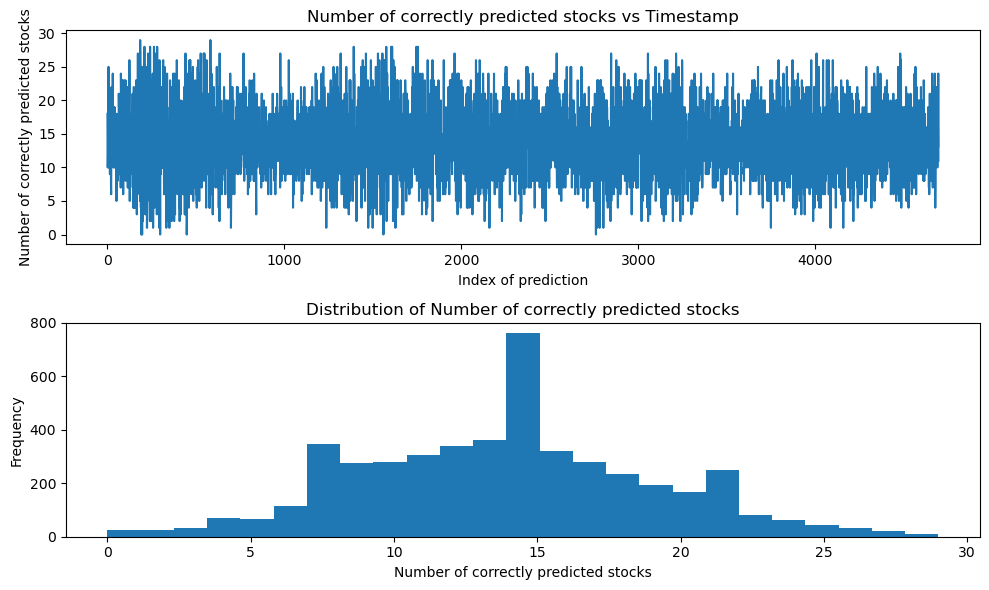

In [26]:
visualize_accuracy_predictions(signs_correctly_predicted)

#### 2.1.4 Calculate cummulative returns

In [27]:
returns_strategy_var = calculate_returns(log_returns.iloc[n_lags*lags+2:, :], signals)
returns_strategy_var = returns_strategy_var.fillna(0)

treturns_stocks_var = 100 * (np.exp(returns_strategy_var.cumsum()) - 1)

for stock in log_returns.columns:
    
    print(f"Trading strategy (VAR) Return on {stock}: {round(treturns_stocks_var[stock].iloc[-1], 2)} %.")
    print(f"Buy and Hold strategy Return on {stock}: {round(returns_stocks[stock].iloc[-1], 2)} %.")
    print("")

sharpe_ratio = (returns_strategy_var.mean(axis = 1).mean() / returns_strategy_var.mean(axis = 1).std()) * np.sqrt(255 * 14)

print(f"Total Return of Buy and Hold: {returns_stocks.iloc[-1, :].mean()}")
print(f"Total Return of VAR Strategy: {treturns_stocks_var.iloc[-1, :].mean()}")
print(f"Annual Sharpe Ratio MA Strategy: {sharpe_ratio}")


Trading strategy (VAR) Return on AAPL: 23.9 %.
Buy and Hold strategy Return on AAPL: -12.68 %.

Trading strategy (VAR) Return on ADBE: 0.0 %.
Buy and Hold strategy Return on ADBE: 23.5 %.

Trading strategy (VAR) Return on ADP: 0.0 %.
Buy and Hold strategy Return on ADP: 18.65 %.

Trading strategy (VAR) Return on AMD: -29.49 %.
Buy and Hold strategy Return on AMD: 241.47 %.

Trading strategy (VAR) Return on AMZN: 9.09 %.
Buy and Hold strategy Return on AMZN: 69.65 %.

Trading strategy (VAR) Return on ASML: 26.63 %.
Buy and Hold strategy Return on ASML: -2.3 %.

Trading strategy (VAR) Return on ATVI: 1.76 %.
Buy and Hold strategy Return on ATVI: 45.42 %.

Trading strategy (VAR) Return on AVGO: -23.97 %.
Buy and Hold strategy Return on AVGO: 19.6 %.

Trading strategy (VAR) Return on CRM: 0.55 %.
Buy and Hold strategy Return on CRM: -0.64 %.

Trading strategy (VAR) Return on CSCO: 0.0 %.
Buy and Hold strategy Return on CSCO: 8.69 %.

Trading strategy (VAR) Return on FISV: 0.0 %.
Buy and Ho

#### 2.1.5 Visualize Market vs. Strategy returns

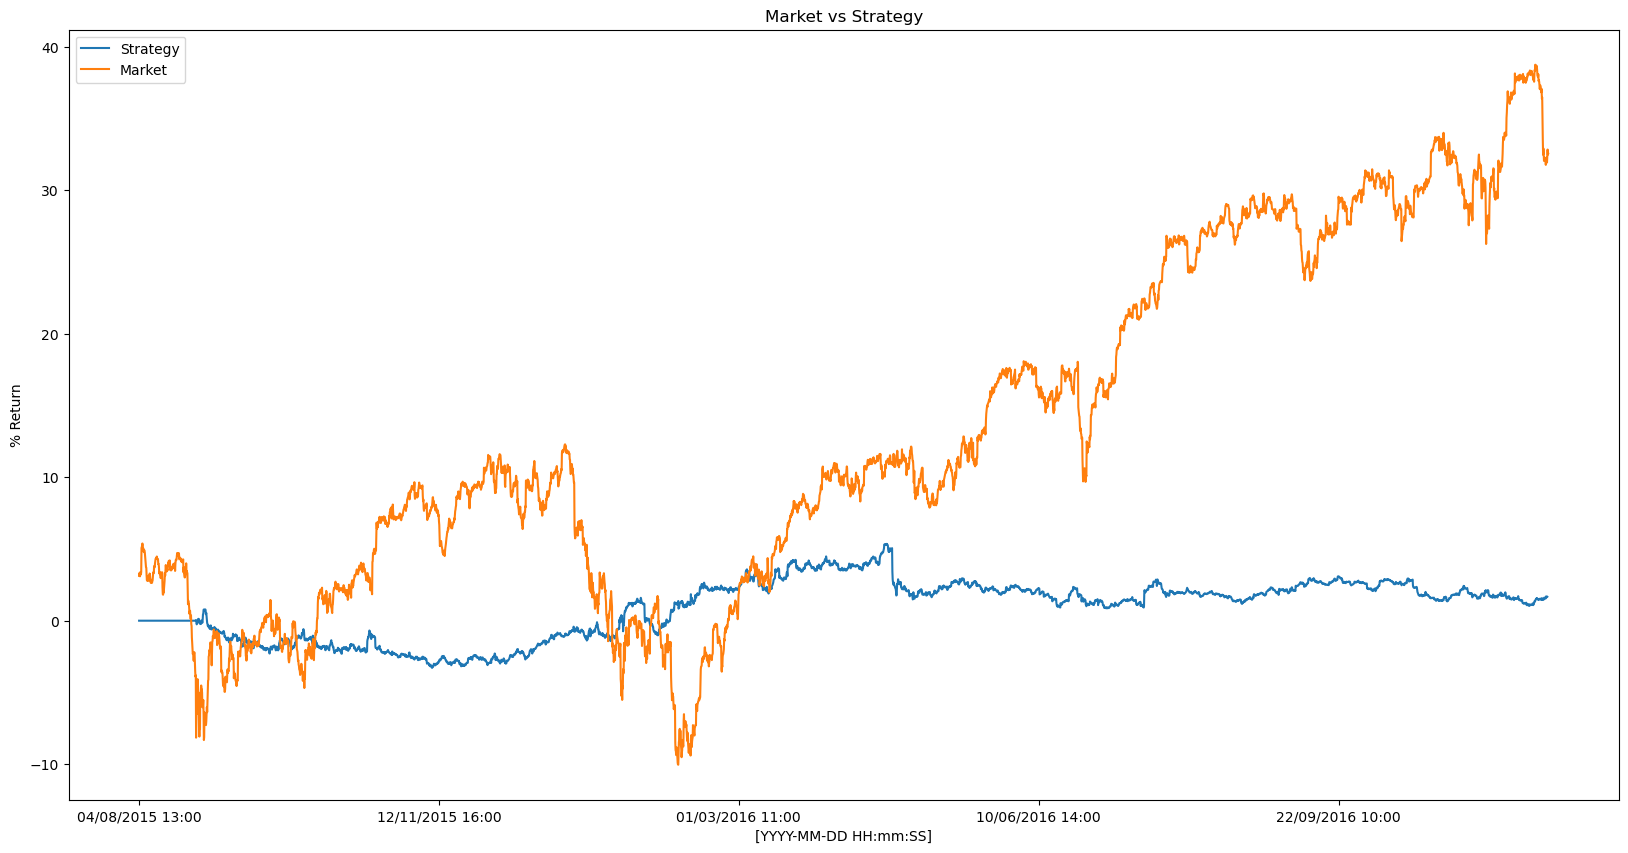

In [28]:
treturns_stocks_var.mean(axis = 1).plot(figsize = (20, 10), label = 'Strategy')
returns_stocks.iloc[lags * n_lags:, :].mean(axis = 1).plot(label = 'Market')
plt.title('Market vs Strategy')
plt.ylabel('% Return')
plt.legend(loc = 'upper left')
# Display the plot
plt.show()

# 3. Dimensionality-Reduction based strategy

## 3.1 Principal Component Analysis - Eigen Portfolio strategy

**Principal Component Analysis (PCA) Strategy - Based on Eigenportfolio Construction:**

The Principal Component Analysis (PCA) strategy is a popular technique in finance for constructing portfolios and analyzing the relationships among multiple assets. It utilizes the concept of eigenportfolios derived from PCA, which is a mathematical technique used to transform a set of correlated variables into a new set of uncorrelated variables called principal components.

**The PCA strategy involves the following key steps:**

**1. Data preprocessing**

Calculate the returns and eliminate any scale differences among stocks - eg: substract the mean and divide by std dev. Also split data into train and test (eg: 70/30 split)

**2. Cov. Matrix Calculation**

Calculate the covariance matrix based on the returns of the stocks (train split). The covariance matrix provides insights into the relationships and dependencies among the stocks in the portfolio. It quantifies the extent to which the returns of different stocks move together or diverge from each other.

**3. Principal Components from PCA**

Perform PCA on the covariance matrix to identify the principal components. Each principal component represents a linear combination of the original stocks. The first principal component, known as the (first) eigenportfolio, explains the largest proportion of the total variance in the portfolio. It represents a diversified portfolio that captures the common movements in the stock returns.

**4. Portfolio Allocation**

Determine the weights or allocations for each stock in the eigenportfolio. These weights represent the contribution of each stock to the overall eigenportfolio. The allocation can be calculated based on the loadings or coefficients associated with each stock in the first principal component.

**5. NOT IMPLEMENTED YET: Portfolio Rebalancing**

Periodically rebalance the portfolio based on the chosen eigenportfolio weights. Adjust the portfolio allocations by buying or selling stocks according to the desired weights.

**Reasons for Choosing PCA Strategy for US Stocks:**

*Diversification:* The PCA strategy allows for the construction of eigenportfolios that capture the common movements in a set of stocks. By diversifying across these eigenportfolios, PCA aims to reduce the risk associated with individual stocks and achieve a more balanced exposure to the overall market.

*Dimensionality Reduction:* PCA helps to reduce the dimensionality of the dataset by transforming a large number of correlated variables (stocks) into a smaller number of uncorrelated variables (principal components). This simplification can enhance the efficiency of portfolio analysis and decision-making.

*Risk Management:* By focusing on the first few principal components that explain the majority of the portfolio's variance, the PCA strategy allows for effective risk management. It helps identify and capture the most significant risk factors in the market, which can lead to more informed investment decisions and improved risk-adjusted returns.

**Assumptions of PCA Strategy:**

*Linear Relationships:* The PCA strategy assumes that the relationships between stock returns are linear. It may not be suitable for capturing nonlinear dependencies or complex market dynamics that exist in certain situations.

*Stationarity:* The underlying assumption of stationarity is often required for the meaningful application of PCA. The stocks' returns should exhibit statistical properties that remain relatively constant over the analyzed time period.

*Normality and Homoscedasticity:* PCA assumes that the stock returns are normally distributed and have constant variances (homoscedasticity). Departures from these assumptions may affect the validity of the PCA results.

In [38]:
from sklearn.decomposition import PCA

## 3.1 Train/Test split + normed returns creation

Why normed returns for PCA?
The PCA calculates a new projection of the dataset. The new axis are based on the standard deviation of your variables. So a variable with a high standard deviation will have a higher weight for the calculation of axis than a variable with a low standard deviation. If you normalize your data, all variables have the same standard deviation, thus all variables have the same weight and your PCA calculates relevant axis.

In [39]:
log_returns_pca = log_returns.copy()
log_returns_pca.index = pd.to_datetime(log_returns_pca.index, format='%d/%m/%Y %H:%M')

# normed returns is needed for PCA
log_returns_normed_pca = (log_returns_pca - log_returns_pca.mean()) / log_returns_pca.std()

print("Initial: ", log_returns_normed_pca.index[0])
print("Last: ", log_returns_normed_pca.index[-1])

# 70/30 split
train_end = log_returns_normed_pca.index[int(0.7 * len(log_returns_normed_pca))]

# normed
log_returns_normed_pca_train = log_returns_normed_pca[log_returns_normed_pca.index <= train_end].copy()
log_returns_normed_pca_test = log_returns_normed_pca[log_returns_normed_pca.index > train_end].copy()

# non-normed
log_returns_pca_train = log_returns_pca[log_returns_pca.index <= train_end].copy()
log_returns_pca_test = log_returns_pca[log_returns_pca.index > train_end].copy()


print("")
print('Train dataset:', log_returns_normed_pca_train.shape, ' ~', int(log_returns_normed_pca_train.shape[0]/2), ' hours')
print('Test dataset:', log_returns_normed_pca_test.shape, ' ~', int(log_returns_normed_pca_test.shape[0]/2), ' hours')

Initial:  2015-07-06 10:00:00
Last:  2016-12-02 12:30:00

Train dataset: (3501, 29)  ~ 1750  hours
Test dataset: (1499, 29)  ~ 749  hours


## 3.2 Covariance matrix + PCA fit

In [40]:
#covariance matrix caclulation
cov_matrix = log_returns_normed_pca_train.cov()

# computing PCA on stocks
pca = PCA().fit(cov_matrix)

### 3.3.1 Visualization

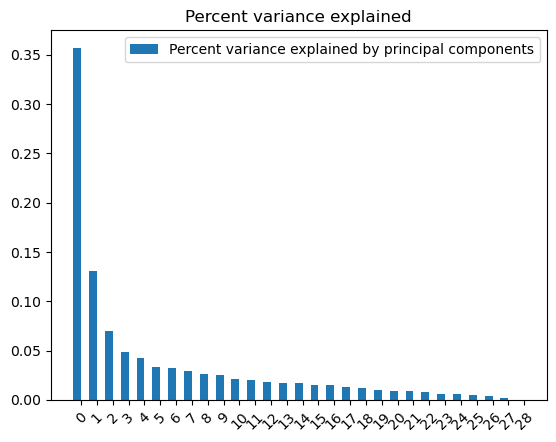

In [41]:
bar_width = 0.5
n_asset =  log_returns_normed_pca_train.shape[1]
x_indx = np.arange(n_asset)
fig, ax = plt.subplots()
    
# Eigenvalues are measured as percentage of explained variance.
rects = ax.bar(x_indx, pca.explained_variance_ratio_, bar_width)
ax.set_xticks(x_indx + bar_width / 2)
ax.set_xticklabels(list(range(n_asset)), rotation=45)
ax.set_title('Percent variance explained')
ax.legend((rects[0],), ('Percent variance explained by principal components',))

### 3.3.2 Visualization of Portfolio weight allocations

In [42]:
num_of_portfolios = 10
top_portfolios = pd.DataFrame(pca.components_[:num_of_portfolios], columns = cov_matrix.columns)
eigen_weights = top_portfolios.div(top_portfolios.sum(1), axis = 0)
eigen_weights.index = [f'portfolio{i}' for i in range(1, num_of_portfolios + 1)]

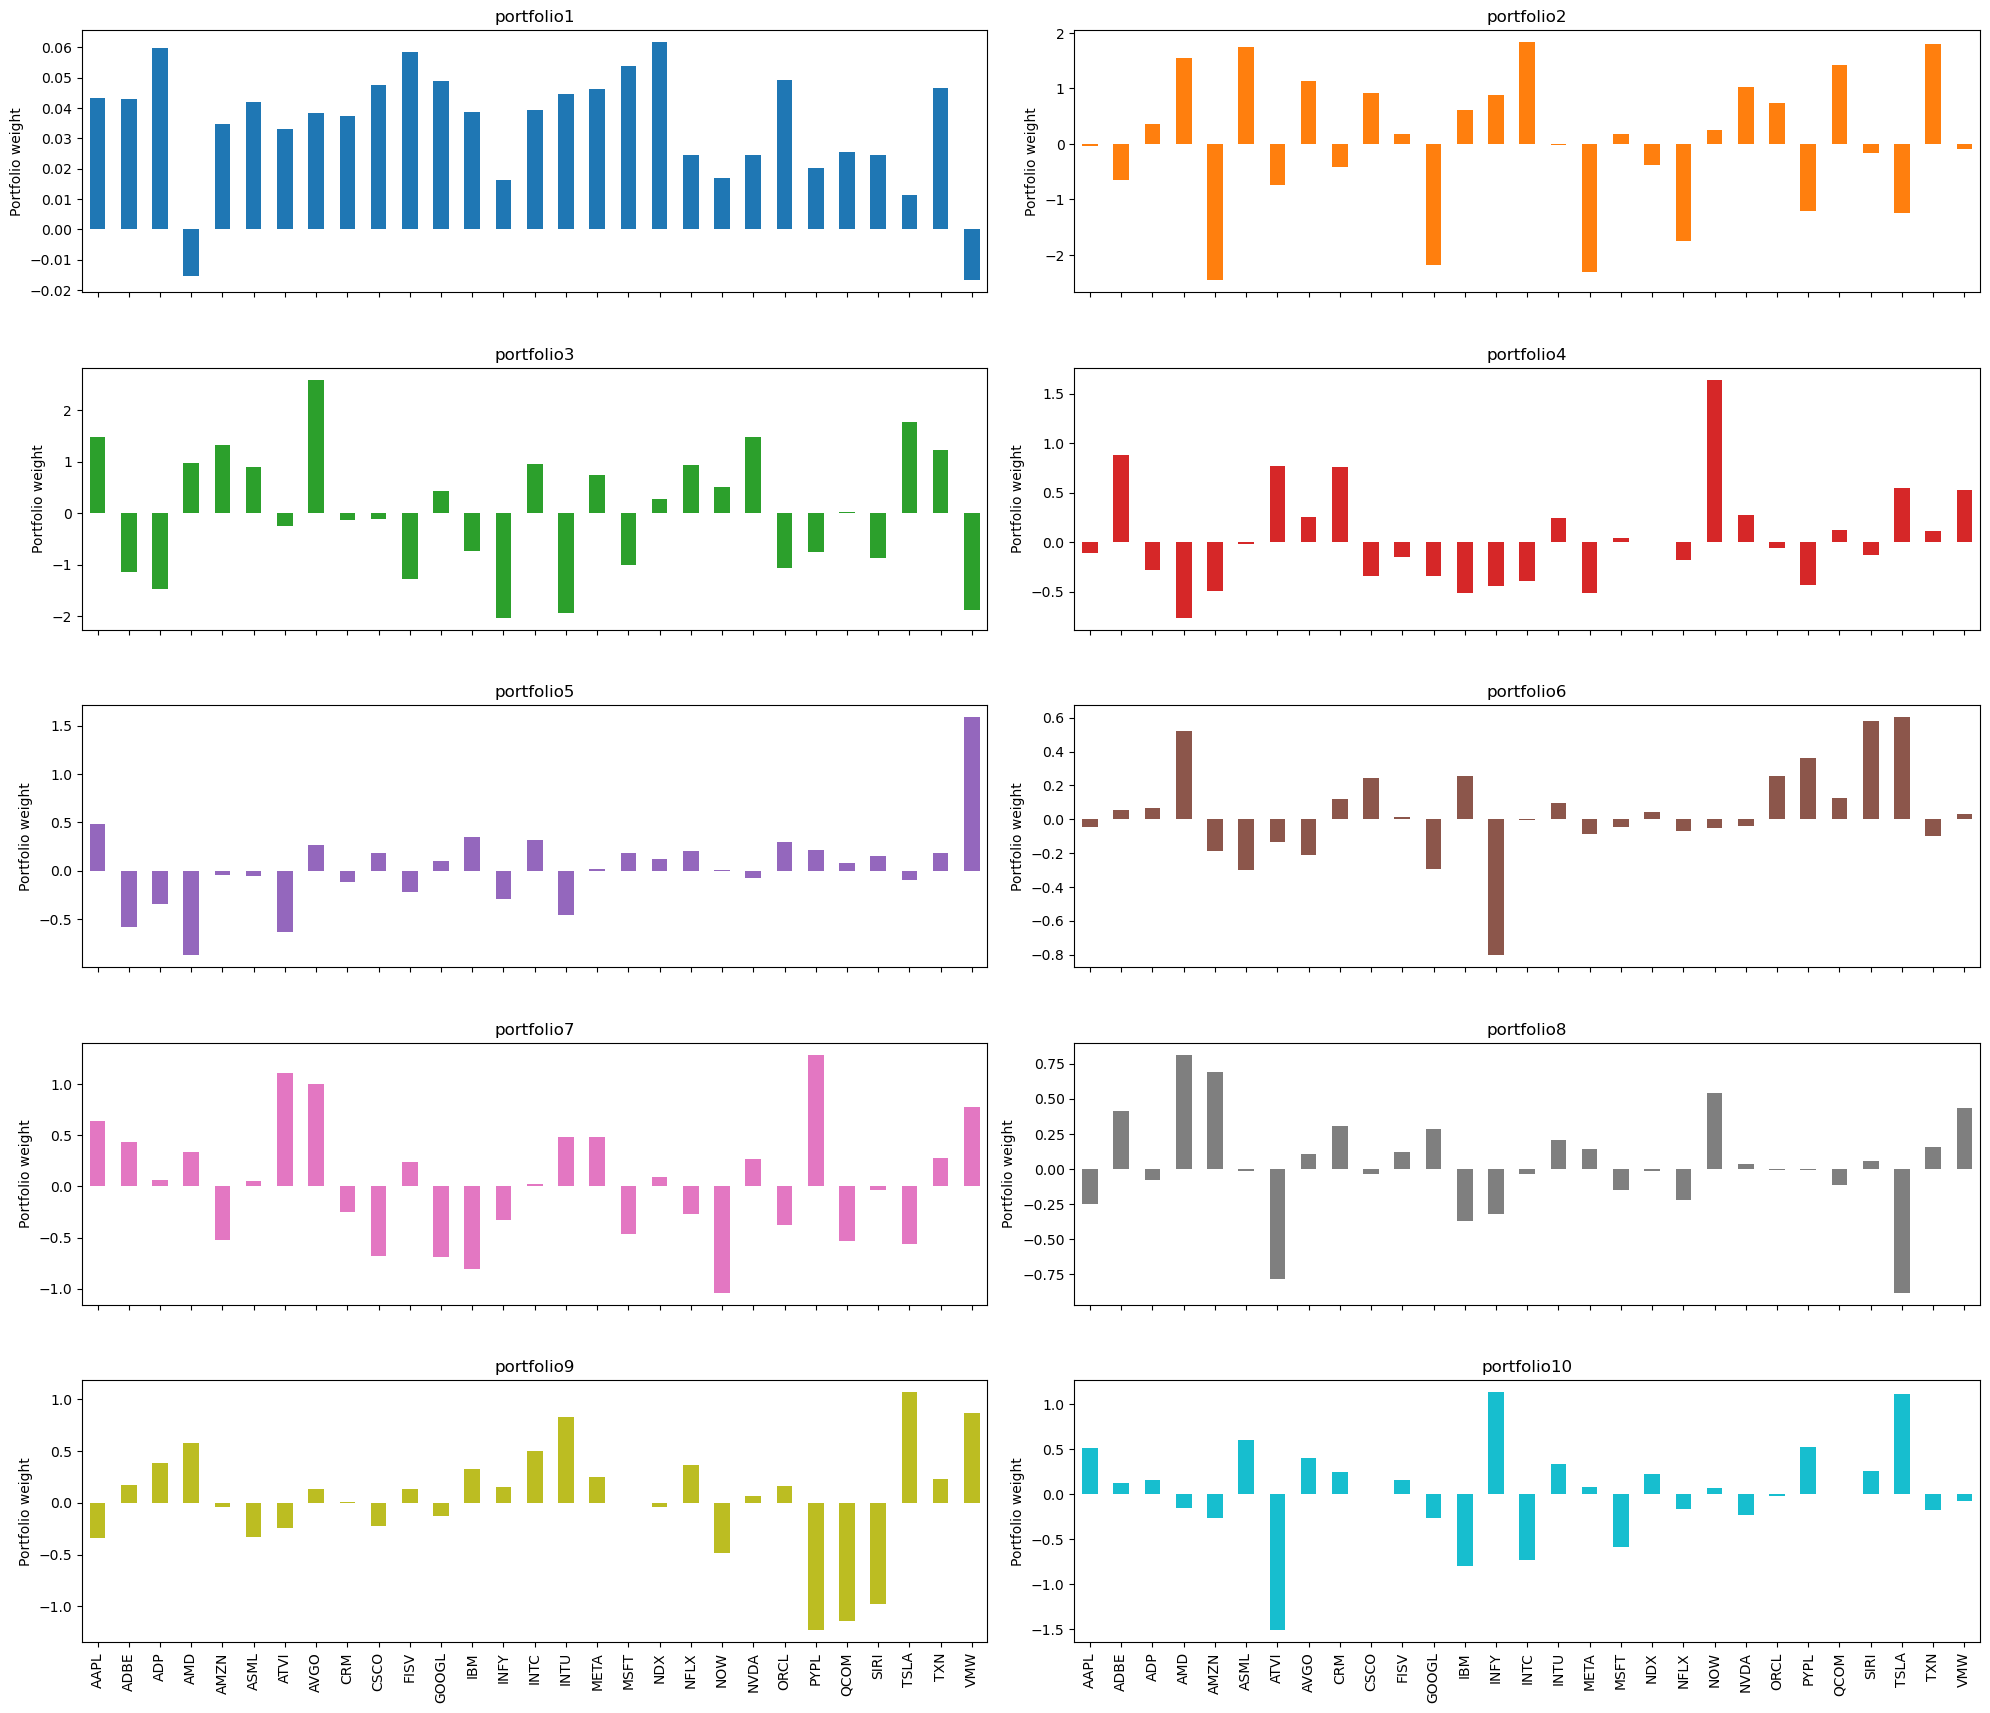

In [43]:
axs = eigen_weights.T.plot.bar(subplots = True,
                              layout = (int(num_of_portfolios / 2) + 1,2),
                              figsize = (20, 20),
                              legend = False)

for ax in axs.flatten():
    ax.set_ylabel('Portfolio weight')
    ax.set_xlabel('')
plt.tight_layout()

### 3.3.3 Portfolio Performance

Sharpe Ratio for PC1:  1.015  Return:  4.98 %
Sharpe Ratio for PC2:  1.514  Return:  45.57 %
Sharpe Ratio for PC3:  2.283  Return:  189.78 %
Sharpe Ratio for PC4:  -0.277  Return:  -23.36 %
Sharpe Ratio for PC5:  1.351  Return:  32.84 %
Sharpe Ratio for PC6:  2.065  Return:  40.28 %
Sharpe Ratio for PC7:  1.511  Return:  42.3 %
Sharpe Ratio for PC8:  3.175  Return:  116.67 %
Sharpe Ratio for PC9:  0.385  Return:  0.52 %
Sharpe Ratio for PC10:  -2.275  Return:  -50.05 %
Return Market:                          21.634 %


<Axes: >

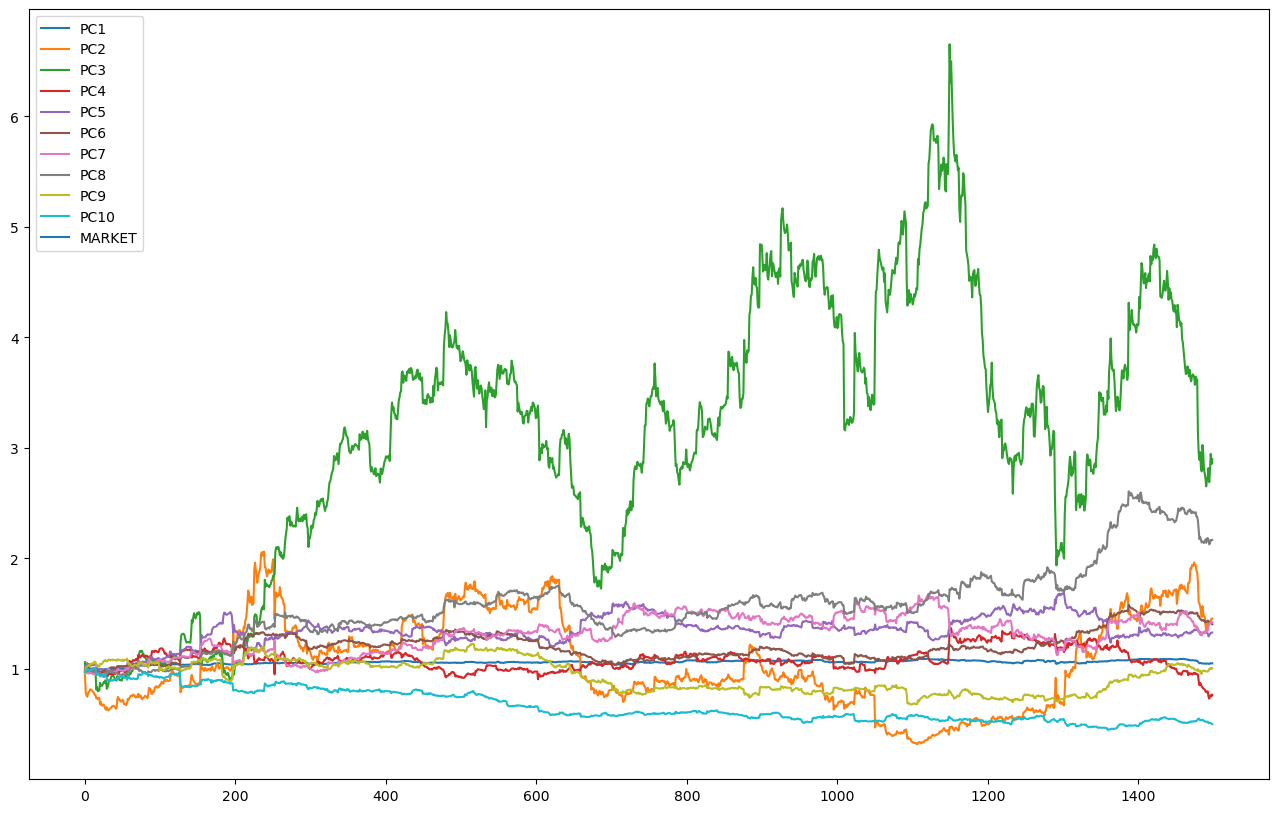

In [44]:
pca_portfolios = pd.DataFrame()
sharpe_ratios_pca = []
for i in range(0, eigen_weights.shape[0]):
    
    market = np.exp(log_returns_pca_test) - 1
    weighted_returns = market * eigen_weights.iloc[i]
    weighted_returns = weighted_returns.sum(axis = 1)
    
    pca_portfolios[f'PC{i+1}'] = np.array((weighted_returns + 1).cumprod())

    
    sharpe_ratios_pca.append((weighted_returns.mean() / weighted_returns.std()) * np.sqrt(255 * 14))
    print(f"Sharpe Ratio for PC{i + 1}: ", round((weighted_returns.mean() / weighted_returns.std()) * np.sqrt(255 * 14), 3), " Return: ", round((pca_portfolios[f'PC{i+1}'].iloc[-1] - 1) * 100, 2), "%")


market = np.exp(log_returns.mean(axis = 1)) - 1
market_cum = (market + 1).cumprod()
print(f"Return Market:                         ", round((market_cum.iloc[-1] - 1) * 100, 3), "%")

pca_portfolios['MARKET'] = market_cum
pca_portfolios.reset_index()
pca_portfolios.plot(figsize = (16, 10), title = '')

**Conclusion + ideas**

PCA seems to work fine. Something that I didnt explore is to see where it made most of the returns (I think it is in short positions where it profitted the most).

1. Why not implement this but recomputing the PCA every day, and rebalancing the portfolio every day.

2. Could rebalance every time the cov_matrix deviates x% from the previous cov_matrix (when it is 'significantly' different from previous cov_matrix) that was used to rebalance the portfolio.

3. Could also create a long-only portfolio and see performance.

4. Could average the weights over all eigenvalues and construct another portfolio


**Observations**
The Principal Eigenportfolios for this data was inspired from the paper "Principal Eigenportfolios for US Equities" (link below). They state (as well as their references) that the "market and the eigenportfolio's returns over time are close". In the paper they rebalance the portfolio every 24 days from 1994 to 2020 (daily data used).

**link to "Principal Eigenportfolios for US Equities"**

https://deliverypdf.ssrn.com/delivery.php?ID=874121115073065005004121116108095029117043064003031030025124076026003093014107112122122049008101104109008007026069018115065117040060087061002007008021126073125105072057062022125015023083093074024001103107027001122094073020018029080016017075124005007105&EXT=pdf&INDEX=TRUE


**Good benchmark for trading strategy:**
- Calculate the value of the market (like we did)
- Nasdaq 100 - 100 us tech companies index

**How can one boost performance of a set of medium performing strategies?**

- Use more data --> more sophisticated models, machine learning(non-linearities captured)
    
    -- 5k rows is too little
    
    -- no volume, maybe volume is correlated!
    
    -- more parameters available
    
- dynamically asses market conditions --> eg: dynamically rebalance
- take into account global factors --> news, policies, changes in governments
- Diversification:

    -- different sectors (FX, bonds, crypto)
    
    -- different frequency of strategies 
    
    -- combining them
- Long-shot: Use LLM's to implement strategies/papers - eg: calling chatgpt API with a brief description of what you are aiming and see if it actually understands papers...